In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

SyntaxError: invalid syntax (4269583495.py, line 2)

In [3]:

import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
import numpy as np
from rasterio.enums import Resampling
import dask
from rasterstats import zonal_stats
import rioxarray as rxr

import torch.nn as nn

import shapely
from shapely.geometry import Polygon
import rioxarray as rxr
from rasterio.features import rasterize

warnings.filterwarnings("ignore")

### Load mining data and visualize

In [99]:
# Load mine polygons from Tang dataset and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


In [47]:
# Load mine point data
mine_pts = gpd.read_file('data/pitlakes').to_crs(epsg=4326)

# Print info about dataset
print(mine_pts['Material'].value_counts())
print(len(mine_pts))
print(mine_pts['ID'].value_counts())

Material
coal         27
Al           24
Au           22
limestone    18
diamond      13
Fe           13
U             6
sand          4
phosphate     1
Cu            1
Name: count, dtype: int64
1004
ID
Ridgeway2    1
CC2          1
CC3          1
CC5          1
CC4          1
Pritzen      1
NULL+        1
Name: count, dtype: int64


In [4]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

In [5]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA['category']=='a')}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 11005'

#### Assess distribution of pits

4466
9625.4706495206
175949623.2529024
310764.76698829106
930940.420756829
557.4627942636989


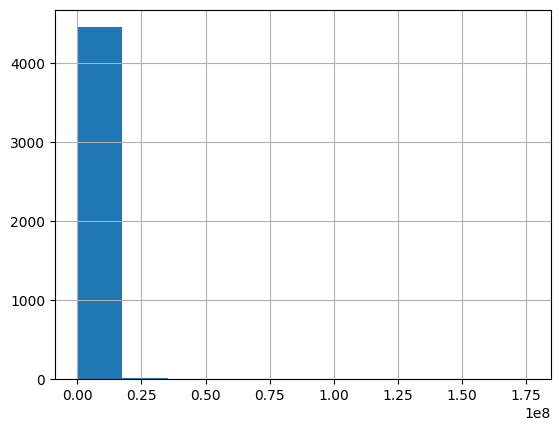

In [526]:
QA_global_mines = psql_bboxes[psql_bboxes['category']=='a']

QA_global_mines_gdf = gpd.GeoDataFrame(QA_global_mines, geometry = 'geometry', crs = 4326)

QA_global_mines_gdf = QA_global_mines_gdf.to_crs(epsg=9822)

pit_areas = QA_global_mines_gdf.geometry.area

pit_areas.hist(bins=10)

print(len(pit_areas))

print(pit_areas.min())
print(pit_areas.max())
print(pit_areas.median())
print(pit_areas.mean())

print(math.sqrt(pit_areas.median()))

0.7655620241827138
316.22776601683796
894.4271909999159
797
129532.97231740363
750606.8932339188


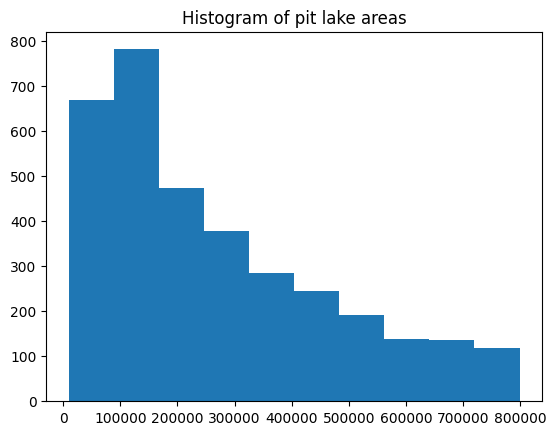

In [600]:
pit_areas_majority = pit_areas[pit_areas<(0.008*1e8)]
print(len(pit_areas_majority)/len(pit_areas))

plt.hist(pit_areas_majority,bins=10)
plt.title('Histogram of pit lake areas')
#plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])

#plt.show()

mode_length = math.sqrt(0.1*1e6)
print(mode_length)
print(math.sqrt(800000))
print(len(pit_areas[pit_areas<(100000)]))

import scipy
print(np.percentile(pit_areas, 25))
print(np.percentile(pit_areas, 75))


<Axes: >

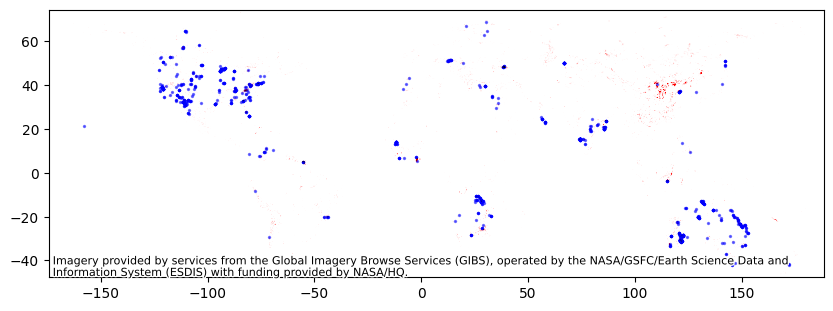

In [137]:
# Visualize with satellite basemap
providers = cx.providers.flatten()

# Visualize mine point data
ax = mine_pts.plot(column = 'Material', 
    markersize = 2,
    color = 'blue', 
    legend = True, 
    legend_kwds={'bbox_to_anchor': (1, 1)},
    figsize = (10,10),
    alpha = 0.5)
cx.add_basemap(ax, crs=mine_pts.crs, source=providers['NASAGIBS.BlueMarble'])

mine_poly.plot(ax=ax, color = 'red', linewidth = 6)

#### Filter QA'ed dataset

In [7]:
states = gpd.read_file('data/state_boundaries')

# Get only QA'ed pits that are 0.5 or greater (i.e. have been QA'ed and/or higher likelihood)
print(len(US_QA))
US_QA['score'] = US_QA['score'].apply(lambda score: float(score))
US_QA_filtered = US_QA[US_QA['score'] > 0.5]
US_QA_filtered['feature_idx'] = US_QA_filtered.reset_index(drop=True).index # Use for dissolve on spatial joining
print(len(US_QA_filtered))


# Get only states with pit lakes
states['geometry'] = states['geometry'].apply(lambda geom: gpd.GeoSeries([geom]).unary_union)
states = gpd.GeoDataFrame(states, geometry='geometry', crs=states.crs).to_crs(epsg = 4326)
states = states[~states['STUSPS'].isin(['VI','PR','GU','MP','AS'])]

states_with_pits = gpd.sjoin(states, US_QA_filtered, how = 'left', predicate = 'intersects')
states_with_pits = states_with_pits[~states_with_pits['score'].isna()]

# Take out states with less than 5 pit lakes
states_with_enough_pits = states_with_pits['STUSPS'].value_counts() > 5
states_list = states_with_enough_pits[states_with_enough_pits].index.to_list()

states_with_low_pits = states_with_pits['STUSPS'].value_counts() < 5
print(states_with_low_pits[states_with_low_pits].index)

11005
2491
Index(['NJ', 'NY', 'OR', 'KS'], dtype='object', name='STUSPS')


In [8]:
states_filtered = states_with_pits[states_with_pits['STUSPS'].isin(states_list)].drop_duplicates('geometry')[['STUSPS','geometry']]

states_geometries = states[states['STUSPS'].isin(states_list)]
print(f'States being used: {len(states_geometries)}')

States being used: 36


#### Ohio, Kentucky, West Virginia

In [29]:
# Get pit lakes in OH, KY, WV

states = gpd.read_file('data/state_boundaries')
oh = states[states['STUSPS']=='OH']
oh = oh.to_crs(epsg = 4326).geometry.unary_union

oh_qa = US_QA[US_QA.geometry.intersects(oh)]
print(f'OH QAed mines: {(oh_qa['category'] == 'a').sum()}')

ky = states[states['STUSPS']=='KY']
ky = ky.to_crs(epsg = 4326).geometry.unary_union

ky_qa = US_QA[US_QA.geometry.intersects(ky)]
print(f'KY QAed mines: {(ky_qa['category'] == 'a').sum()}')

wv = states[states['STUSPS']=='WV']
wv = wv.to_crs(epsg = 4326).geometry.unary_union
wv_qa = US_QA[US_QA.geometry.intersects(wv)]
print(f'WV QAed mines: {(wv_qa['category'] == 'a').sum()}')

OH QAed mines: 57
KY QAed mines: 70
WV QAed mines: 41


#### Arizona

In [28]:
# Get pit lakes in AZ

states = gpd.read_file('data/state_boundaries')
az = states[states['STUSPS']=='AZ']
az = az.to_crs(epsg = 4326).geometry.unary_union

#az_mines_pts = mine_pts[mine_pts.geometry.within(az)]
#az_mines_poly = mine_poly[mine_poly.geometry.intersects(az)]
#az_mines_intersect = mine_pts_polys[mine_pts_polys.geometry.intersects(az)] # Only keep polygons with confirmed Aquarry points

az_qa = US_QA[US_QA.geometry.intersects(az)]
print(f'AZ QAed mines: {(az_qa['category'] == 'a').sum()}')

AZ QAed mines: 56


In [58]:
# Hold out Miami AZ

miami_az = gpd.read_file('data/miami_az_pits.geojson')
az_mines_intersect = az_mines_intersect[~az_mines_intersect.geometry.within(miami_az.geometry.iloc[0])]

print(len(az_mines_intersect))

az_qa = az_qa[~az_qa.geometry.intersects(miami_az.geometry.iloc[0])]

42


#### Get MN data and separate mines / other bodies of water

In [37]:
# Get pit lakes in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union # MN was multipolygon

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')

MN QAed mines: 87


In [31]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']

dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

dnr_pit_lakes.head()


200
130746


wb_class    shape_Area  \
411     Natural Ore Mine  1.069300e+05   
1089    Natural Ore Mine  1.319908e+04   
1156  Mine Pit Lake (NF)  1.886662e+05   
1228       Mine Pit Lake  1.145849e+07   
2000    Natural Ore Mine  3.979919e+04   

                                               geometry  
411   POLYGON ((-92.69807 47.51515, -92.69809 47.515...  
1089  POLYGON ((-92.56445 47.4694, -92.56435 47.4693...  
1156  POLYGON ((-94.00199 46.48612, -94.00145 46.485...  
1228  POLYGON ((-92.64102 47.55076, -92.64056 47.550...  
2000  POLYGON ((-92.74355 47.51982, -92.74342 47.519...

In [38]:
mn_qa_pits = mn_qa[mn_qa['category']=='a']
overlap_check = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["objectid"])
print(f"% of mine QA'ed data with overlapping polygon from MN DNR: {len(overlap_check)/len(mn_qa_pits)*100}")

overlap_check = gpd.sjoin(dnr_pit_lakes, mn_qa_pits, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["geometry"])
print(f"% of DNR polygons with overlapping mine QA'ed data: {len(overlap_check)/len(dnr_pit_lakes)*100}")


% of mine QA'ed data with overlapping polygon from MN DNR: 63.2183908045977
% of DNR polygons with overlapping mine QA'ed data: 28.999999999999996


<Axes: >

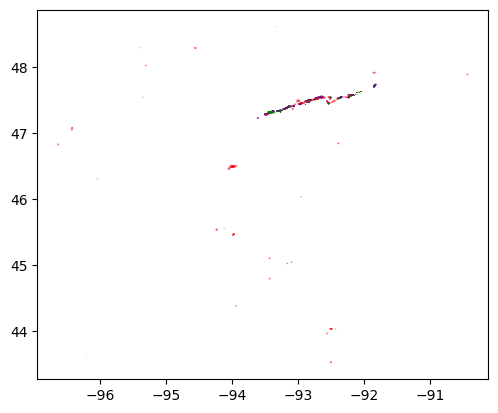

In [119]:
#Visualize overlap of Minnesota Aquarry QAed mines and DNR polygons
providers = cx.providers.flatten()

overlap = gpd.sjoin(dnr_pit_lakes,mn_qa_pits,how = "inner",rsuffix="1")

ax = overlap.plot(edgecolor = 'blue')
dnr_pit_lakes.plot(ax = ax,edgecolor = 'red', alpha = 0.5)
mn_qa_pits.plot(ax = ax, color = 'green',markersize = 1)

In [17]:
# Hold out Crosby MN

crosby_mn = gpd.read_file('data/crosby_mn.geojson')
dnr_pit_lakes = dnr_pit_lakes[~dnr_pit_lakes.geometry.intersects(crosby_mn.geometry.iloc[0])]
mn_qa = mn_qa[~mn_qa.geometry.intersects(crosby_mn.geometry.iloc[0])]
dnr_water = dnr_water[~dnr_water.geometry.intersects(crosby_mn.geometry.iloc[0])]

print((mn_qa['category']=='a').sum())
print(len(dnr_water))

87
129133


#### Visualize AZ and MN mines

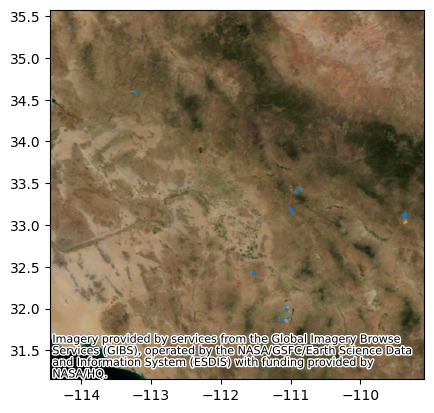

In [ ]:
# Visualize AZ pit lakes
providers = cx.providers.flatten()

ax = az_mines_intersect.plot()
cx.add_basemap(ax, crs=az_mines_intersect.crs, source=providers['NASAGIBS.BlueMarble'])

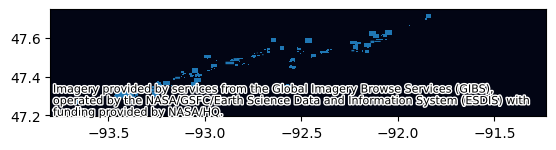

In [66]:
# Visualize MN pit lakes
providers = cx.providers.flatten()

ax = mn_qa.plot()
cx.add_basemap(ax, crs=mn_qa.crs, source=providers['NASAGIBS.BlueMarble'])

#### Check on handling of clouds


In [57]:
# UNFINISHED 

def ReadEmbeddingsFromFolder(folder_path):
    """ 
    
    Parameters:
    folder_path (str): folder with embeddings
    
    Returns:
    """
    folders = []
    embeddings = []

    # Go through all embedding folders
    folder_list = os.listdir(folder_path)

    # Get list of folders to search through
    for folder in folder_list: 
        folders.append(f"{folder_path}{folder}")

    # In each folder, go through parquet files and add file to list
    for folder in folders: 
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        
        for file in parquet_files:
            .append(file)
    


    return embeddings

In [94]:
# Grab a cloudy scene 
# 7/30 is very cloudy, 7/27 has clouds in top left corner

cloudy_scene = "data/MN_v1_5/UL/2024/7/S2B_15TUL_20240730_0_L2A/S2B_15TUL_20240730_0_L2A.parquet"

cloudy_scene_chips = gpd.read_parquet(cloudy_scene)
cloudy_scene_chips = gpd.GeoDataFrame(cloudy_scene_chips).set_crs(epsg=4326)

print(len(cloudy_scene_chips))

# Perform PCA on scene
cloudy_pca = EmbeddingsPCA(cloudy_scene_chips)

484
Relative variance in principal components: [0.2692709]


<Axes: >

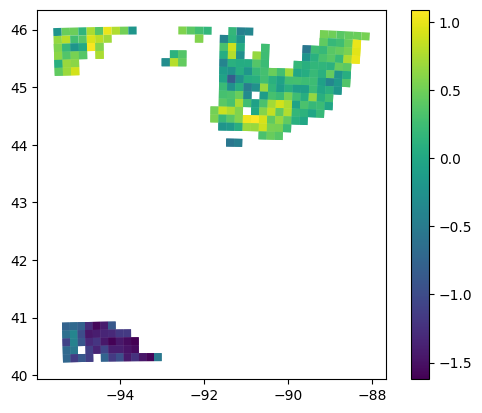

In [95]:
# Visualize scene PCA

cloudy_pca.plot(column='pca1', legend=True)

Text(0.5, 1.0, 'PCA of Cloudy Scene Embeddings')

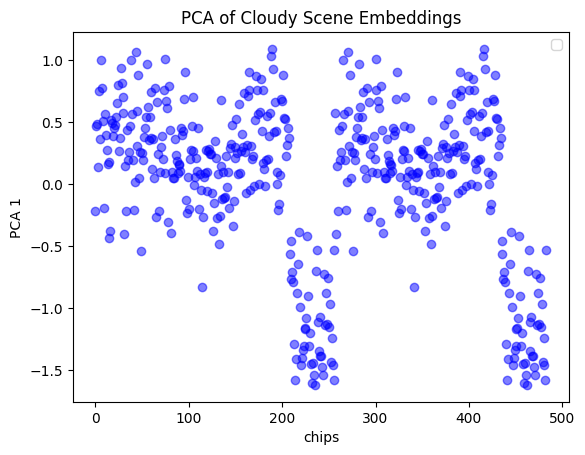

In [72]:
# Visualize the first principal component
fig, ax = plt.subplots()

    # Plot for category 1
ax.scatter(cloudy_pca.index,
    cloudy_pca[cloudy_pca['clouds'] == True]['pca1'], 
           color='blue', alpha=0.5)

    # Plot for category 2
#ax.scatter(cloudy_pca.index,
#    cloudy_pca[cloudy_pca['clouds'] == False]['pca1'], 
#           color='grey', alpha=0.05)
    
""" EDIT SO CAN SEE WHAT THE LITTLE OVERLAP IS  plt.scatter(data[data['wb_'] == new_condition]['pca1'], 
            data[data[new_class_column] == new_condition]['pca2'], 
            color='red', label=label3, alpha=0.5, marker='^') """

plt.xlabel('chips')
plt.ylabel('PCA 1')
ax.legend()
plt.title('PCA of Cloudy Scene Embeddings')


#### Grab embeddings for mines and random embeddings

In [686]:
# DEPRECATED
# Define function for getting embedding files that intersect with polygons of interest

def GetEmbeddingsFromIntersection(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) image files with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embeddings
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of embedding gpq file names """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []
    folders = []

    # Go through all embedding folders
        # Folder structure: Grid zone, year, month, embedding folder, parquet file
    folder_list = os.listdir(folder_path)

    import random

    # Get list of folders to search through
    for folder in folder_list: 
        folders.append(f"{folder_path}{folder}")

    # In each folder, go through parquet files and add file to list if it contains mines
    for folder in folders: 
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]

        # Check if image has any intersecting chips
        for file in parquet_files:
            pqs = gpd.read_parquet(file, columns=["geometry"])
            if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                positive_embeddings.append(file)
            else: 
                if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                    negatives_list.append(file)
                                
        if random_images == True:
            # Set up to get random images
            index = np.array(random.sample(range(1, len(negatives_list)), count))

            for i in index:
                negative_embeddings.append(negatives_list[i])           
            print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [134]:
# Define function for getting embedding files that intersect with polygons of interest
# USE WHEN DON'T HAVE BIGGER GRID ZONES TO SEARCH THROUGH

def GetEmbeddingsFromIntersection1_5(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) scene file names with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embedding gpqs
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of scenes  """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []

    # Go through all embedding folders
    # Folder structure: Grid zone, year, month, embedding folder, parquet file
    grid_zone_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for grid_zone_folder in grid_zone_folders:
        grid_zone = os.path.basename(grid_zone_folder)
        # Get list of year folders
        year_folders = [os.path.join(grid_zone_folder, year) for year in os.listdir(grid_zone_folder) if os.path.isdir(os.path.join(grid_zone_folder, year))]
    
        for year_folder in year_folders:
            year = os.path.basename(year_folder)
            # Get list of month folders
            month_folders = [os.path.join(year_folder, month) for month in os.listdir(year_folder) if os.path.isdir(os.path.join(year_folder, month))]
            
            for month_folder in month_folders:
                month = os.path.basename(month_folder)
                year_month = f"{year}_{month}"
                    
                # Get list of embedding folders
                embedding_folders = [os.path.join(month_folder, embedding) for embedding in os.listdir(month_folder) if os.path.isdir(os.path.join(month_folder, embedding))]
                
                for embedding_folder in embedding_folders:
                    # Get all parquet files in the embedding folder
                    parquet_files = [os.path.join(embedding_folder, f) for f in os.listdir(embedding_folder) if f.endswith(".parquet")]

                    parquet_files_details = []

                    # Append parquet file details with grid zone and year_month to the list
                    for parquet_file in parquet_files:
                        parquet_files_details.append({
                            "file_path": parquet_file,
                            "grid_zone": grid_zone,
                            "year_month": year_month
                        })

                    # In each folder, go through parquet files and add file to list if it contains mines
                    # Check if image has any intersecting chips
                    for file in parquet_files_details:
                        if os.path.getsize(file['file_path']) > 0:
                           pqs = gpd.read_parquet(file['file_path'], columns=["geometry"])
                        else:
                            print(f"Skipping empty file: {file['file_path']}")
                        if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                            positive_embeddings.append(file)
                        else: 
                            if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                                negatives_list.append(file)
                                            
                    if random_images == True:
                        # Set up to get random images
                        index = np.array(random.sample(range(1, len(negatives_list)), count))

                        for i in index:
                            negative_embeddings.append(negatives_list[i])           
                        print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [286]:
# Define function for getting embedding files that intersect with polygons of interest
# USE WHEN HAVE BIGGER GRID ZONES TO SEARCH THROUGH

def GetEmbeddingsFromIntersection1_5(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) scene file names with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embedding gpqs
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of scenes  """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []

    # Go through all embedding folders
    # Folder structure: latitude grid, Grid zone, year, month, embedding folder, parquet file
    latitude_grid_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for latitude_grid_folder in latitude_grid_folders:
        latitude_grid = os.path.basename(latitude_grid_folder)
        # Get list of grid zone folders
        grid_zone_folders = [os.path.join(latitude_grid_folder, folder) for folder in os.listdir(latitude_grid_folder) if os.path.isdir(os.path.join(latitude_grid_folder, folder))]

        for grid_zone_folder in grid_zone_folders:
            grid_zone = os.path.basename(grid_zone_folder)
            # Get list of year folders
            year_folders = [os.path.join(grid_zone_folder, year) for year in os.listdir(grid_zone_folder) if os.path.isdir(os.path.join(grid_zone_folder, year))]
    
            for year_folder in year_folders:
                year = os.path.basename(year_folder)
                # Get list of month folders
                month_folders = [os.path.join(year_folder, month) for month in os.listdir(year_folder) if os.path.isdir(os.path.join(year_folder, month))]
                
                for month_folder in month_folders:
                    month = os.path.basename(month_folder)
                    year_month = f"{year}_{month}"
                        
                    # Get list of embedding folders
                    embedding_folders = [os.path.join(month_folder, embedding) for embedding in os.listdir(month_folder) if os.path.isdir(os.path.join(month_folder, embedding))]
                    
                    for embedding_folder in embedding_folders:
                        # Get all parquet files in the embedding folder
                        parquet_files = [os.path.join(embedding_folder, f) for f in os.listdir(embedding_folder) if f.endswith(".parquet")]

                        parquet_files_details = []

                        # Append parquet file details with grid zone and year_month to the list
                        for parquet_file in parquet_files:
                            parquet_files_details.append({
                                "file_path": parquet_file,
                                "grid_zone": grid_zone,
                                "year_month": year_month
                            })

                        # In each folder, go through parquet files and add file to list if it contains mines
                        # Check if image has any intersecting chips
                        for file in parquet_files_details:
                            if os.path.getsize(file['file_path']) > 0:
                                pqs = gpd.read_parquet(file['file_path'], columns=["geometry"])
                            else:
                                print(f"Skipping empty file: {file['file_path']}")
                            if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                                positive_embeddings.append(file)
                            else: 
                                if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                                    negatives_list.append(file)
                                                
                        if random_images == True:
                            # Set up to get random images
                            index = np.array(random.sample(range(1, len(negatives_list)), count))

                            for i in index:
                                negative_embeddings.append(negatives_list[i])           
                            print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [139]:
# Make monthly aggregates without averaging
# USE IF GEOMETRIES OVERLAP

def MonthlyComposite(embeddings_df, polygons = None):

    monthly_agg_embeddings = gpd.GeoDataFrame()
    if polygons is not None:
        polys_geometry = polygons.unary_union

    for zone in embeddings_df['grid_zone'].unique(): # For each UTM zone
        zone_embeddings = pd.DataFrame(embeddings_df[embeddings_df['grid_zone'] == str(zone)])
        count = 1

        for index, row in zone_embeddings.iterrows(): # For each date within UTM zone
             # Will need to adjust when more months are available, currently just goes through whole list
            chip_embeddings_agg_gdf = gpd.GeoDataFrame()
            non_intersecting_chips = gpd.GeoDataFrame()
            chip_embeddings = gpd.read_parquet(row['file_path'])
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)

            if len(chip_embeddings) > 2000: # If the image is not very cloudy
                if polygons is not None: # Don't include chips that don't correspond to the polygons
                    chip_embeddings = chip_embeddings[chip_embeddings.geometry.intersects(polys_geometry)]
                if not monthly_agg_embeddings.empty:
                    # Get all chips that aren't already in the aggregation
                    chips_intersection = chip_embeddings.geometry.intersects(monthly_agg_embeddings_unified)
                    non_intersecting_chips = chip_embeddings[~chips_intersection]
                    chip_embeddings_agg_gdf = non_intersecting_chips.rename(columns={'embeddings_left': 'embeddings'})
                    
                    # Add chips that intersect with aggregation that are less than 25% overlapping
                    intersecting_chips = chip_embeddings[chips_intersection]
                    intersecting_chips['chip_area'] = intersecting_chips.geometry.area
                    intersections = intersecting_chips.geometry.intersection(monthly_agg_embeddings_unified)
                    intersecting_chips['area_overlap'] = intersections.area
                    low_intersection_mask = (intersecting_chips['area_overlap'] / intersecting_chips['chip_area']) < 0.25
                    low_intersection_chips = intersecting_chips[low_intersection_mask].rename(columns={'embeddings_left': 'embeddings'})
                    # Add chips with small overlap to aggregated embeddings
                    chip_embeddings_agg_gdf = pd.concat([chip_embeddings_agg_gdf,low_intersection_chips])
                else:
                    non_intersecting_chips = chip_embeddings
                    chip_embeddings_agg_gdf = gpd.GeoDataFrame(non_intersecting_chips['embeddings'], columns = ['embeddings'], geometry=non_intersecting_chips['geometry'])
                chip_embeddings_agg_gdf['grid_zone'] = zone
                chip_embeddings_agg_gdf['year_month'] = zone_embeddings['year_month'].iloc[0]

                # Add additional chips
                monthly_agg_embeddings = pd.concat([monthly_agg_embeddings, chip_embeddings_agg_gdf])

                # Get geometries of aggregated chips to compare against
                chip_embeddings_agg_gdf_unified = chip_embeddings_agg_gdf.unary_union
                monthly_agg_embeddings_unified = monthly_agg_embeddings.union(chip_embeddings_agg_gdf_unified).unary_union
                #count = count + 1
                print('added') 
                #if count == 3: # Check two images without clouds
                    #count = 1
                break
    
    monthly_agg_embeddings.to_crs(epsg=4326)
    monthly_agg_embeddings = monthly_agg_embeddings.drop_duplicates('geometry')

    return monthly_agg_embeddings


In [135]:
# Get embeddings by region
def RegionalData(region, zone, negatives = True):
    qa_pits = gpd.sjoin(US_QA_filtered, region, how = 'inner', predicate = 'intersects')
    qa_pits = qa_pits.dissolve(by = 'feature_idx')

    us_qa_pits = qa_pits[qa_pits['category'] == 'a']
    us_qa_nonlakes = qa_pits[~qa_pits['category'].isin(['a','q','\\N'])]

    print(len(us_qa_pits))

    # Get embeddings for pit lakes and no pit lakes present in US zone from QA data
    print(f'data/US_v1_5/{zone}')
    mine_embeddings_us, non_mine_embeddings_us = GetEmbeddingsFromIntersection1_5(folder_path = f'data/US_v1_5/{zone}', polygons = us_qa_pits, random_images=False)
    print(f"Number of images with mines: {len(mine_embeddings_us)}")

    # Get monthly embeddings for pit lake embeddings in MN
    mine_embeddings_us_df = pd.DataFrame(mine_embeddings_us, columns = ['file_path','grid_zone','year_month'])

    us_positive_embs_avg = MonthlyComposite(mine_embeddings_us_df, us_qa_pits)
    print(len(us_positive_embs_avg))
    
    us_negative_embs_avg = gpd.GeoDataFrame()
    if negatives == True:
        # Get embeddings for features identified as not lakes from QA
        qa_non_mine_embeddings_us, dummy = GetEmbeddingsFromIntersection1_5(folder_path = f'data/US_v1_5/{zone}', polygons = us_qa_nonlakes, random_images=False)
        print(f"Number of negative mine images: {len(qa_non_mine_embeddings_us)}")

        # Get monthly embeddings for water and non-pit lake embeddings in MN
        qa_non_mine_embeddings_us_df = pd.DataFrame(qa_non_mine_embeddings_us, columns = ['file_path','grid_zone','year_month'])

        us_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_us_df, us_qa_nonlakes)
        print(len(us_negative_embs_avg))

    return us_positive_embs_avg, us_negative_embs_avg
    


In [16]:
region16 = states_filtered[states_filtered['STUSPS'].isin(['MN', 'MI', 'IL', 'IN', 'OH', 'MS', 'AL', 'GA', 'LA', 'FL', 'MO'])]

qa_pits_16 = gpd.sjoin(US_QA_filtered, region16, how = 'inner', predicate = 'intersects')
qa_pits_16['geometry'] = qa_pits_16.geometry
qa_pits_16 = qa_pits_16.dissolve(by = 'feature_idx')


us_qa_pits_16 = qa_pits_16[qa_pits_16['category'] == 'a']
us_qa_nonlakes_16 = qa_pits_16[~qa_pits_16['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_16))

region17 = states_filtered[states_filtered['STUSPS'].isin(['MI', 'OH', 'NY', 'PA', 'WV', 'VA', 'NC', 'SC', 'KY', 'TN', 'GA','FL'])]

qa_pits_17 = gpd.sjoin(US_QA_filtered, region17, how = 'inner', predicate = 'intersects')
qa_pits_17['geometry'] = qa_pits_17.geometry
qa_pits_17 = qa_pits_17.dissolve(by = 'feature_idx')

us_qa_pits_17 = qa_pits_17[qa_pits_17['category'] == 'a']
us_qa_nonlakes_17 = qa_pits_17[~qa_pits_17['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_17))



921
729


In [136]:
region16T = states_filtered[states_filtered['STUSPS'].isin(['MN', 'MI', 'IL', 'IN', 'OH'])]
region16S = states_filtered[states_filtered['STUSPS'].isin(['IL', 'IN', 'OH', 'MS', 'AL', 'GA', 'MO'])]
region16R = states_filtered[states_filtered['STUSPS'].isin(['MS', 'AL', 'GA','LA','FL'])]

In [140]:
us16T_positive_embs_avg, us16T_negative_embs_avg = RegionalData(region16T, '16/T')
us16R_positive_embs_avg, us16R_negative_embs_avg = RegionalData(region16R, '16/R')
us16S_positive_embs_avg, us16S_negative_embs_avg = RegionalData(region16S, '16/S')

375
data/US_v1_5/16/T
Number of images with mines: 761
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
111
Number of negative mine images: 711
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
62
528
data/US_v1_5/16/R
Number of images with mines: 179
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
29
Number of negative mine images: 154
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
17
656
data/US_v1_5/16/S
Num

In [465]:
region17T = states_filtered[states_filtered['STUSPS'].isin(['MI', 'OH', 'PA','NY'])]
us17T_positive_embs_avg, us17T_negative_embs_avg = RegionalData(region17T, '17/T')

123
data/US_v1_5/17/T
Skipping empty file: data/US_v1_5/17/T\MG\2024\9\S2B_17TMG_20240907_0_L2A\S2B_17TMG_20240907_0_L2A.parquet
Number of images with mines: 466
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
83
Skipping empty file: data/US_v1_5/17/T\MG\2024\9\S2B_17TMG_20240907_0_L2A\S2B_17TMG_20240907_0_L2A.parquet
Number of negative mine images: 445
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
69


In [466]:
region17S = states_filtered[states_filtered['STUSPS'].isin(['OH', 'PA', 'WV', 'VA', 'NC', 'SC', 'KY', 'TN', 'GA'])]
us17S_positive_embs_avg, us17S_negative_embs_avg = RegionalData(region17S, '17/S')

region17R = states_filtered[states_filtered['STUSPS'].isin(['GA','FL'])]
us17R_positive_embs_avg, us17R_negative_embs_avg = RegionalData(region17R, '17/R')

573
data/US_v1_5/17/S
Number of images with mines: 494
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
146
Number of negative mine images: 462
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
122
412
data/US_v1_5/17/R
Number of images with mines: 159
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
27
Number of negative mine images: 148
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
15


In [604]:
us17_positive_embs_avg = pd.concat([us17R_positive_embs_avg, us17S_positive_embs_avg, us17T_positive_embs_avg])
us17_negative_embs_avg = pd.concat([us17R_negative_embs_avg, us17S_negative_embs_avg, us17T_negative_embs_avg])

us16_negative_embs_avg = pd.concat([us16R_negative_embs_avg, us16S_negative_embs_avg, us16S_negative_embs_avg])

<Axes: >

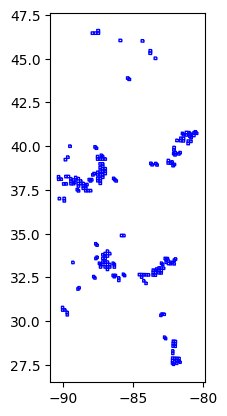

In [299]:
#us16_positive_embs_avg.to_file('us16_positive_embs_avg.shp')
us16T_negative_embs_avg.to_file('data/us16T_negative_embs_avg.shp')

fig, ax = plt.subplots()
us16_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


In [307]:
us17T_positive_embs_avg.to_file('data/us17T_positive_embs_avg.shp')
us17T_negative_embs_avg.to_file('data/us17T_negative_embs_avg.shp')

us17S_positive_embs_avg.to_file('data/us17S_positive_embs_avg.shp')
us17S_negative_embs_avg.to_file('data/us17S_negative_embs_avg.shp')

us17S_positive_embs_avg.to_file('data/us17R_positive_embs_avg.shp')
us17S_negative_embs_avg.to_file('data/us17R_negative_embs_avg.shp')

In [ ]:
# Get embeddings for pit lakes and no pit lakes present in US 16 from QA data
mine_embeddings_us16, non_mine_embeddings_us = GetEmbeddingsFromIntersection1_5(folder_path = 'data/US_v1_5/16', polygons = us_qa_pits_16, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_us16)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_us16, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/US_v1_5/16', polygons = us_qa_nonlakes_16, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_us16)}")

Number of images with mines: 1638
Number of negative mine images: 1502


In [44]:
# Combine Aquarry QA and DNR data to check for intersection

mn_qa_pits = mn_qa[mn_qa['category'] == 'a'] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")

# Get embedding files for pit lakes in MN in DNR or Aquarry dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_aggregated_pits, random_images = False)
print(f"Number of images with mines: {len(mine_embeddings_mn)}")

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)

# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]

#dnr_water_cropped = dnr_water_cropped[~dnr_water_cropped.geometry.intersects(crosby_mn.geometry.iloc[0])] # Remove any Crosby lakes

lake_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = dnr_water_cropped, random_images = False)
print(f"Number of images with water that's not mines: {len(lake_embeddings_mn)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_qa_nonlakes, random_images = False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_mn)}")

Number of images with mines: 125
Number of images with water that's not mines: 173
Number of negative mine images: 28


In [710]:
# DEPRECATED
# Make monthly aggregates
# USE IF GEOMETRIES DON'T OVERLAP TOO MUCH

def MonthlyComposite(embeddings_df):

    monthly_average_embeddings = gpd.GeoDataFrame()

    for zone in embeddings_df['grid_zone'].unique():
        zone_embeddings = pd.DataFrame(embeddings_df[embeddings_df['grid_zone'] == str(zone)])

        month_aggregate = gpd.GeoDataFrame()
        
        for index, row in zone_embeddings.iterrows():
             # Will need to adjust when more months are available
            chip_embeddings = gpd.read_parquet(row['file_path'])
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            month_aggregate = pd.concat([month_aggregate,chip_embeddings])

            grouped = month_aggregate.groupby('geometry')

            chip_embeddings_agg = grouped['embeddings'].apply(list).reset_index()
            chip_embeddings_agg_gdf = gpd.GeoDataFrame(chip_embeddings_agg, geometry='geometry')

            chip_embeddings_agg_gdf['monthly_average'] = chip_embeddings_agg_gdf['embeddings'].apply(
                lambda x: np.mean(np.vstack(x), axis=0))

            chip_embeddings_agg_gdf['grid_zone'] = zone
            chip_embeddings_agg_gdf['year_month'] = zone_embeddings['year_month'].iloc[0]

            monthly_average_embeddings = pd.concat([monthly_average_embeddings, chip_embeddings_agg_gdf])

    return monthly_average_embeddings


In [ ]:
us16_positive_embs_avg.to_file('us16_positive_embs_avg.shp')  
#us16_negative_embs_avg.to_file('us16_negative_embs_avg.shp')

In [ ]:
# Get monthly embeddings for pit lake embeddings in US
mine_embeddings_us16_df = pd.DataFrame(mine_embeddings_us16, columns = ['file_path','grid_zone','year_month'])

us16_positive_embs_avg = MonthlyComposite(mine_embeddings_us16_df, us_qa_pits_16)
print(len(us16_positive_embs_avg))

# Get monthly embeddings for water and non-pit lake embeddings in MN
#qa_non_mine_embeddings_us16_df = pd.DataFrame(qa_non_mine_embeddings_us16, columns = ['file_path','grid_zone','year_month'])

#us16_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_us16_df, us_qa_nonlakes_16)
#print(len(us16_negative_embs_avg))

added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
229
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added


KeyboardInterrupt: 

In [ ]:
# Get monthly embeddings for pit lake embeddings in US 17
mine_embeddings_us17_df = pd.DataFrame(mine_embeddings_us17, columns = ['file_path','grid_zone','year_month'])

us17_positive_embs_avg = MonthlyComposite(mine_embeddings_us17_df, us_qa_pits_17)
print(len(us17_positive_embs_avg))

# Get monthly embeddings for water and non-pit lake embeddings in MN
qa_non_mine_embeddings_us17_df = pd.DataFrame(qa_non_mine_embeddings_us17, columns = ['file_path','grid_zone','year_month'])

us17_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_us17_df, us_qa_nonlakes_17)
print(len(us17_negative_embs_avg))

us17_positive_embs_avg.to_file('us17_positive_embs_avg.shp')  
us17_negative_embs_avg.to_file('us17_negative_embs_avg.shp')

#### Arizona

In [ ]:
# Get embeddings for pit lakes and no pit lakes present in AZ

mine_embeddings_az, non_mine_embeddings_az = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_mines_intersect)

print("Number of images with mines:")
print(len(mine_embeddings_az))

In [46]:
# Get average of monthly embeddings for pit lake embeddings in AZ
mine_embeddings_az_df = pd.DataFrame(mine_embeddings_az, columns = ['file_path','grid_zone','year_month'])

az_positive_embs_avg = MonthlyComposite(mine_embeddings_az_df)
print(len(az_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
lake_embeddings_az_df = pd.DataFrame(lake_embeddings_az, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_az_df = pd.DataFrame(qa_non_mine_embeddings_az, columns = ['file_path','grid_zone','year_month'])

az_water_embs_avg = MonthlyComposite(lake_embeddings_az_df)
az_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_az_df)
print(len(az_water_embs_avg))
print(len(az_negative_embs_avg))

5868


KeyboardInterrupt: 

<Axes: >

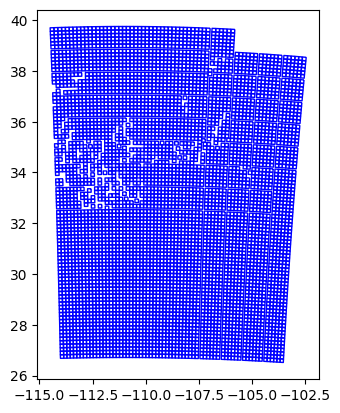

In [937]:
#Check overlap
fig, ax = plt.subplots()
az_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")

#az_negative_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


In [42]:
# Get embeddings for pit lakes and no pit lakes present in AZ from QA data

az_qa_pits = az_qa[az_qa['category'] == 'a'] # QAed pit lakes 
az_qa_nonlakes = az_qa[~az_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_az, non_mine_embeddings_az = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_qa_pits, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_az)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_az)}")


# Get embeddings for water bodies in AZ
az_lakes = gpd.read_file('data/az_lakes.txt')
lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/AZ_v1_5/', polygons = az_lakes, random_images=False)

print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of images with mines: 3010
Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of negative mine images: 3287
Skipping empty file: data/AZ_v1_5/UG\2024\8\S2A_12SUG_20240822_0_L2A\S2A_12SUG_20240822_0_L2A.parquet
Number of images with lakes: 1983


#### Indiana

In [993]:
# Get pit lakes in IN

states = gpd.read_file('data/state_boundaries')
indy = states[states['STUSPS']=='IN']
indy = indy.to_crs(epsg = 4326).geometry.unary_union

in_qa = US_QA[US_QA.geometry.intersects(indy)]
print(f'IN QAed mines: {(in_qa['category'] == 'a').sum()}')

IN QAed mines: 149


In [994]:
# Get embeddings for pit lakes and no pit lakes present in IN from QA data

in_qa_pits = in_qa[in_qa['category'] == 'a'] # QAed pit lakes 
in_qa_nonlakes = in_qa[~in_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_in, non_mine_embeddings_in = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = in_qa_pits, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_in)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_in, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = in_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_in)}")

# Get embeddings for water bodies in IN
#az_lakes = gpd.read_file('data/az_lakes.txt')
#lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = az_lakes, random_images=False)

#print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Number of images with mines: 176
Number of negative mine images: 153


In [995]:
# Get average of monthly embeddings for pit lake embeddings in IN
mine_embeddings_in_df = pd.DataFrame(mine_embeddings_in, columns = ['file_path','grid_zone','year_month'])

in_positive_embs_avg = MonthlyComposite(mine_embeddings_in_df)
print(len(in_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
#lake_embeddings_in_df = pd.DataFrame(lake_embeddings_in, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_in_df = pd.DataFrame(qa_non_mine_embeddings_in, columns = ['file_path','grid_zone','year_month'])

#az_water_embs_avg = MonthlyComposite(lake_embeddings_in_df)
in_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_in_df)
#print(len(in_water_embs_avg))
print(len(in_negative_embs_avg))

next zone
next zone
next zone
next zone
2296
next zone
next zone
next zone
next zone
2296


<Axes: >

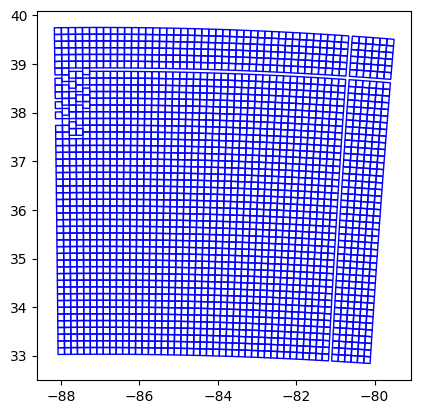

In [996]:
#Check mines chips
fig, ax = plt.subplots()
in_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


#### Kentucky

In [1074]:
# Get embeddings for pit lakes and no pit lakes present in IN from QA data

ky_qa_pits = ky_qa[ky_qa['category'] == 'a'] # QAed pit lakes 
ky_qa_nonlakes = ky_qa[~ky_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

mine_embeddings_ky, non_mine_embeddings_in = GetEmbeddingsFromIntersection1_5(folder_path = 'data/KY_v1_5/', polygons = ky_qa_pits, random_images=False)
print(f"Number of images with mines: {len(mine_embeddings_ky)}")

# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_ky, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/KY_v1_5/', polygons = ky_qa_nonlakes, random_images=False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_ky)}")

# Get embeddings for water bodies in IN
#az_lakes = gpd.read_file('data/az_lakes.txt')
#lake_embeddings_az, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/IN_v1_5/', polygons = az_lakes, random_images=False)

#print(f"Number of images with lakes: {len(lake_embeddings_az)}")

Number of images with mines: 207
Number of negative mine images: 203


In [1075]:
# Get average of monthly embeddings for pit lake embeddings in IN
mine_embeddings_ky_df = pd.DataFrame(mine_embeddings_ky, columns = ['file_path','grid_zone','year_month'])

ky_positive_embs_avg = MonthlyComposite(mine_embeddings_ky_df)
print(len(ky_positive_embs_avg))

# Get average of monthly embeddings for lake and features that aren't lakes in AZ
#lake_embeddings_in_df = pd.DataFrame(lake_embeddings_in, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_ky_df = pd.DataFrame(qa_non_mine_embeddings_ky, columns = ['file_path','grid_zone','year_month'])

#az_water_embs_avg = MonthlyComposite(lake_embeddings_in_df)
ky_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_ky_df)
#print(len(in_water_embs_avg))
print(len(ky_negative_embs_avg))

3578
3578


<Axes: >

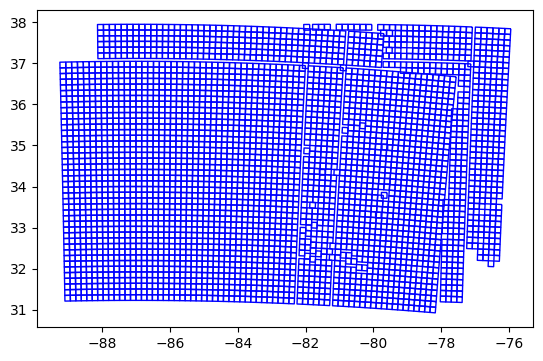

In [1076]:
#Check mines chips
fig, ax = plt.subplots()
ky_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")

#### Minnesota

In [122]:
mine_embeddings_mn_df

file_path grid_zone year_month
0    data/MN_v1_5/UJ\2024\7\S2A_15TUJ_20240712_0_L2...        UJ     2024_7
1    data/MN_v1_5/UJ\2024\7\S2A_15TUJ_20240722_0_L2...        UJ     2024_7
2    data/MN_v1_5/UJ\2024\7\S2B_15TUJ_20240707_0_L2...        UJ     2024_7
3    data/MN_v1_5/UJ\2024\7\S2B_15TUJ_20240717_0_L2...        UJ     2024_7
4    data/MN_v1_5/UJ\2024\7\S2B_15TUJ_20240727_0_L2...        UJ     2024_7
..                                                 ...       ...        ...
120  data/MN_v1_5/WM\2024\7\S2B_15TWM_20240727_0_L2...        WM     2024_7
121  data/MN_v1_5/WN\2024\7\S2A_15TWN_20240712_0_L2...        WN     2024_7
122  data/MN_v1_5/WN\2024\7\S2B_15TWN_20240707_0_L2...        WN     2024_7
123  data/MN_v1_5/WN\2024\7\S2B_15TWN_20240717_0_L2...        WN     2024_7
124  data/MN_v1_5/WN\2024\7\S2B_15TWN_20240727_0_L2...        WN     2024_7

[125 rows x 3 columns]

In [123]:
mn_aggregated_pits

cc                 objectid     score label      dataset  \
0     US  2024-04-25T10:16:26.374  0.979412     2  predictions   
1     US  2024-04-25T10:30:03.003  0.976188     2  predictions   
2     US  2024-04-25T10:03:04.066  0.970871     2  predictions   
3     US  2024-04-25T10:03:04.066  0.970871     2  predictions   
4     US  2024-04-25T10:02:11.148  0.968108     2  predictions   
..   ...                      ...       ...   ...          ...   
327  NaN                      NaN       NaN   NaN          NaN   
328  NaN                      NaN       NaN   NaN          NaN   
329  NaN                      NaN       NaN   NaN          NaN   
330  NaN                      NaN       NaN   NaN          NaN   
331  NaN                      NaN       NaN   NaN          NaN   

                   area    volume  \
0                    -1        -1   
1    1799831.5672383937  68115.02   
2    1441388.0862148742  48816.48   
3    1441388.0862148742  48816.48   
4     782988.5159378811  19544.66   
..                  ...       ...   
327                 NaN       NaN   
328                 NaN       NaN   
329                 NaN       NaN   
330                 NaN       NaN   
331                 NaN       NaN   

                                          wkb_geometry field_9 category  \
0    0103000020E6100000010000000500000000008012272F...       Y        a   
1    0103000020E610000001000000050000000000808D0E09...       Y        a   
2    0103000020E61000000100000005000000000000029B4B...       Y        a   
3    0103000020E61000000100000005000000000000029B4B...       Y        a   
4    0103000020E61000000100000005000000000080FDFE4D...       Y        a   
..                                                 ...     ...      ...   
327                                                NaN     NaN      NaN   
328                                                NaN     NaN      NaN   
329                                                NaN     NaN      NaN   
330                                                NaN     NaN      NaN   
331                                                NaN     NaN      NaN   

    field_11              wb_class    shape_Area  \
0         \N      Natural Ore Mine  3.970740e+04   
1         \N      Natural Ore Mine  2.188182e+05   
2         \N  Tac/Natural Ore Mine  1.724830e+06   
3         \N      Natural Ore Mine  5.817552e+04   
4         \N      Natural Ore Mine  5.742653e+04   
..       ...                   ...           ...   
327      NaN      Natural Ore Mine  4.423134e+05   
328      NaN      Natural Ore Mine  5.817552e+04   
329      NaN         Mine Pit Lake  1.035956e+04   
330      NaN      Natural Ore Mine  2.447072e+04   
331      NaN      Natural Ore Mine  2.399108e+05   

                                              geometry  
0    POLYGON ((-92.73942 47.51969, -92.7394 47.5196...  
1    POLYGON ((-92.16828 47.57218, -92.16826 47.572...  
2    MULTIPOLYGON (((-93.18134 47.37288, -93.18139 ...  
3    POLYGON ((-93.21809 47.36286, -93.21804 47.362...  
4    POLYGON ((-93.22559 47.35886, -93.22553 47.358...  
..                                                 ...  
327  POLYGON ((-92.98658 47.43136, -92.98662 47.431...  
328  POLYGON ((-93.21862 47.36327, -93.21855 47.363...  
329  POLYGON ((-96.21096 43.62744, -96.211 43.62749...  
330  POLYGON ((-93.08627 47.40465, -93.08621 47.404...  
331  POLYGON ((-92.60877 47.53517, -92.60868 47.535...  

[332 rows x 14 columns]

In [132]:
# Get monthly embeddings for pit lake embeddings in MN
mine_embeddings_mn_df = pd.DataFrame(mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_positive_embs_avg = MonthlyComposite(mine_embeddings_mn_df, mn_aggregated_pits)
print(len(mn_positive_embs_avg))

# Get monthly embeddings for water and non-pit lake embeddings in MN
lake_embeddings_mn_df = pd.DataFrame(lake_embeddings_mn, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_mn_df = pd.DataFrame(qa_non_mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_water_embs_avg = MonthlyComposite(lake_embeddings_mn_df, dnr_water_cropped)
mn_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_mn_df, mn_qa_nonlakes)
print(len(mn_water_embs_avg))
print(len(mn_negative_embs_avg))

added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
35
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
311
15


<Axes: >

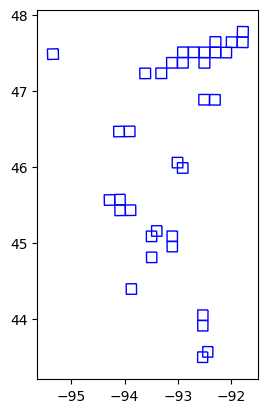

In [133]:
#Check overlap
fig, ax = plt.subplots()
mn_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")


In [150]:
# Get embeddings for pit lakes in MN in DNR dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = dnr_pit_lakes, random_images = False)

print(f"Number of images with mines: {len(mine_embeddings_mn)}")


Number of images with mines:
79


geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next z

#### Label embeddings with mine/no mine

In [ ]:
# Add buffer to make mine polygon
#buffered_mines = gpd.GeoDataFrame(geometry = mn_mines.buffer(0.02), crs=4326)

# Visualize buffer
#ax = buffered_mines.head().plot()
#cx.add_basemap(ax, crs=buffered_mines.crs, source=providers['NASAGIBS.BlueMarble'])

In [929]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False 
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive mask files
    negative_embeddings (GeoDataFrame): negative mask files

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    for emb in positive_embeddings:
        chip_embeddings = gpd.read_parquet(emb)
        chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
        positive_chips = gpd.sjoin(chip_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
        data = pd.concat([data, positive_chips], ignore_index=True)

    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings
    print("Number of positive samples:") 
    print(len(data))

    if polygons2.empty:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            chip_embeddings['mine'] = 0 # Assign 0 to mine column for chips without embeddings
            data = pd.concat([data, chip_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            negative_chips = gpd.sjoin(chip_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    return data

In [141]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips[~positive_chips['index_right'].isna()]
    print(len(positive_chips))

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips[~negative_chips['index_right'].isna()]
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])
    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    return data

In [683]:
data16 = LabelEmbeddings1_5(us16_positive_embs_avg, us16_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)
data17 = LabelEmbeddings1_5(us17_positive_embs_avg, us17_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)

us_data = pd.concat([data16, data17])

887
Number of positive samples: 229
601
Number of positive samples: 164


In [142]:
data16R = LabelEmbeddings1_5(us16R_positive_embs_avg, us16R_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)
data16S = LabelEmbeddings1_5(us16S_positive_embs_avg, us16S_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)
data16T = LabelEmbeddings1_5(us16T_positive_embs_avg, us16T_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)

print((data16R['mine'] == 1).sum())
print((data16S['mine'] == 1).sum())
print((data16T['mine'] == 1).sum())

170
Number of positive samples: 29
629
Number of positive samples: 152
339
Number of positive samples: 111
29
152
111


In [467]:
data17R = LabelEmbeddings1_5(us17R_positive_embs_avg, us17R_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)
data17S = LabelEmbeddings1_5(us17S_positive_embs_avg, us17S_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)
data17T = LabelEmbeddings1_5(us17T_positive_embs_avg, us17T_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)

print((data17R['mine'] == 1).sum())
print((data17S['mine'] == 1).sum())
print((data17T['mine'] == 1).sum())

157
Number of positive samples: 27
501
Number of positive samples: 146
146
Number of positive samples: 83
27
146
83


In [664]:
print(f'Positive samples: {(us_data['mine'] == 1).sum()}')
print(f'Negative samples: {(us_data['mine'] == 0).sum()}')

Positive samples: 393
Negative samples: 142


#### Arizona

In [321]:
# Get chips with mines and no mines in AZ from QA data
az_data = LabelEmbeddings(mine_embeddings_az, non_mine_embeddings_az, az_qa_lakes)
print(f"Total samples: {len(az_data)}") 


# Get chips with lakes in AZ
az_lakes_chips = LabelEmbeddings(dummy, lake_embeddings_az, gpd.GeoDataFrame(), az_lakes)
print(f"Total samples: {len(az_lakes_chips)}") 

az_data = pd.concat([az_data,az_lakes_chips], ignore_index=True) # Add lakes to AZ embeddings


# Get chips for features identified as not lakes from QA
az_nonlakes_chips = LabelEmbeddings(dummy, qa_non_mine_embeddings_az, gpd.GeoDataFrame(), az_qa_nonlakes)
print(f"Total samples: {len(az_nonlakes_chips)}") 

az_data = pd.concat([az_data,az_nonlakes_chips], ignore_index=True) # Add not pit lakes to AZ embeddings

Number of positive samples:
1431
Total samples: 4101958
Number of positive samples:
0
Total samples: 4132
Number of positive samples:
0
Total samples: 9228


In [673]:
# Get chips with pit lakes and non pit lakes in AZ 
az_data = LabelEmbeddings1_5(az_positive_embs_avg, az_negative_embs_avg, az_qa_pits, az_qa_nonlakes)

print("Total samples:") 
print(len(az_data))

# Get chips with regular bodies of eater
az_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

non_mines = az_add_data[az_add_data['mine'] == 0]

az_data = pd.concat([az_data, non_mines])
az_data = az_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(az_data))

Number of positive samples:
17
Total samples:
40
Number of positive samples:
0
Total samples:
44


In [3]:
# Get chips with mines and no mines in AZ
az_data = LabelEmbeddings(mine_embeddings_az, non_mine_embeddings_az, az_mines_intersect)

print("Total samples:") 
print(len(az_data))

NameError: name 'LabelEmbeddings' is not defined

#### Indiana and KY

In [997]:
# Get chips with pit lakes and non pit lakes in IN

in_data = LabelEmbeddings1_5(in_positive_embs_avg, in_negative_embs_avg, in_qa_pits, in_qa_nonlakes)

print("Total samples:") 
print(len(in_data))

# Get chips with regular bodies of eater
#in_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

#non_mines = az_add_data[az_add_data['mine'] == 0]
#in_data = pd.concat([in_data, non_mines])

in_data = in_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(in_data))

Number of positive samples:
23
Total samples:
31
Total samples:
31


In [1077]:
# Get chips with pit lakes and non pit lakes in KY 

ky_data = LabelEmbeddings1_5(ky_positive_embs_avg, ky_negative_embs_avg, ky_qa_pits, ky_qa_nonlakes)

print("Total samples:") 
print(len(ky_data))

# Get chips with regular bodies of eater
#in_add_data = LabelEmbeddings1_5(az_positive_embs_avg, az_water_embs_avg, dnr_pit_lakes, az_lakes)

#non_mines = az_add_data[az_add_data['mine'] == 0]
#in_data = pd.concat([in_data, non_mines])

ky_data = ky_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(ky_data))

Number of positive samples:
31
Total samples:
51
Total samples:
51


In [134]:
# Get chips with pit lakes and regular bodies of water in MN in DNR dataset
mn_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_water_embs_avg, dnr_pit_lakes, dnr_water_cropped)

print("Total samples:") 
print(len(mn_data))

# Add QA'ed non lakes
mn_add_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_negative_embs_avg, dnr_pit_lakes, mn_qa_nonlakes)

non_mines = mn_add_data[mn_add_data['mine'] == 0]

mn_data = pd.concat([mn_data, non_mines])
print("Total samples:") 
print(len(mn_data))

# Add in pit lakes that are only in the Aquarry QA dataset. Not removing the extra land area for now
intersecting_aquarry_dnr = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how='left', predicate='intersects').drop_duplicates('geometry')
aquarry_only_pits = mn_qa_pits[intersecting_aquarry_dnr['index_right'].isna()]
print(f'Pits only in QA dataset: {len(aquarry_only_pits)}')

mn_add_data = LabelEmbeddings1_5(mn_positive_embs_avg, mn_negative_embs_avg, aquarry_only_pits, mn_qa_nonlakes)

aquarry_mn_mines = mn_add_data[mn_add_data['mine'] == 1]

mn_data = pd.concat([mn_data, aquarry_mn_mines])
mn_data = mn_data.drop_duplicates('geometry')

print("Total samples:") 
print(len(mn_data))

Number of positive samples:
33
Total samples:
202
Number of positive samples:
33
Total samples:
214
Pits only in QA dataset: 32
Number of positive samples:
10
Total samples:
217


In [448]:
mn_data.to_crs(epsg=32615).iloc[0]

geometry        POLYGON ((599639.9999999998 5300039.999999999,...
embeddings      [-0.08174614, -0.28221804, 0.11511525, 0.05240...
grid_zone                                                      VN
year_month                                                 2024_7
chip_area                                                     NaN
area_overlap                                                  NaN
index__1                                                    64750
wb_class                                            Mine Pit Lake
shape_Area                                           1673687.1694
mine                                                            1
cc                                                            NaN
objectid                                                      NaN
score                                                         NaN
label                                                         NaN
dataset                                                       NaN
area      

15360.000000000087

### Rasterize polygons

In [33]:
# Define function that assigns corresponding polygons to each chip
from shapely.ops import unary_union

def GetPolygonsforChips(embeddings, pit_lakes):
    embeddings['pit_lake_poly'] = None
    embeddings = embeddings.reset_index(drop=True)

    for idx, chip in embeddings.iterrows():
            intersecting = pit_lakes[pit_lakes.intersects(chip['geometry'])]
            embeddings.at[idx, 'pit_lake_poly'] = intersecting['geometry'].tolist()     

    embeddings = embeddings[embeddings['pit_lake_poly'].apply(lambda x: len(x) > 0)] # drop empty rows
    embeddings['pit_lake_poly'] = embeddings['pit_lake_poly'].apply(lambda x: unary_union(x)) # Get multipolygons instead of a list
    embeddings['pit_lake_poly'] = gpd.GeoSeries(embeddings['pit_lake_poly'], crs = 4326).to_crs(epsg=32615) # Convert geometries to epsg:32615
    embeddings = embeddings.to_crs(epsg=32615) # Convert geometries to epsg:32615

    return embeddings

In [34]:
# Define function to take chip embeddings with corresponding polygons and rasterize
from rasterio.features import rasterize
from shapely.geometry import Polygon

def RasterizePolygons(data_with_polys):
    
    rasters = []

    for idx, chip in data_with_polys.iterrows():

        # Define raster dimensions based on chip's bounding box
        bounds = chip.geometry.bounds

        resolution = 10
        width = int((bounds[2] - bounds[0]) / resolution)
        height = int((bounds[3] - bounds[1]) / resolution)
        #width = 256
        #height = 256
        
        # Define raster transform
        transform = rasterio.transform.from_bounds(*bounds, width, height)
        
        # Create a list of geometries for rasterization
        geometries = [chip['pit_lake_poly']]
        print(geometries)
        print(height, width)
        
        # Rasterize the pit lakes
        chip_raster = rasterize(
            geometries,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        rasters.append(chip_raster)

    return rasters

In [35]:
def Createxarray(rasters, embs_with_polys):
    rasters_xr = []

    for i in range(len(rasters)):
        lon_min, lat_min, lon_max, lat_max = embs_with_polys.geometry[i].bounds

        # Generate latitude and longitude arrays
        latitudes = np.linspace(lat_max, lat_min, rasters[i].shape[0])
        longitudes = np.linspace(lon_min, lon_max, rasters[i].shape[1])

        # Create xarray DataArray
        data_array = xr.DataArray(
            rasters[i],
            dims=["lat", "lon"],
            coords={"lat": latitudes, "lon": longitudes},
            name="pit_lakes" 
        )

        # Create xarray Dataset
        dataset = xr.Dataset({"pit_lakes": data_array})
        rasters_xr.append(dataset)

    return rasters_xr


In [594]:
# Minnesota
chips_with_polygons = mn_data[mn_data['mine']==1] # Ensure this is right mn_data
chips_with_polygons = chips_with_polygons.drop_duplicates('geometry')
mn_data_with_polys = GetPolygonsforChips(chips_with_polygons, dnr_pit_lakes)

embs_with_polys = pd.concat([mn_data_with_polys,az_data_with_polys]).reset_index(drop=True)

# Aquarry mine testing
chips_with_polygons = aquarry_mn_mines.drop_duplicates('geometry')
aq_data_with_polys = GetPolygonsforChips(chips_with_polygons, aquarry_only_pits)
embs_with_polys = aq_data_with_polys
rasters = RasterizePolygons(embs_with_polys)
rasters_xr = Createxarray(rasters, embs_with_polys)

In [143]:
import xarray as xr

#us_data_mines = us_data[us_data['mine'] == 1]
#us_qa_pits1617 = pd.concat([us_qa_pits_16, us_qa_pits_17]).drop_duplicates('geometry')

#data16_mines = data16[data16['mine']==1]

us_data_mines = pd.concat([data16R, data16S, data16T]).drop_duplicates('geometry')

us_chips_with_polygons = us_data_mines.drop_duplicates('geometry')
us_embs_with_polys = GetPolygonsforChips(us_chips_with_polygons, us_qa_pits_16) # drops empty rows
us_rasters = RasterizePolygons(us_embs_with_polys)
us_embs_with_polys = us_embs_with_polys.reset_index(drop=True)
#us_rasters_xr = Createxarray(us_rasters, us_embs_with_polys) # Uncomment when running normally

[<MULTIPOLYGON (((776235.134 3389413.1, 776245.742 3388999.091, 775487.295 33...>]
1615 1615
[<MULTIPOLYGON (((789944.812 3396346.545, 790292.445 3396355.923, 790303.235 ...>]
1616 1616
[<MULTIPOLYGON (((817187.526 3371097.311, 817115.348 3371095.201, 817117.816 ...>]
1616 1616
[<MULTIPOLYGON (((820406.741 3369021.967, 821396.831 3369051.217, 821435.095 ...>]
1615 1615
[<POLYGON ((1506441.892 3253002.693, 1506297.985 3254634.401, 1504957.616 325...>]
1629 1629
[<MULTIPOLYGON (((1465811.125 3398784.954, 1465822.78 3398654.388, 1465282.47...>]
1631 1631
[<POLYGON ((1483526.387 3410393.948, 1482650.017 3410314.008, 1482552.56 3411...>]
1632 1632
[<MULTIPOLYGON (((1573247.912 3232197.692, 1573310.782 3231523.088, 1572755.4...>]
1631 1631
[<MULTIPOLYGON (((1572451.478 3230634.265, 1572365.434 3231558.531, 1573888.5...>]
1630 1630
[<MULTIPOLYGON (((1574123.245 3230739.146, 1575093.26 3230829.621, 1575215.67...>]
1630 1630
[<POLYGON ((1563578.145 3201977.174, 1563382.924 3204113.552, 1564592.

In [468]:
us_data_mines17 = pd.concat([data17R, data17S, data17T]).drop_duplicates('geometry')

us_chips_with_polygons17 = us_data_mines17.drop_duplicates('geometry')
us_embs_with_polys17 = GetPolygonsforChips(us_chips_with_polygons17, us_qa_pits_17) # drops empty rows
us_rasters17 = RasterizePolygons(us_embs_with_polys17)
us_embs_with_polys17 = us_embs_with_polys17.reset_index(drop=True)
us_rasters_xr17 = Createxarray(us_rasters17, us_embs_with_polys17) # Uncomment when running normally

[<MULTIPOLYGON (((1579110.01 3136013.214, 1579449.193 3136043.882, 1579489.47...>]
1704 1704
[<MULTIPOLYGON (((1596849.075 3135106.054, 1597390.145 3135155.752, 1597500.0...>]
1704 1704
[<POLYGON ((1608501.591 3135466.962, 1608406.479 3136491.739, 1607311.338 313...>]
1705 1705
[<POLYGON ((1570504.035 3116022.95, 1570438.407 3116760.088, 1569660.838 3116...>]
1702 1702
[<MULTIPOLYGON (((1579320.347 3116510.89, 1578370.576 3116425.68, 1578318.132...>]
1703 1703
[<MULTIPOLYGON (((1591299.316 3117756.847, 1590610.076 3117694.3, 1590566.71 ...>]
1704 1704
[<MULTIPOLYGON (((1602790.294 3119555.415, 1602892.92 3118437.015, 1601960.87...>]
1705 1705
[<POLYGON ((1570504.035 3116022.95, 1570438.407 3116760.088, 1569660.838 3116...>]
1702 1702
[<MULTIPOLYGON (((1578137.285 3102213.528, 1578221.009 3101274.536, 1577669.0...>]
1703 1703
[<MULTIPOLYGON (((1594817.33 3103665.479, 1594315.521 3103620.036, 1594270.93...>]
1703 1703
[<MULTIPOLYGON (((1605407.867 3111248.862, 1605456.667 3110716.656, 16

### NDWI Filtering

In [37]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()
    print(len(all_items))

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")
    return items, dates

In [39]:
# Retrieve the pixel values, for the bounding box in the target projection.


def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []

        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:32615')
        #bounds_gdf = bounds_gdf.to_crs(epsg=epsg)
        transformed_bbox = bounds_gdf.geometry[0].bounds

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=32615,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            stack = stack.compute()
        
    return stack


In [40]:
# Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

In [41]:
def FilterRasters(rasters, embs_with_polys):
    # Date range
    start = "2024-07-01"    
    end = "2024-09-15"

    for i in range(len(rasters)):
        
        #Get NDWI
        aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326)[i] 
        bounds = embs_with_polys['geometry'][i]    # Should be in epsg:32615

        ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

        try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

            # Compute mask
            water_mask = xr.where(ndwi_summer > 0.1, 1, 0)

            # Account for small differences
            # Create new evenly spaced coordinates and interploate
            if water_mask.x.shape[0] != water_mask.y.shape[0]:
                new_coords = np.linspace(water_mask.coords['x'][0], water_mask.coords['x'][-2], water_mask.x.shape[0])

                water_mask_resampled = water_mask.interp(x=new_coords)
            else:
                water_mask_resampled = water_mask

            # Rename coords to match
            water_mask_resampled = water_mask_resampled.rename({'y': 'lat', 'x': 'lon'})
            print(water_mask_resampled.sum().values)
            # Resample to make water mask match 

            water_mask_resampled = water_mask_resampled.interp(lat=rasters[i]['pit_lakes']['lat'].values,lon=rasters[i]['pit_lakes']['lon'].values, method='nearest')

            print(water_mask_resampled.sum().values)
    
            mask = (rasters[i]['pit_lakes'] == 1).compute()
            print(mask.sum().values)

            rasters[i]['filtered_pit_lakes'] = rasters[i]['pit_lakes']
            rasters[i]['filtered_pit_lakes'] = xr.where(mask, water_mask_resampled, rasters[i]['pit_lakes'])
            print(rasters[i]['filtered_pit_lakes'].shape)
            print(rasters[i]['filtered_pit_lakes'].sum().values)

        except RuntimeError as e:
            print(f'Error filtering raster {i}')
            continue
        
        except AttributeError:
            print(f'No images found for {i}')
            continue

    return rasters

In [904]:
testers = us_rasters_xr[4:6]
embs_testers = us_embs_with_polys[4:6].reset_index(drop=True)
tester_results = FilterRasters(testers, embs_testers)


0
Found 0 items
No images found for 0
4
Found 3 items
crs:32617
1265
1265.0
13501
(1612, 1612)
581.0


In [43]:
# Get filtered polygons for US
us_results = FilterRasters(us_rasters_xr, us_embs_with_polys)


13
Found 7 items
18741
18724.0
36027
(1615, 1615)
7441.0
13
Found 7 items
26894
26795.0
19632
(1616, 1616)
3198.0
6
Found 5 items
64775
64662.0
73886
(1616, 1616)
21844.0
6
Found 5 items
35213.790712073926
35042.20804953518
35216
(1615, 1615)
8088.344891640846
0
Found 0 items
No images found for 4
4
Found 3 items
1171
1171.0
13819
(1631, 1631)
596.0
1
Found 1 items
152568.3710961424
152137.6546233927
12048
(1632, 1632)
1724.271279852651
1
Found 1 items
46329.37071078332
46022.92708333244
6866
(1631, 1631)
2539.954044117662
0
Found 0 items
No images found for 8
1
Found 1 items
29849
29730.0
29495
(1630, 1630)
0.0
0
Found 0 items
No images found for 10
1
Found 1 items
3348
3305.0
16682
(1630, 1630)
1370.0
0
Found 0 items
No images found for 12
0
Found 0 items
No images found for 13
0
Found 0 items
No images found for 14
1
Found 1 items
682.4186617556262
682.418661755626
154419
(1629, 1629)
0.0
1
Found 1 items
1009
1009.0
68098
(1629, 1629)
0.0
0
Found 0 items
No images found for 17
0
Fou

In [470]:
us_results17 = FilterRasters(us_rasters_xr17, us_embs_with_polys17)

0
Found 0 items
No images found for 0
1
Found 1 items
46825
46428.0
33533
(1704, 1704)
0.0
1
Found 1 items
295724.34369501367
294366.44046920736
11308
(1705, 1705)
0.0
0
Found 0 items
No images found for 3
0
Found 0 items
No images found for 4
0
Found 0 items
No images found for 5
0
Found 0 items
No images found for 6
0
Found 0 items
No images found for 7
0
Found 0 items
No images found for 8
0
Found 0 items
No images found for 9
0
Found 0 items
No images found for 10
0
Found 0 items
No images found for 11
0
Found 0 items
No images found for 12
0
Found 0 items
No images found for 13
0
Found 0 items
No images found for 14
0
Found 0 items
No images found for 15
1
Found 1 items
72285
72243.0
16199
(1708, 1708)
2555.0
0
Found 0 items
No images found for 17
1
Found 1 items
12289
12181.0
16687
(1707, 1707)
1390.0
0
Found 0 items
No images found for 19
0
Found 0 items
No images found for 20
0
Found 0 items
No images found for 21
4
Found 3 items
137.08007013441525
137.08007013441528
1117
(1710

In [573]:
# Resample to 1536x1536
#changed to 256
def TrainingResample(rasters):
    rasters_list = []

    for i in range(len(rasters)):
        lat_min = float(rasters[i]['filtered_pit_lakes']['lat'].min().values)
        lat_max = float(rasters[i]['filtered_pit_lakes']['lat'].max().values)
        lon_min = float(rasters[i]['filtered_pit_lakes']['lon'].min().values)
        lon_max = float(rasters[i]['filtered_pit_lakes']['lon'].max().values)
        new_lat = np.linspace(lat_min, lat_max, 256)
        new_lon = np.linspace(lon_min, lon_max, 256)

        # Interpolate to the new grid
        resampled = rasters[i]['filtered_pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
        rasters_list.append(resampled)

    return rasters_list

[3384007.66018465 3384018.18569759 3384028.71121054 ... 3400143.27152643
 3400153.79703937 3400164.32255231]
[3384825.57796043 3384836.1058209  3384846.63368137 ... 3400964.78805918
 3400975.31591965 3400985.84378012]
[3370301.41102546 3370311.93924194 3370322.46745842 ... 3386441.16688652
 3386451.695103   3386462.22331947]
[3354958.78539188 3354969.31160961 3354979.83782734 ... 3371095.47716973
 3371106.00338746 3371116.52960518]
[3397697.10772192 3397707.73867098 3397718.36962004 ... 3413994.35262943
 3414004.98357849 3414015.61452754]
[3398526.84066175 3398537.47414047 3398548.10761918 ... 3414827.96352855
 3414838.59700726 3414849.23048597]
[3232126.02829065 3232136.65490698 3232147.28152331 ... 3248416.63112134
 3248427.25773767 3248437.884354  ]
[3201098.22098492 3201108.8437555  3201119.46652607 ... 3217382.92827526
 3217393.55104583 3217404.17381641]
[3124290.86055527 3124301.47623407 3124312.09191287 ... 3140564.6961507
 3140575.31182949 3140585.92750829]
[3389365.40493191 33

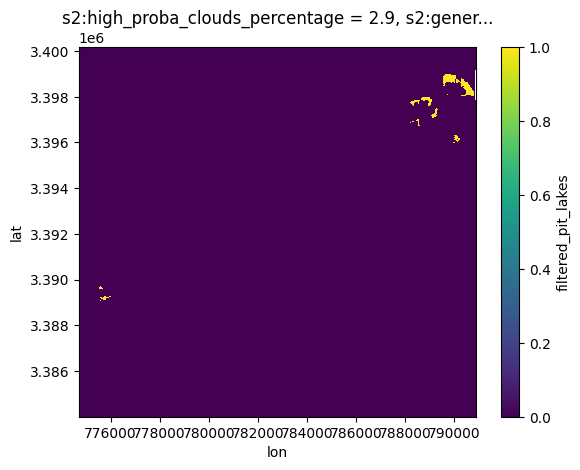

In [54]:
# Get only those with results and resize
filtered_results = [xr for xr in us_results if 'filtered_pit_lakes' in xr.data_vars] # If images were found
filtered_results = [arr for arr in filtered_results if arr['filtered_pit_lakes'].values.any()] # If array is non 0

resampled_us = TrainingResample(filtered_results)
resampled_us[0].plot()

[3384007.66018465 3384071.01964492 3384134.37910518 3384197.73856545
 3384261.09802571 3384324.45748598 3384387.81694624 3384451.17640651
 3384514.53586677 3384577.89532704 3384641.2547873  3384704.61424757
 3384767.97370783 3384831.3331681  3384894.69262836 3384958.05208863
 3385021.4115489  3385084.77100916 3385148.13046943 3385211.48992969
 3385274.84938996 3385338.20885022 3385401.56831049 3385464.92777075
 3385528.28723102 3385591.64669128 3385655.00615155 3385718.36561181
 3385781.72507208 3385845.08453234 3385908.44399261 3385971.80345288
 3386035.16291314 3386098.52237341 3386161.88183367 3386225.24129394
 3386288.6007542  3386351.96021447 3386415.31967473 3386478.679135
 3386542.03859526 3386605.39805553 3386668.75751579 3386732.11697606
 3386795.47643632 3386858.83589659 3386922.19535686 3386985.55481712
 3387048.91427739 3387112.27373765 3387175.63319792 3387238.99265818
 3387302.35211845 3387365.71157871 3387429.07103898 3387492.43049924
 3387555.78995951 3387619.14941977 3

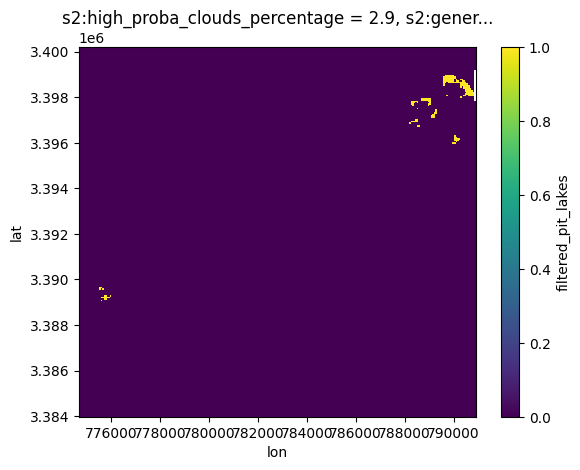

In [572]:
# Get only those with results and resize
filtered_results17 = [xr for xr in us_results17 if 'filtered_pit_lakes' in xr.data_vars] # If images were found
filtered_results17 = [arr for arr in filtered_results17 if arr['filtered_pit_lakes'].values.any()] # If array is non 0

resampled_us17 = TrainingResample(filtered_results)
resampled_us17[0].plot()

In [75]:
# Initialize an empty list to store indices
final_indices = []
us_embs_with_polys_reset = us_embs_with_polys.reset_index(drop=True) # THIS MAY BE INCORRECT

# Iterate through us_results with indices
for i, xr in enumerate(us_results):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

# Step 3: Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped = us_embs_with_polys_reset.loc[final_indices]
print(len(us_embs_with_polys_dropped))
print(len(resampled_us))

# `us_embs_with_polys_dropped` excludes rows matching the filtered indices


198
198


In [574]:
final_indices = []
us_embs_with_polys_reset17 = us_embs_with_polys17.reset_index(drop=True) # THIS MAY BE INCORRECT

# Iterate through us_results with indices
for i, xr in enumerate(us_results17):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results17_clean = [xr for i, xr in enumerate(us_results17) if i in final_indices]

resampled_us17 = TrainingResample(us_results17_clean)

# Step 3: Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped17 = us_embs_with_polys_reset17.loc[final_indices]
print(len(us_embs_with_polys_dropped17))
print(len(resampled_us17))

# `us_embs_with_polys_dropped` excludes rows matching the filtered indices


178
178


In [571]:
import xarray as xr
import rioxarray as rxr

summer_composite = stack.groupby('band').median(dim = 'time')
ndwi_summer = CalculateNDWI(summer_composite)

water_mask = xr.where(ndwi_summer > 0.1, 1, 0)
water_mask.shape

# Account for small differences
# Create new evenly spaced coordinates for the second dimension
new_coords = np.linspace(water_mask.coords['x'][0], water_mask.coords['x'][-2], 1536)

# Interpolate along the second dimension
water_mask_resampled = water_mask.interp(x=new_coords)
water_mask_resampled.shape

water_mask_resampled = water_mask_resampled.rename({'y': 'lat', 'x': 'lon'})

dataset['test_pit_lakes_filtered'] = dataset['test_pit_lakes']

#
water_mask_resampled = water_mask_resampled.interp(lat=dataset['test_pit_lakes_filtered']['lat'],lon=dataset['test_pit_lakes_filtered']['lon'], method='nearest')

#water_mask_resampled, dataset['test_pit_lakes_filtered'] = xr.align(water_mask_resampled, dataset['test_pit_lakes_filtered'], join='override')
mask = (dataset['test_pit_lakes_filtered'] == 1).compute()

print(water_mask_resampled.shape)
print(dataset['test_pit_lakes_filtered'].shape)
print(mask.shape)

dataset['test_pit_lakes_filtered'] = xr.where(mask, water_mask_resampled, dataset['test_pit_lakes_filtered'])
dataset['test_pit_lakes_filtered']

In [ ]:
# Separate into seasonal
q1stack, q1dates = SearchSTAC(aoi,"2024-01-01", "2024-03-31")
q2stack, q2dates = SearchSTAC(aoi,"2024-04-01", "2024-06-30")
q3stack, q3dates = SearchSTAC(aoi,"2024-07-01", "2024-09-30")
q4stack, q4dates = SearchSTAC(aoi,"2024-10-01", "2024-12-31")

stack1 = RetrievePixels(q1stack)
stack2 = RetrievePixels(q2stack)
stack3 = RetrievePixels(q3stack)
stack4 = RetrievePixels(q4stack)

In [ ]:
# Get median of values across time for different bands for each season
import xarray as xr

q1_composite = stack1.groupby('band').median(dim = 'time')
q2_composite = stack2.groupby('band').median(dim = 'time')
q3_composite = stack3.groupby('band').median(dim = 'time')
q4_composite = stack4.groupby('band').median(dim = 'time')


ndwi_q1 = CalculateNDWI(q1_composite)
ndwi_q2 = CalculateNDWI(q2_composite)
ndwi_q3 = CalculateNDWI(q3_composite)
ndwi_q4 = CalculateNDWI(q4_composite)

ndwi_ds = [ndwi_q1, ndwi_q2, ndwi_q3, ndwi_q4]

for i in range(len(ndwi_ds)):
    if 's2:processing_baseline' in ndwi_ds[i].coords:
        ndwi_ds[i] = ndwi_ds[i].reset_coords('s2:processing_baseline', drop=True)
        
annual_median = xr.concat(ndwi_ds, dim="time").median(dim='time')



In [ ]:
lat_min = float(tester_results[0]['filtered_pit_lakes']['lat'].min().values)
lat_max = float(tester_results[0]['filtered_pit_lakes']['lat'].max().values)
lon_min = float(tester_results[0]['filtered_pit_lakes']['lon'].min().values)
lon_max = float(tester_results[0]['filtered_pit_lakes']['lon'].max().values)
new_lat = np.linspace(lat_min, lat_max, 1536)
new_lon = np.linspace(lon_min, lon_max, 1536)

resampled = tester_results[0]['filtered_pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
#tester_results[0]['resampled'] = resampled
#tester_results[0]['resampled']
resampled

<xarray.DataArray 'filtered_pit_lakes' (lat: 1536, lon: 1536)> Size: 19MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates: (12/46)
    s2:medium_proba_clouds_percentage        float64 8B 3.374
    earthsearch:s3_path                      <U79 316B 's3://sentinel-cogs/se...
    s2:not_vegetated_percentage              float64 8B 3.916
    earthsearch:boa_offset_applied           bool 1B True
    s2:generation_time                       <U27 108B '2024-07-30T23:48:51.0...
    mgrs:utm_zone                            int32 4B 16
    ...                                       ...
    gsd                                      int32 4B 10
    proj:transform                           object 8B {0, 10, 199980, 340002...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    epsg                                     int32 4B 32615
  * lat                                      (lat) float64 12kB 3.244e+06 ......
  * lon                                      (lon) float64 12kB 1.501e+06 ......

### Train a CNN to predict pixel masks

In [486]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256)):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 128)  # 8x8 feature map with 128 channels

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)   # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)    # 64x64 -> 128x128
        self.deconv5 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1)     # 128x128 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions
        x = F.relu(self.deconv1(x))  # 16x16
        x = F.relu(self.deconv2(x))  # 32x32
        x = F.relu(self.deconv3(x))  # 64x64
        x = F.relu(self.deconv4(x))  # 128x128
        x = self.deconv5(x) 
        
        return x


In [483]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, num_classes=10):  # Replace 10 with the actual number of classes
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 128)  # 8x8 feature map with 128 channels

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)   # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)    # 64x64 -> 128x128
        self.deconv5 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1)     # 128x128 -> 256x256

        # Classification layer
        self.classifier = nn.Linear(256 * 256, num_classes)  # Flattened 256x256 feature map for classification

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions
        x = F.relu(self.deconv1(x))  # 16x16
        x = F.relu(self.deconv2(x))  # 32x32
        x = F.relu(self.deconv3(x))  # 64x64
        x = F.relu(self.deconv4(x))  # 128x128
        x = self.deconv5(x)          # 256x256

        # Flatten the output and pass it through the classifier
        x = x.view(x.size(0), -1)    # Flatten to (batch_size, 256*256)
        x = self.classifier(x)       # (batch_size, num_classes)

        return x


In [252]:
from torch.utils.data import Dataset

class EmbeddingRasterDataset(Dataset):
    """
        Initializes the dataset with inputs (embeddings) and targets (rasters).

        Args:
            embeddings (numpy.ndarray or torch.Tensor): Input embeddings, shape (num_samples, 1024).
            rasters (numpy.ndarray or torch.Tensor): Target rasters, shape (num_samples, 256, 256).
    """
    def __init__(self, embeddings, rasters):
        self.embeddings = embeddings
        self.rasters = rasters

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        raster = self.rasters[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(raster, dtype=torch.float32)


In [599]:
# Prep training data
mn_embs_array = np.vstack(mn_data_with_polys['embeddings'])
mn_raster_array = np.stack(mn_rasters)

#mn_water_embs_array = np.vstack(

mn_cnn_train_data = EmbeddingRasterDataset(mn_embs_array, mn_raster_array)

In [843]:
# Prep training data
#sampled = raster_array[index]
index = sorted(random.sample(range(0, len(rasters)),3))

train_embs_with_polys = embs_with_polys.drop(index = index)
train_embs_array = np.vstack(train_embs_with_polys)
train_raster_array = np.stack([item for idx, item in enumerate(rasters) if idx not in index])

test_embs_array = np.vstack(embs_with_polys['embeddings'][index])
test_raster_array = np.stack([item for idx, item in enumerate(rasters) if idx in index])
test_embs_with_polys = embs_with_polys.iloc[index]

cnn_train_data = EmbeddingRasterDataset(train_embs_array, train_raster_array)

In [ ]:
# Replacing after kernel crash
replacements = gpd.GeoDataFrame(us_embs_with_polys['embeddings'], columns = ['embeddings'], geometry = us_embs_with_polys.geometry)
replacements = replacements.rename(columns = {'embeddings': 'embeddings_array'})
print(replacements.head())

#for us_embs_with_polys_dropped, add a column - embeddings_array

us_embs_with_polys_dropped_aug = gpd.sjoin(us_embs_with_polys_dropped, replacements, how = 'left', predicate = 'intersects').drop_duplicates('geometry')

                                    embeddings_array  \
0  [-0.0017824013, -0.19028033, 0.193378, 0.01987...   
1  [-0.040662702, -0.19212694, 0.09648246, 0.0863...   
2  [-0.01054003, -0.24681692, 0.1284781, 0.058189...   
3  [0.06892806, -0.16768734, 0.26177645, -0.08068...   
4  [-0.08364563, 0.14365195, -0.59203213, -0.2433...   

                                            geometry  
0  POLYGON ((790054.038 3400164.323, 790873.757 3...  
1  POLYGON ((805394.314 3400985.844, 806214.304 3...  
2  POLYGON ((821558.19 3386462.223, 822375.117 33...  
3  POLYGON ((822375.117 3371116.53, 823188.701 33...  
4  POLYGON ((1516534.692 3260341.977, 1517333.12 ...  


In [294]:
index_to_drop = us_embs_with_polys_dropped_aug[us_embs_with_polys_dropped_aug['embeddings_array'].isna() == True].index[0]
us_embs_with_polys_dropped_aug = us_embs_with_polys_dropped_aug.drop(index = index_to_drop)

resampled_us_dropped = resampled_us[:index_to_drop] + resampled_us[index_to_drop+1:]

print(len(resampled_us_dropped))
print(len(us_embs_with_polys_dropped_aug))


197
197


In [534]:
# 16
resampled_us_256 = TrainingResample(filtered_results)

index_to_drop = us_embs_with_polys_dropped_aug[us_embs_with_polys_dropped_aug['embeddings_array'].isna() == True].index[0]
us_embs_with_polys_dropped_aug = us_embs_with_polys_dropped_aug.drop(index = index_to_drop)

resampled_us_dropped_256 = resampled_us_256[:index_to_drop] + resampled_us_256[index_to_drop+1:]

print(len(resampled_us_dropped_256))
print(len(us_embs_with_polys_dropped_aug))


197
197


In [579]:
# 17

# Index dropping was artifact of losing kernel
#index_to_drop = us_embs_with_polys_dropped17[us_embs_with_polys_dropped17['embeddings'].isna() == True].index[0]
#us_embs_with_polys_dropped17_aug = us_embs_with_polys_dropped17.drop(index = index_to_drop)

#resampled_us17_dropped = resampled_us17[:index_to_drop] + resampled_us17[index_to_drop+1:]

#print(len(resampled_us17_dropped))
#print(len(us_embs_with_polys_dropped17_aug))

resampled_us17_np = resampled_us17
for i in range(len(resampled_us17)):
    resampled_us17_np[i] = np.array(resampled_us17[i])

resampled_us17_np = np.where(np.isnan(resampled_us17_np), 0, resampled_us17_np) 
resampled_us17_np = np.round_(resampled_us17_np)
resampled_us17_np = np.int_(resampled_us17_np)

In [595]:
np.vstack(us_embs_with_polys_dropped17['embeddings']).shape

(178, 1024)

In [596]:
#17
us_embs_with_polys_dropped17 = us_embs_with_polys_dropped17.reset_index(drop=True)

index = sorted(random.sample(range(0, len(us_embs_with_polys_dropped17)), 25))

train_embs_with_polys17 = us_embs_with_polys_dropped17.drop(index = index)
train_embs_array17 = np.vstack(train_embs_with_polys17['embeddings'])
train_raster_array17 = np.stack([item for idx, item in enumerate(resampled_us17_np) if idx not in index])

test_embs_with_polys17 = us_embs_with_polys_dropped17.iloc[index]
test_embs_array17 = np.vstack(us_embs_with_polys_dropped17['embeddings'][index])
test_raster_array17 = np.stack([item for idx, item in enumerate(resampled_us17_np) if idx in index])

In [ ]:
# 17
# Initialize a list to track valid indices where the sum of the slice is >= 65
valid_indices = []

# Iterate through each 256x256 slice in 'array'
for i in range(train_raster_array_filled_r.shape[0]):
    if np.sum(train_raster_array_filled_r[i]) >= 65:
        valid_indices.append(i)

# Convert valid_indices to numpy array (optional)
valid_indices = np.array(valid_indices)

# Filter 'array' and 'train_embs_array' using valid_indices
filtered_raster_array = train_raster_array_filled_r[valid_indices]
filtered_train_embs_array = train_embs_array[valid_indices]
filtered_train_embs_with_polys = train_embs_with_polys.iloc[valid_indices]

print("Shape of filtered array:", filtered_raster_array.shape)
print("Shape of filtered train_embs_array:", filtered_train_embs_array.shape)


In [295]:
resampled_us_np = resampled_us_dropped
#us_embs_with_polys_dropped = us_embs_with_polys_dropped.reset_index(drop=True)
us_embs_with_polys_dropped_aug = us_embs_with_polys_dropped_aug.reset_index(drop=True)


for i in range(len(resampled_us_dropped)):
    resampled_us_np[i] = np.array(resampled_us_dropped[i])

index = sorted(random.sample(range(0, len(resampled_us_dropped)), 50))

train_embs_with_polys = us_embs_with_polys_dropped_aug.drop(index = index)
train_embs_array = np.vstack(train_embs_with_polys['embeddings_array'])
train_raster_array = np.stack([item for idx, item in enumerate(resampled_us_np) if idx not in index])

test_embs_with_polys = us_embs_with_polys_dropped_aug.iloc[index]
test_embs_array = np.vstack(us_embs_with_polys_dropped_aug['embeddings_array'][index])
test_raster_array = np.stack([item for idx, item in enumerate(resampled_us_np) if idx in index])

In [824]:
# 16, resampled to 256

resampled_us_np = resampled_us_dropped_256
resampled_us_np = np.where(np.isnan(resampled_us_np), 0, resampled_us_np) 
resampled_us_np = np.round_(resampled_us_np)
resampled_us_np = np.int_(resampled_us_np)
#us_embs_with_polys_dropped = us_embs_with_polys_dropped.reset_index(drop=True)
us_embs_with_polys_dropped_aug = us_embs_with_polys_dropped_aug.reset_index(drop=True)


for i in range(len(resampled_us_dropped_256)):
    resampled_us_np[i] = np.array(resampled_us_dropped_256[i])

index = sorted(random.sample(range(0, len(resampled_us_dropped_256)), 25))

train_embs_with_polys16 = us_embs_with_polys_dropped_aug.drop(index = index)
train_embs_array16 = np.vstack(train_embs_with_polys['embeddings_array'])
train_raster_array16 = np.stack([item for idx, item in enumerate(resampled_us_np) if idx not in index])

test_embs_with_polys16 = us_embs_with_polys_dropped_aug.iloc[index]
test_embs_array16 = np.vstack(us_embs_with_polys_dropped_aug['embeddings_array'][index])
test_raster_array16 = np.stack([item for idx, item in enumerate(resampled_us_np) if idx in index])

train_raster_array_filled16 = np.where(np.isnan(train_raster_array), 0, train_raster_array) 
train_raster_array_filled_r16 = np.round_(train_raster_array_filled16)
train_raster_array_filled_r16 = np.int_(train_raster_array_filled_r16)

test_raster_array16 = np.round_(test_raster_array16)
test_raster_array16 = np.int_(test_raster_array16)

In [830]:
# Control for error
test_raster_array16 = np.where(test_raster_array16 == -2147483648, 0, test_raster_array16) 

np.unique(test_raster_array16, return_counts = True)

(array([0, 1]), array([1636868,    1532], dtype=int64))

In [851]:
train_embs_array1617 = np.concatenate((train_embs_array16, train_embs_array17), axis=0)
train_raster_array1617 = np.concatenate((train_raster_array_filled_r16, train_raster_array17), axis=0)

test_raster_array1617 = np.concatenate((test_raster_array16, test_raster_array17), axis = 0)
test_embs_array1617 = np.concatenate((test_embs_array16, test_embs_array17), axis = 0)

test_embs_with_polys1617 = pd.concat([test_embs_with_polys16, test_embs_with_polys17])

print(train_embs_array1617.shape)
print(test_raster_array1617.shape)

(325, 1024)
(50, 256, 256)


In [832]:
cnn_train_data = EmbeddingRasterDataset(train_embs_array1617, train_raster_array1617)

print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array.shape)

(325, 1024)
(325, 256, 256)
(25, 256, 256)


In [585]:
# 16
cnn_train_data = EmbeddingRasterDataset(train_embs_array, train_raster_array_filled_r)

print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array.shape)

print(np.isnan(train_raster_array_filled[0]).sum())
#np.isnan(filtered_results[0]['filtered_pit_lakes'].values).sum()


(172, 1024)
(172, 256, 256)
(25, 256, 256)
0


In [ ]:
# Initialize a list to track valid indices where the sum of the slice is >= 65
valid_indices = []

# Iterate through each 256x256 slice in 'array'
for i in range(train_raster_array1617.shape[0]):
    if np.sum(train_raster_array1617[i]) >= 65:
        valid_indices.append(i)

# Convert valid_indices to numpy array (optional)
valid_indices = np.array(valid_indices)

# Filter 'array' and 'train_embs_array' using valid_indices
filtered_raster_array = train_raster_array1617[valid_indices]
filtered_train_embs_array = train_embs_array1617[valid_indices]
filtered_train_embs_with_polys = train_embs_with_polys1617.iloc[valid_indices]

print("Shape of filtered array:", filtered_raster_array.shape)
print("Shape of filtered train_embs_array:", filtered_train_embs_array.shape)


Shape of filtered array: (32, 256, 256)
Shape of filtered train_embs_array: (32, 1024)


In [559]:
cnn_train_data = EmbeddingRasterDataset(filtered_train_embs_array, filtered_raster_array)


print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array.shape)

(172, 1024)
(172, 25)
(172, 256, 256)
(25, 1024)
(25, 25)
(25, 256, 256)


764.1180356117175
Epoch 1/30, Avg Loss: 1.0745272907343777
Epoch 2/30, Avg Loss: 0.9627334836757544
Epoch 3/30, Avg Loss: 0.9288677528049006
Epoch 4/30, Avg Loss: 0.8506461833462571
Epoch 5/30, Avg Loss: 0.7767597238222758
Epoch 6/30, Avg Loss: 0.6881082157293955
Epoch 7/30, Avg Loss: 0.6529058958544876
Epoch 8/30, Avg Loss: 0.5877212656266761
Epoch 9/30, Avg Loss: 0.5511046061010072
Epoch 10/30, Avg Loss: 0.5416173289219538
Epoch 11/30, Avg Loss: 0.5214670630115451
Epoch 12/30, Avg Loss: 0.5044607109192646
Epoch 13/30, Avg Loss: 0.4845073281815558
Epoch 14/30, Avg Loss: 0.4678951262524634
Epoch 15/30, Avg Loss: 0.4536330695405151
Epoch 16/30, Avg Loss: 0.4545954316854477
Epoch 17/30, Avg Loss: 0.44190307367931714
Epoch 18/30, Avg Loss: 0.43798572186267737
Epoch 19/30, Avg Loss: 0.4257817354166146
Epoch 20/30, Avg Loss: 0.42123839259147644
Epoch 21/30, Avg Loss: 0.416772773771575
Epoch 22/30, Avg Loss: 0.40011316402391955
Epoch 23/30, Avg Loss: 0.41490645209948224
Epoch 24/30, Avg Loss

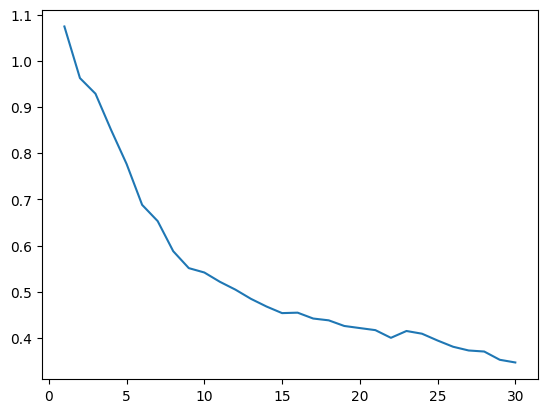

In [861]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming embeddings and rasters are numpy arrays of shape (num_samples, 1024) and (num_samples, 256, 256)
dataloader = DataLoader(cnn_train_data, batch_size=10, shuffle=True)

# Initialize model, loss, and optimizer
model = EmbeddingToRasterCNN().to(device)
num_positives = train_raster_array1617.sum()
num_negatives = train_raster_array1617.size - num_positives  # Total pixels - positives
#class_weight = min(num_negatives / num_positives, 100)  # Cap the weight
class_weight = (num_negatives / num_positives)/2
print(class_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # Initialize biases to zero

model.apply(init_weights)


# Debugging
torch.autograd.set_detect_anomaly(False)

def check_for_nans(module, input, output):
    print(f"Checking {module}")
    print(f"Output has NaNs? {torch.isnan(output).any()}")

hooks = []
for layer in model.modules():
    hook = layer.register_forward_hook(check_for_nans)
    hooks.append(hook)  # Keep track of the hooks
# Remove all hooks
for hook in hooks:
    hook.remove()

losses = []
# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (embeddings_batch, rasters_batch) in enumerate(dataloader):
        optimizer.zero_grad()

        #print(torch.isnan(rasters_batch).any())  # Check if rasters have NaN
        #print(torch.isnan(embeddings_batch).any())

        # Move data to device
        embeddings_batch = embeddings_batch.to(device)
        rasters_batch = rasters_batch.to(device)

        # Forward pass
        outputs = model(embeddings_batch)

        # Compute loss
        outputs = torch.clamp(outputs, min=-3, max=3)  # Prevent extreme values
        loss = criterion(outputs, rasters_batch.unsqueeze(1))  # Add channel dimension to targets
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Logging batch loss
        #print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")

        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(f"{name}: max={param.data.max()}, min={param.data.min()}, grad_max={param.grad.max()}, grad_min={param.grad.min()}")


    # Logging epoch loss
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {total_loss / len(dataloader)}")
    losses.append(total_loss/len(dataloader))


import matplotlib.pyplot as plt
epochs_x = np.linspace(1, epochs, epochs)
plt.plot(epochs_x, losses)
plt.show()

#### Evaluation

tensor([[[[ -0.2937,  -1.7600,  -1.2672,  ...,  -8.4666,  -5.6510,  -2.9108],
          [ -1.5954,  -2.6462,  -3.8298,  ..., -12.3464,  -9.7391,  -7.5253],
          [ -1.5197,  -4.0116,  -4.3986,  ..., -16.5941, -15.0326,  -9.9956],
          ...,
          [ -3.9626, -11.6343, -12.9890,  ..., -29.9297, -29.3455, -15.1944],
          [ -3.7381,  -7.1994, -11.4745,  ..., -23.4671, -24.3505, -13.0357],
          [ -1.0740,  -3.0275,  -4.2637,  ..., -11.0176, -14.1163,  -5.0428]]]])


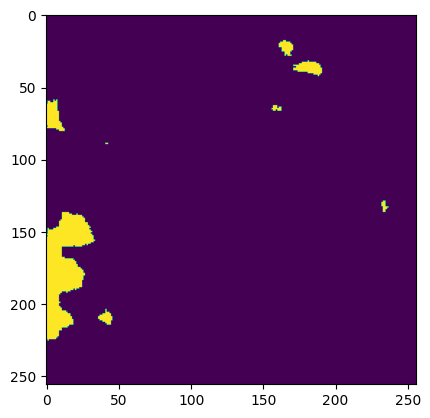

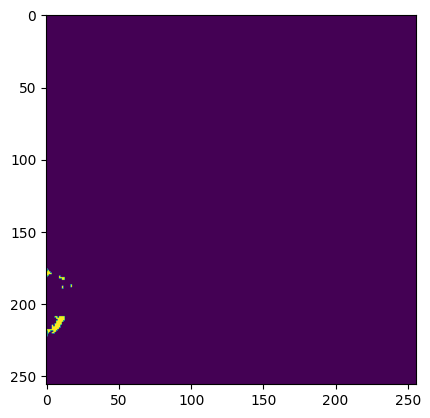

tensor([[[[ -0.2255,  -1.5716,  -1.1260,  ...,  -7.0097,  -4.7565,  -2.4369],
          [ -1.5441,  -2.3011,  -3.5361,  ..., -10.3966,  -8.2435,  -6.4427],
          [ -1.4152,  -3.8705,  -4.0826,  ..., -13.9998, -12.6658,  -8.5580],
          ...,
          [ -5.8862, -17.0613, -18.9617,  ..., -29.9301, -29.4028, -15.1761],
          [ -5.5777, -10.6562, -16.7279,  ..., -23.3743, -24.2248, -12.9896],
          [ -1.6588,  -4.5127,  -6.2959,  ..., -10.9613, -14.0635,  -5.0211]]]])


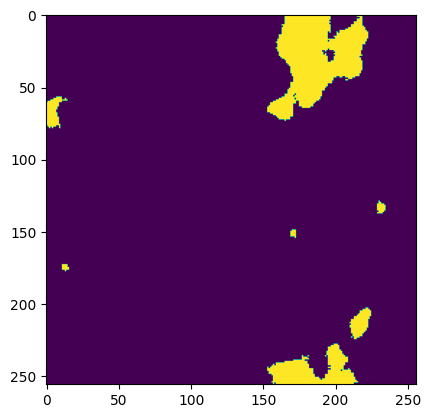

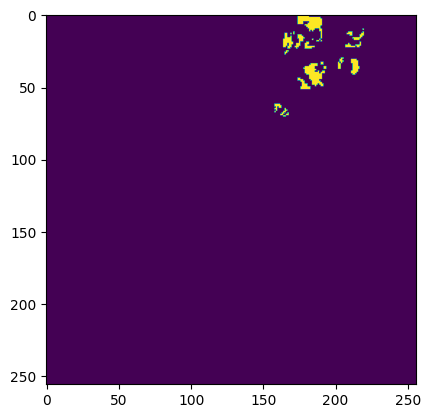

tensor([[[[ -0.2255,  -1.5716,  -1.1260,  ...,  -7.0097,  -4.7565,  -2.4369],
          [ -1.5441,  -2.3011,  -3.5361,  ..., -10.3966,  -8.2435,  -6.4427],
          [ -1.4152,  -3.8705,  -4.0826,  ..., -13.9998, -12.6658,  -8.5580],
          ...,
          [ -5.8862, -17.0613, -18.9617,  ..., -29.9301, -29.4028, -15.1761],
          [ -5.5777, -10.6562, -16.7279,  ..., -23.3743, -24.2248, -12.9896],
          [ -1.6588,  -4.5127,  -6.2959,  ..., -10.9613, -14.0635,  -5.0211]]]])


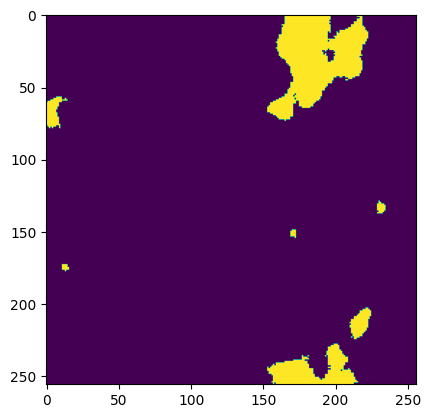

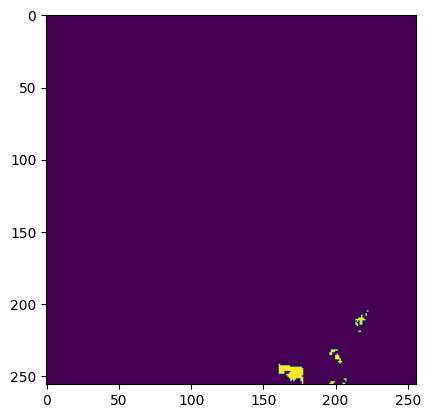

tensor([[[[ -1.4026,  -6.1546,  -4.6004,  ...,  -5.2200,  -3.4079,  -1.6888],
          [ -5.2530,  -9.4012, -12.7846,  ...,  -7.5819,  -5.8250,  -4.4999],
          [ -5.2097, -12.8303, -14.4292,  ..., -10.1378,  -9.1544,  -6.0110],
          ...,
          [ -4.4770, -12.9022, -14.2489,  ..., -18.6943, -18.1995,  -9.4816],
          [ -4.2594,  -8.0081, -12.4567,  ..., -14.6550, -15.2697,  -8.1016],
          [ -1.1827,  -3.2703,  -4.5673,  ...,  -6.9015,  -8.8071,  -3.0971]]]])


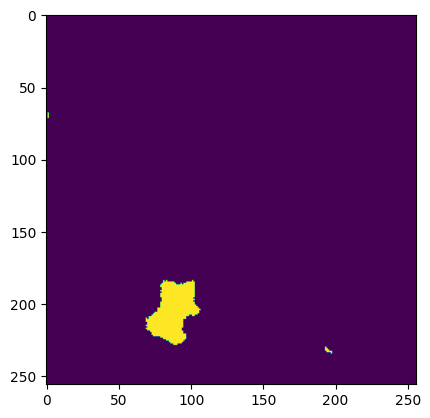

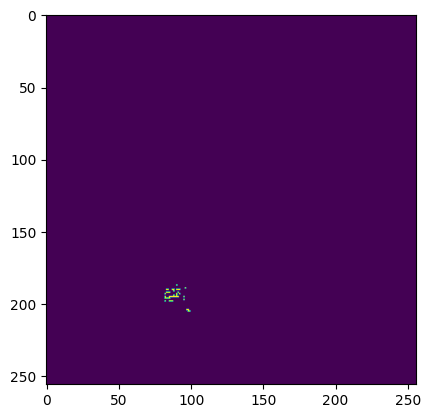

tensor([[[[ -0.3438,  -2.1142,  -1.5652,  ...,  -3.9170,  -2.3803,  -1.0853],
          [ -1.6886,  -3.0363,  -4.3611,  ...,  -5.4503,  -4.0457,  -3.0876],
          [ -1.6406,  -4.1226,  -4.8497,  ...,  -7.3759,  -6.6676,  -4.1345],
          ...,
          [ -2.7579,  -8.0868,  -8.9796,  ..., -15.7572, -15.3942,  -7.9029],
          [ -2.5989,  -4.9767,  -7.8034,  ..., -12.2905, -12.8145,  -6.7442],
          [ -0.6751,  -1.9924,  -2.8255,  ...,  -5.8216,  -7.4461,  -2.5643]]]])


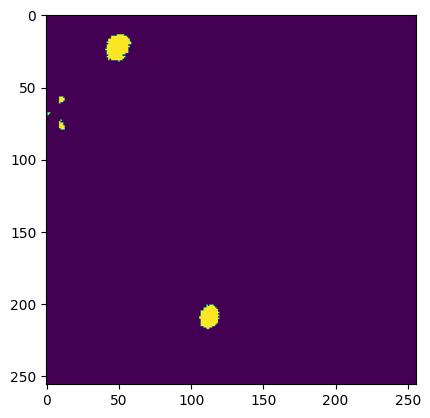

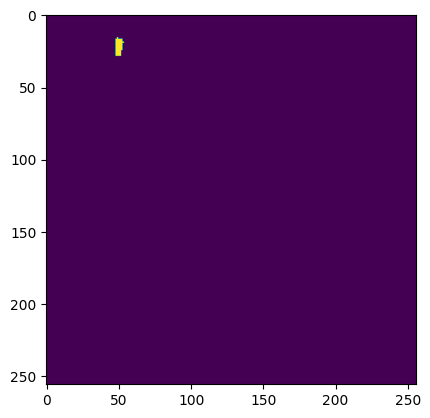

tensor([[[[ -0.3241,  -2.0337,  -1.5034,  ...,  -4.2603,  -2.6541,  -1.2436],
          [ -1.6110,  -2.9125,  -4.1863,  ...,  -5.9913,  -4.5231,  -3.4691],
          [ -1.5588,  -3.9480,  -4.6572,  ...,  -8.1194,  -7.3463,  -4.6356],
          ...,
          [ -2.9637,  -8.6902,  -9.6539,  ..., -15.7590, -15.4000,  -7.9167],
          [ -2.7952,  -5.3558,  -8.4112,  ..., -12.2767, -12.7809,  -6.7458],
          [ -0.7399,  -2.1606,  -3.0575,  ...,  -5.7924,  -7.4164,  -2.5631]]]])


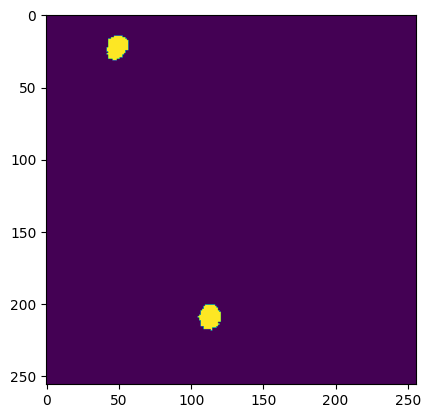

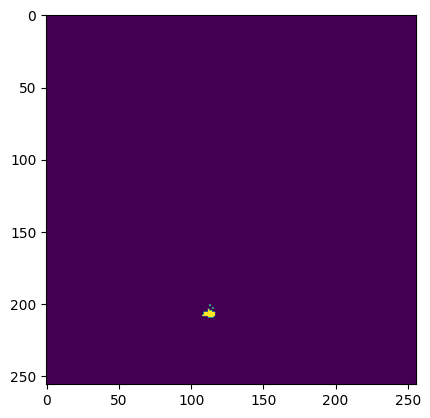

tensor([[[[ -0.5403,  -2.9141,  -2.1762,  ...,  -5.7466,  -3.6957,  -1.8196],
          [ -2.4147,  -4.3673,  -6.1216,  ...,  -8.1648,  -6.3419,  -4.8998],
          [ -2.3798,  -5.9372,  -6.8465,  ..., -11.1165, -10.0757,  -6.5135],
          ...,
          [ -4.7063, -13.6088, -15.0630,  ..., -15.6470, -15.2843,  -7.8871],
          [ -4.4641,  -8.4708, -13.1696,  ..., -12.1472, -12.6203,  -6.6778],
          [ -1.2688,  -3.5026,  -4.8908,  ...,  -5.7176,  -7.3142,  -2.5347]]]])


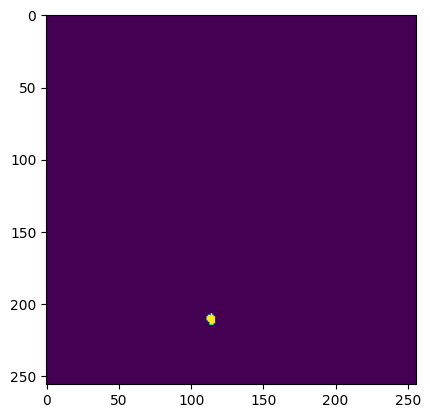

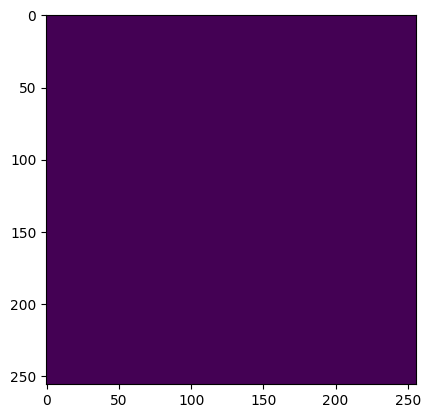

tensor([[[[ -0.5465,  -2.7643,  -2.0402,  ...,  -7.7762,  -5.1762,  -2.6499],
          [ -2.6583,  -4.3235,  -6.2106,  ..., -11.3647,  -8.9493,  -6.9616],
          [ -2.5932,  -6.5625,  -7.0648,  ..., -15.3169, -13.8529,  -9.2396],
          ...,
          [ -5.8471, -16.9479, -18.8427,  ..., -31.1682, -30.5865, -15.8011],
          [ -5.5397, -10.5834, -16.6334,  ..., -24.4080, -25.3335, -13.5508],
          [ -1.6483,  -4.4892,  -6.2615,  ..., -11.4847, -14.7109,  -5.2460]]]])


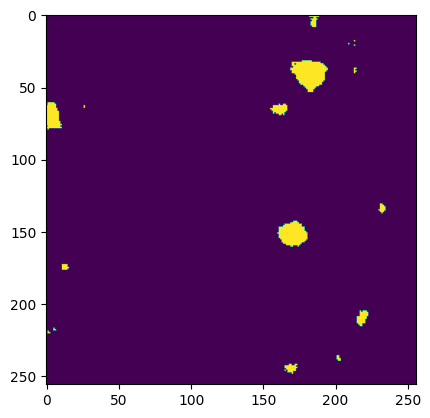

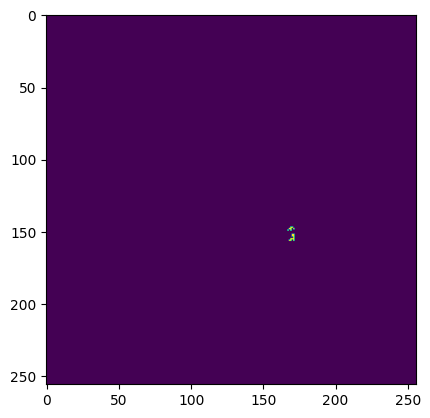

tensor([[[[ -1.3014,  -5.7101,  -4.2597,  ...,  -6.2247,  -4.0420,  -2.0192],
          [ -4.8525,  -8.7106, -11.8344,  ...,  -8.9522,  -6.9036,  -5.2938],
          [ -4.8150, -11.8651, -13.3623,  ..., -11.9990, -10.8499,  -7.0591],
          ...,
          [ -5.2126, -15.0628, -16.6889,  ..., -18.8157, -18.2905,  -9.5430],
          [ -4.9529,  -9.3660, -14.6545,  ..., -14.7826, -15.4357,  -8.1765],
          [ -1.4199,  -3.8805,  -5.4237,  ...,  -6.9860,  -8.9020,  -3.1285]]]])


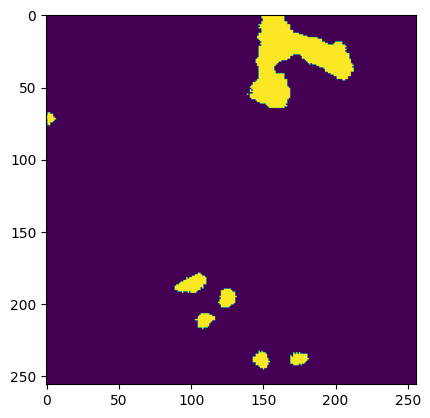

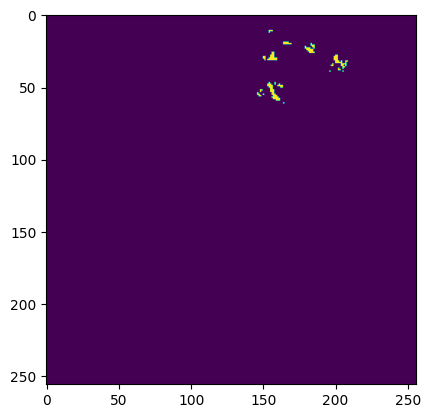

tensor([[[[ -1.3014,  -5.7101,  -4.2597,  ...,  -6.2247,  -4.0420,  -2.0192],
          [ -4.8525,  -8.7106, -11.8344,  ...,  -8.9522,  -6.9036,  -5.2938],
          [ -4.8150, -11.8651, -13.3623,  ..., -11.9990, -10.8499,  -7.0591],
          ...,
          [ -5.2126, -15.0628, -16.6889,  ..., -18.8157, -18.2905,  -9.5430],
          [ -4.9529,  -9.3660, -14.6545,  ..., -14.7826, -15.4357,  -8.1765],
          [ -1.4199,  -3.8805,  -5.4237,  ...,  -6.9860,  -8.9020,  -3.1285]]]])


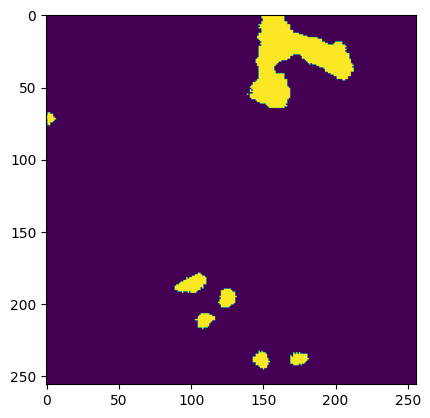

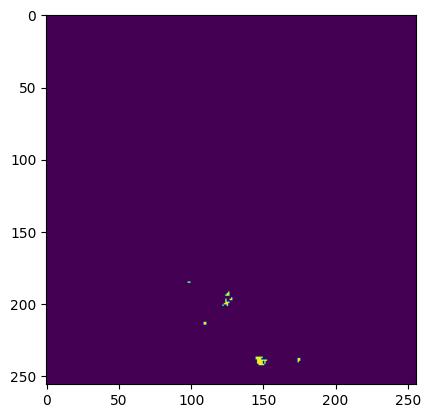

In [604]:
# Set the model to evaluation mode
model.eval()


for i in range(0,10):
    sample_embedding = torch.tensor(train_embs_array[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        print(predicted_raster)
        predictions = torch.sigmoid(predicted_raster) > 0.5

    rasterio.plot.show(np.array(predictions))
    rasterio.plot.show(train_raster_array1617[i])

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

#rasterio.plot.show(np.array(predicted_raster))

In [620]:
print(test_embs_with_polys16.to_crs(epsg=4326)['geometry'].iloc[2])
print(test_embs_with_polys16.to_crs(epsg=4326)['geometry'].iloc[2].centroid)

POLYGON ((-83.99013563911578 32.22436062307904, -83.99468429899868 32.08598048969447, -84.15724354762725 32.089735632537995, -84.15294009417724 32.228135838927784, -83.99013563911578 32.22436062307904))
POINT (-84.07375174737754 32.157070593978844)


In [759]:
bigger_losses = prediction_losses_np[prediction_losses_np > 0.13]
print(bigger_losses)

[2.4542180e-01 1.3903581e-01 3.5837294e+05 9.4314062e+04 1.7624371e-01]


Mean: losses    9053.792969
dtype: float32
Median: losses    0.040049
dtype: float32
       losses
0.1  0.013799
0.5  0.040049
0.9  0.129501


50

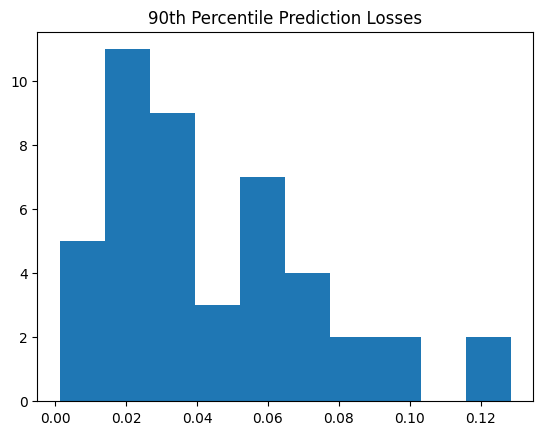

In [770]:
prediction_losses_df = pd.DataFrame(np.array(prediction_losses), columns = ['losses'])
#plt.hist(prediction_losses_np)

mean_value = prediction_losses_df.mean()           # Mean
median_value = prediction_losses_df.median()      # Median
percentiles = prediction_losses_df.quantile([0.1, 0.5, 0.9])

print("Mean:", mean_value)
print("Median:", median_value)
print(percentiles)


smaller_losses = prediction_losses_df[prediction_losses_df < 0.13]
plt.hist(smaller_losses)
plt.title('90th Percentile Prediction Losses')
len(smaller_losses)

tensor(0.0851)
POINT (-82.9813303418409 32.8899903590664)


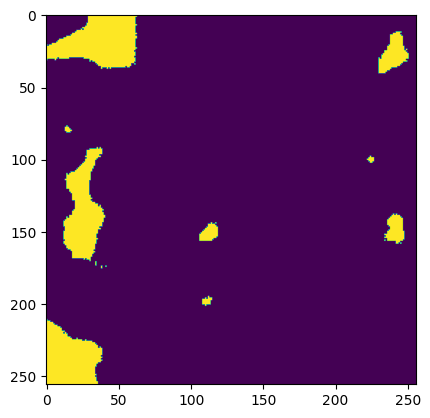

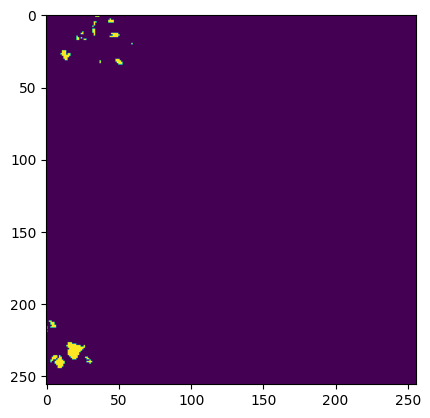

tensor(0.1634)
POINT (-83.15114491577509 32.75691355372341)


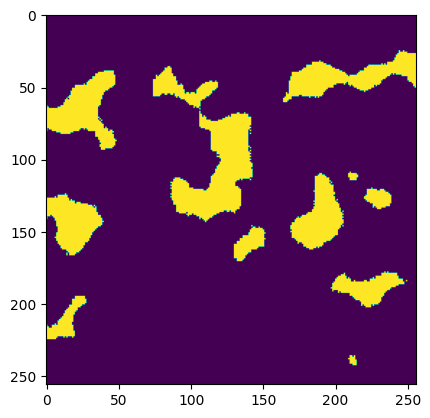

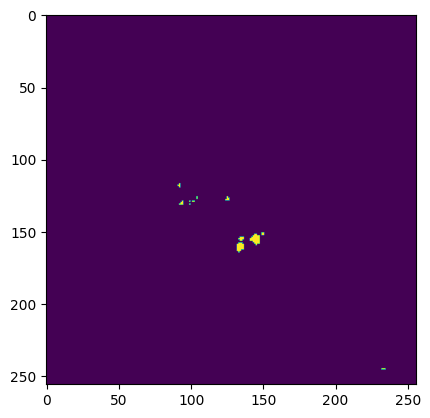

tensor(0.0980)
POINT (-86.42597905686085 33.30131864277044)


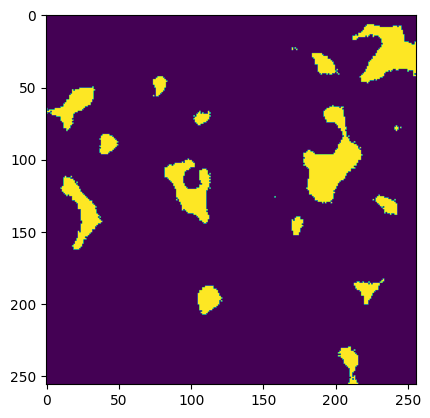

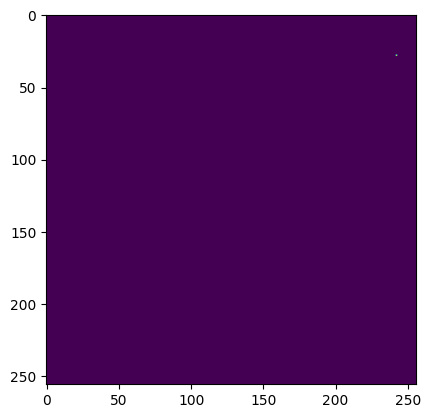

tensor(0.0784)
POINT (-83.30610437250655 32.97086149213259)


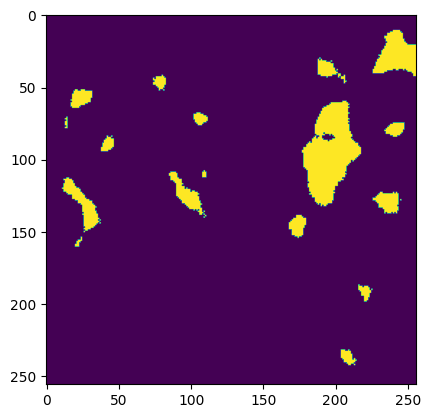

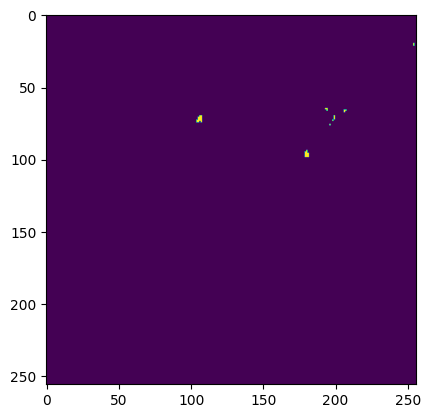

tensor(0.0052)
POINT (-87.58321816838047 33.6487069854031)


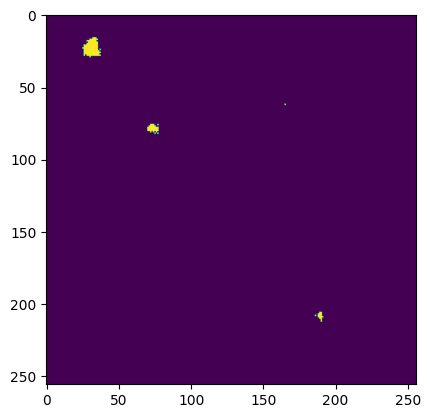

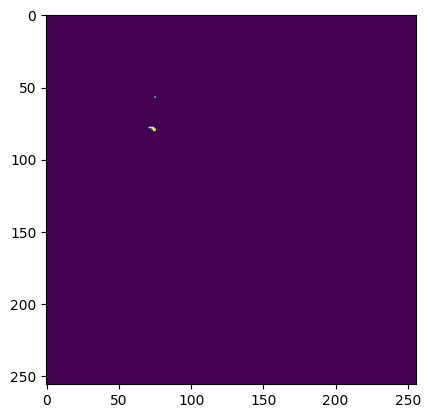

In [866]:
# Set the model to evaluation mode for one sample
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
prediction_losses = []

for i in range(10,15):
    sample_embedding = torch.tensor(test_embs_array1617[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    ground_truth = test_raster_array1617[i].flatten()

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(test_raster_array1617[i].reshape(1, 1, 256, 256))
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        print(test_embs_with_polys1617.to_crs(epsg=4326)['geometry'].iloc[i].centroid)


    rasterio.plot.show(np.array(predictions))
    rasterio.plot.show(test_raster_array1617[i])

In [847]:
# Set the model to evaluation mode for train set
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
train_prediction_losses = []
train_all_ground_truths = []
train_all_predictions = []

for i in range(0,50):
    sample_embedding = torch.tensor(train_embs_array1617[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(train_raster_array1617[i].reshape(1, 1, 256, 256))
        ground_truth = actuals.squeeze(1).numpy()
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        predictions_np = predictions.squeeze(1).numpy()

    train_all_predictions.extend(predictions_np)
    train_all_ground_truths.extend(ground_truth)

    #rasterio.plot.show(np.array(predictions))
    #rasterio.plot.show(test_raster_array1617[i])

    #print(train_embs_with_polys1617.to_crs(epsg=4326)['geometry'].iloc[i].centroid)

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

train_all_predictions = np.array(train_all_predictions)
train_all_ground_truths = np.array(train_all_ground_truths)

tensor(0.0730)
tensor(0.1473)
tensor(0.1641)
tensor(0.0443)
tensor(0.0177)
tensor(0.0167)
tensor(0.0012)
tensor(0.0436)
tensor(0.1039)
tensor(0.1094)
tensor(0.0896)
tensor(0.0888)
tensor(0.0646)
tensor(0.0534)
tensor(0.0987)
tensor(0.0799)
tensor(0.0350)
tensor(0.0351)
tensor(0.0349)
tensor(0.0763)
tensor(0.2377)
tensor(0.2419)
tensor(0.2238)
tensor(0.0012)
tensor(0.0795)
tensor(0.0401)
tensor(0.0248)
tensor(0.0860)
tensor(0.2454)
tensor(0.2456)
tensor(0.0440)
tensor(0.1095)
tensor(0.0341)
tensor(0.0388)
tensor(0.0123)
tensor(0.0157)
tensor(0.0103)
tensor(0.0190)
tensor(0.0297)
tensor(0.0386)
tensor(0.0045)
tensor(0.0207)
tensor(0.0096)
tensor(0.0243)
tensor(0.0681)
tensor(0.0339)
tensor(0.0088)
tensor(0.0697)
tensor(0.0696)
tensor(0.0083)


In [848]:
# Train
from sklearn.metrics import precision_score, recall_score, f1_score
flattened_ground_truths = train_all_ground_truths.flatten().astype(int)  # Convert to 1D and numpy
flattened_predictions = train_all_predictions.flatten().astype(int)  # Convert to 1D and numpy

precision = precision_score(flattened_ground_truths, flattened_predictions, average='binary')
recall = recall_score(flattened_ground_truths, flattened_predictions, average='binary')
f1 = f1_score(flattened_ground_truths, flattened_predictions, average='binary')

print(f'precision on test: {precision}')
print(f'recall on test: {recall}')
print(f'f1 on test: {f1}')

precision on test: 0.026595744680851064
recall on test: 0.9629186602870813
f1 on test: 0.05176183127572016


tensor(0.0246)


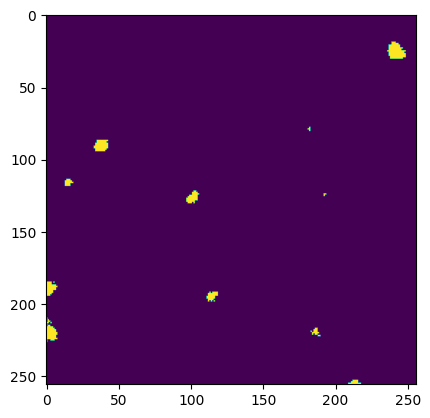

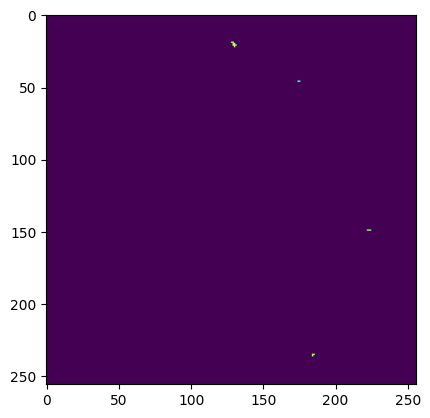

POINT (-87.17049389434325 33.37017646498434)
tensor(0.0167)


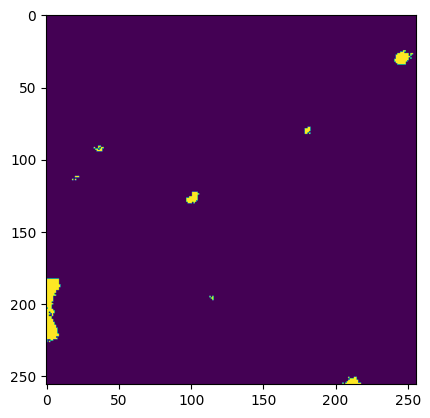

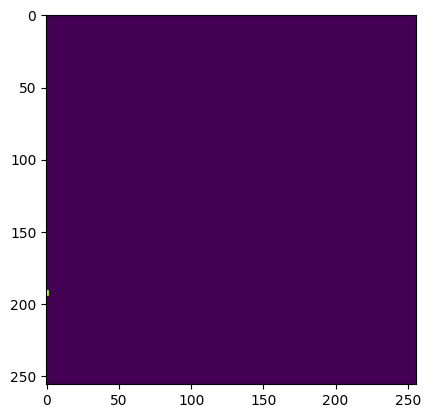

POINT (-86.67616163734495 33.09277732557454)
tensor(0.0381)


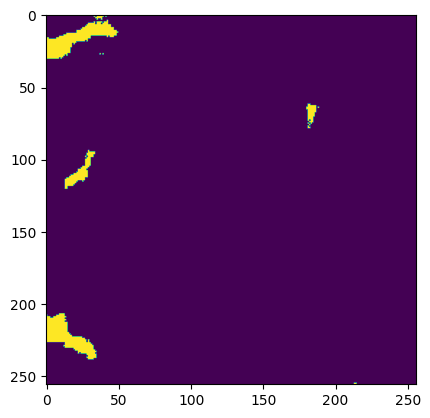

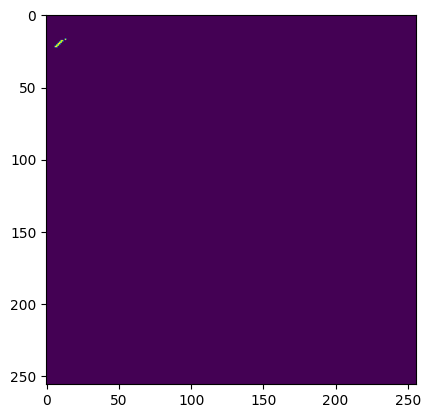

POINT (-87.00540525842077 33.85680432682469)
tensor(0.1001)


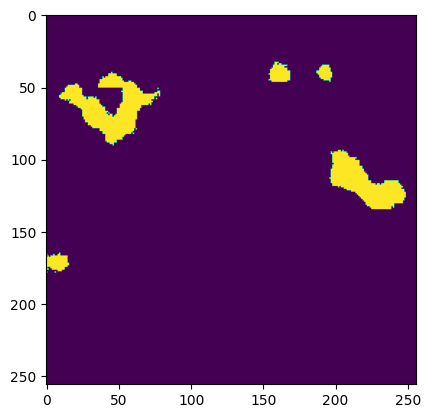

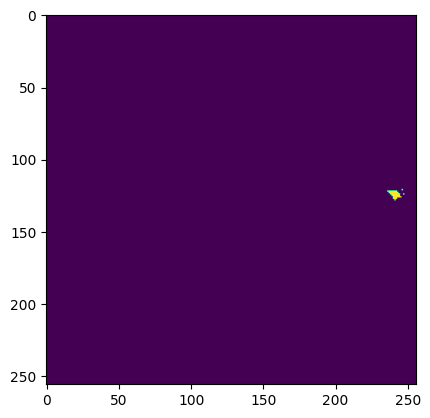

POINT (-87.53317929242036 38.36329153764892)
tensor(0.0701)


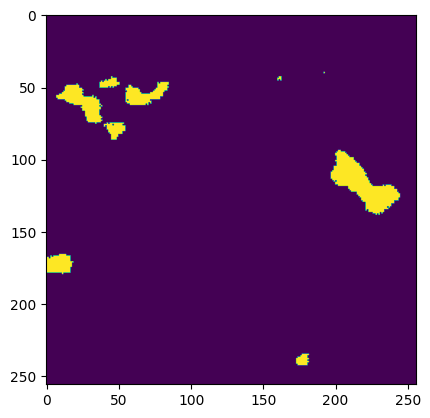

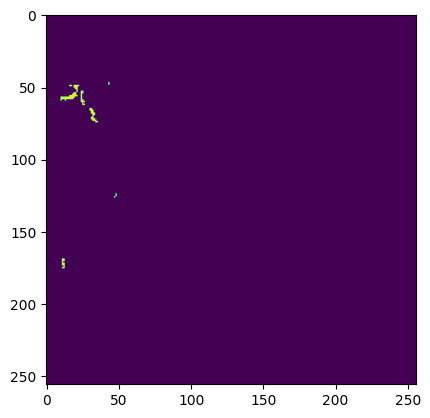

POINT (-87.18120056695328 38.2259328626371)
tensor(0.0223)


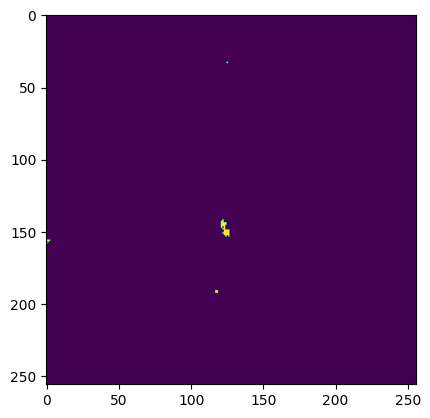

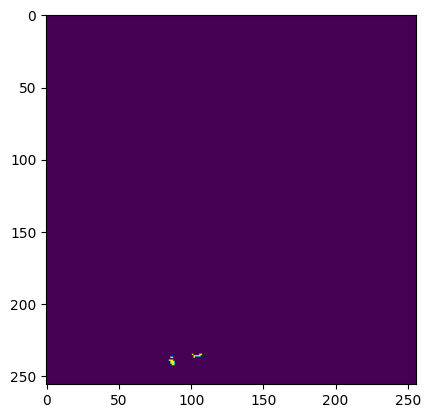

POINT (-89.68048835421182 39.37336816315769)
tensor(0.0310)


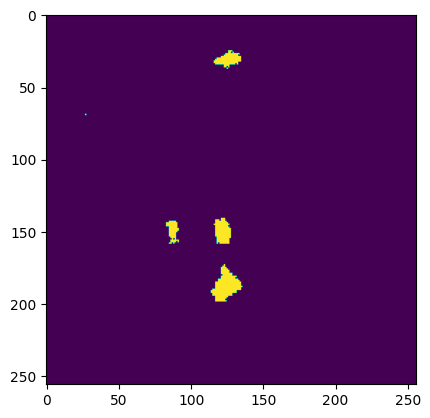

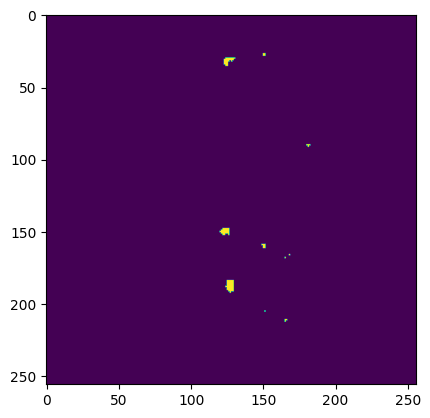

POINT (-87.3618972191781 39.26528567631267)
tensor(0.0794)


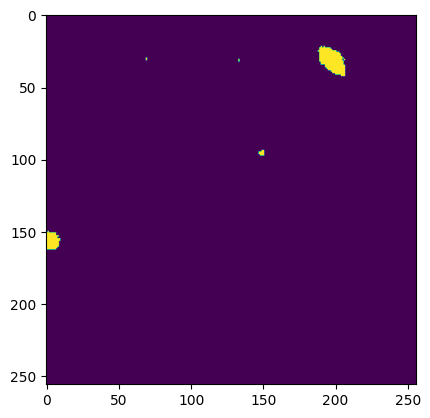

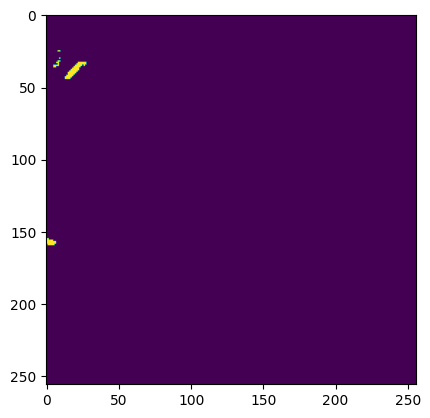

POINT (-87.18312959629525 38.98888157592438)
tensor(0.0595)


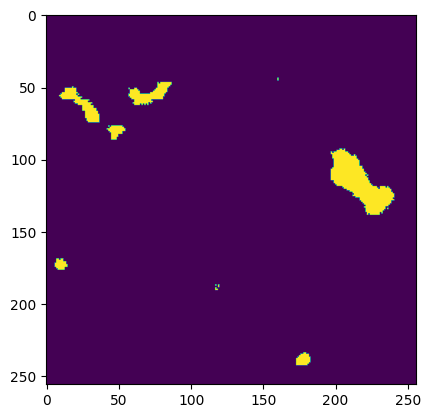

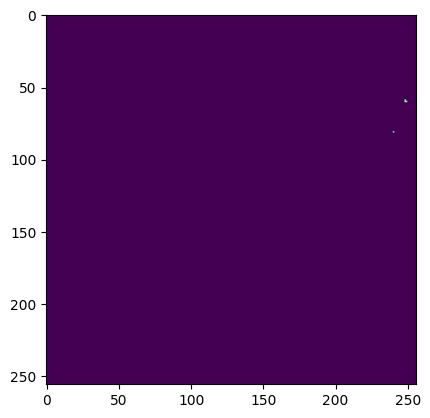

POINT (-87.35839882715123 38.57321783968862)
tensor(0.1601)


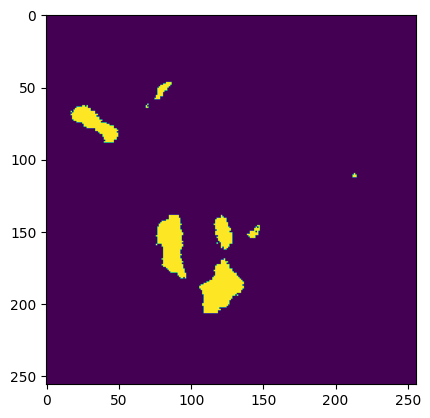

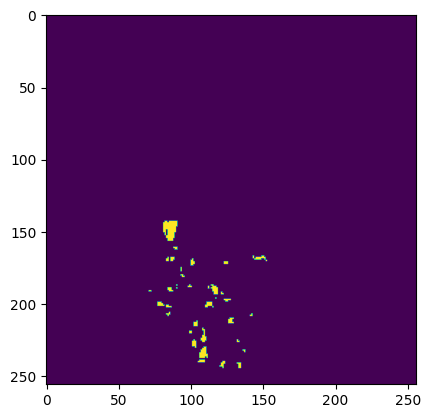

POINT (-87.00573994359631 38.57376637788699)
tensor(0.1127)


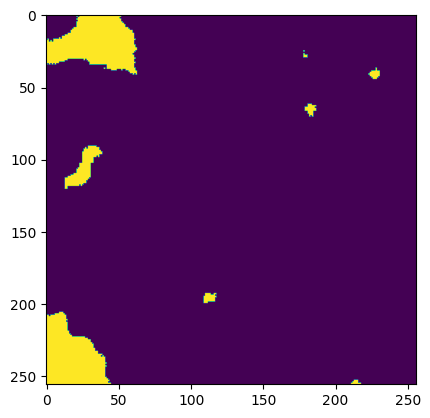

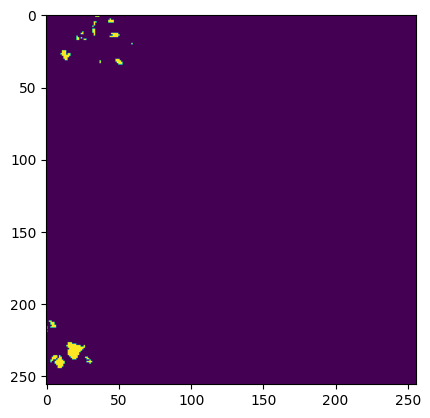

POINT (-82.9813303418409 32.8899903590664)
tensor(0.0984)


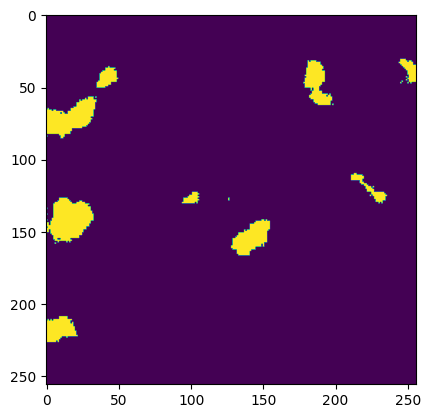

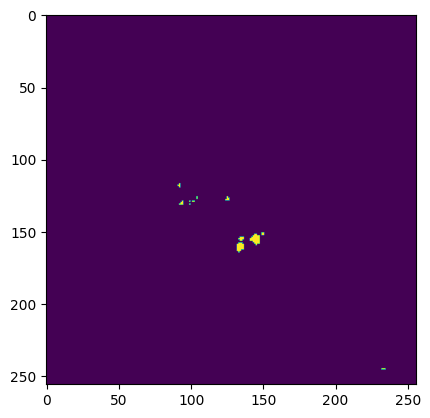

POINT (-83.15114491577509 32.75691355372341)
tensor(0.0431)


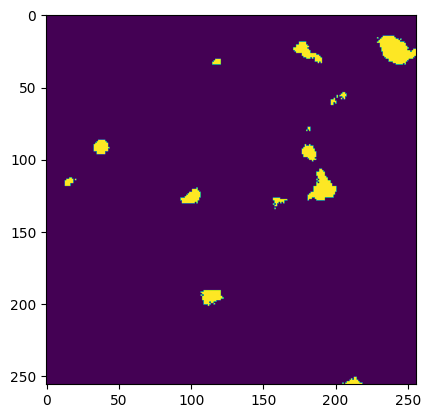

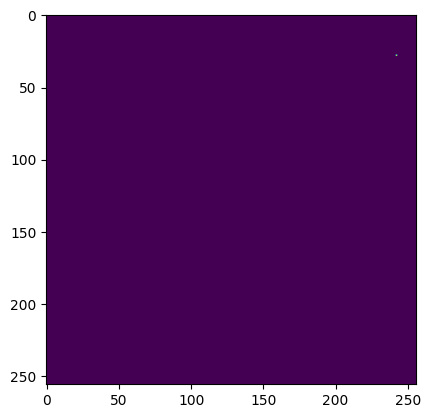

POINT (-86.42597905686085 33.30131864277044)
tensor(0.0520)


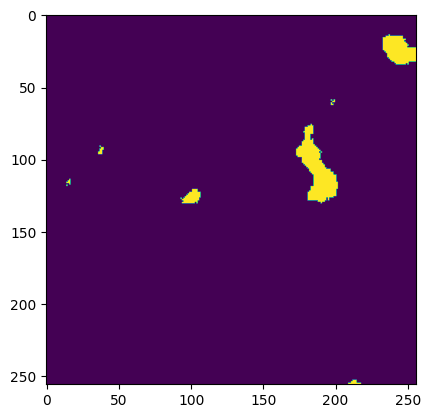

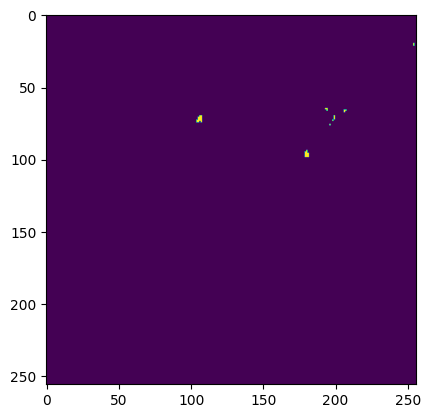

POINT (-83.30610437250655 32.97086149213259)
tensor(0.0140)


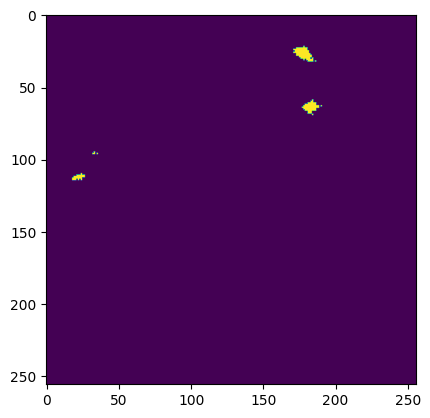

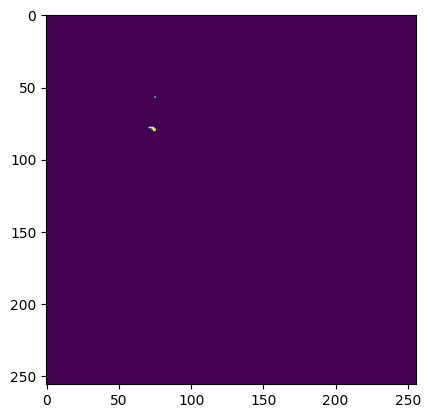

POINT (-87.58321816838047 33.6487069854031)
tensor(0.0225)


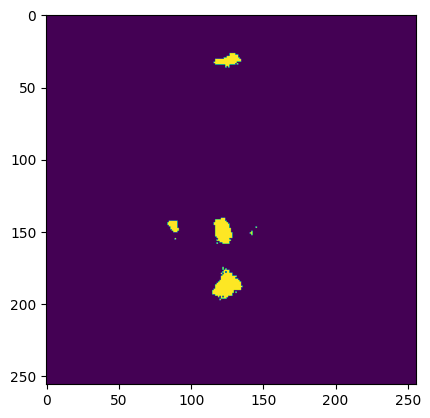

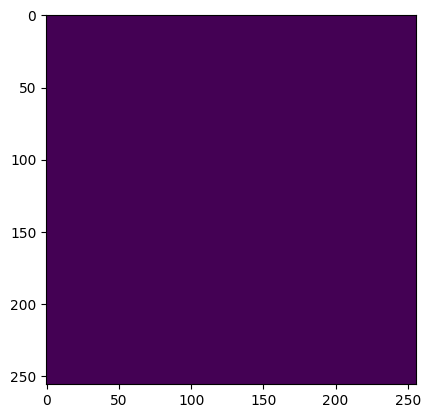

POINT (-87.27160632487785 39.477464276738544)
tensor(0.0322)


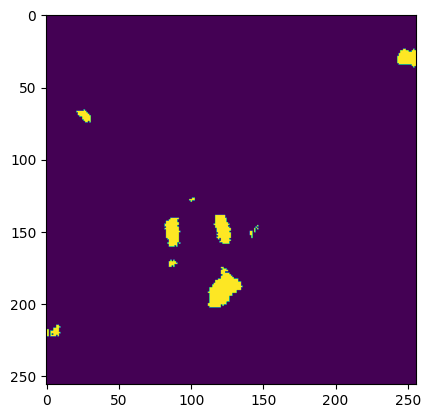

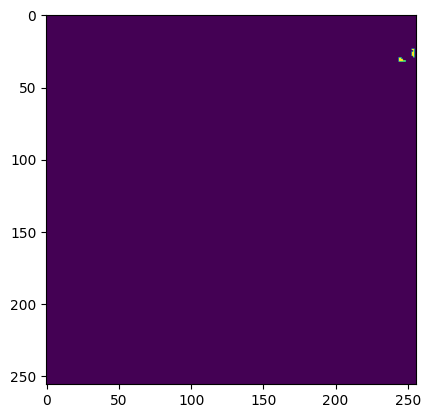

POINT (-88.14215767682511 38.0880359895334)
tensor(0.0072)


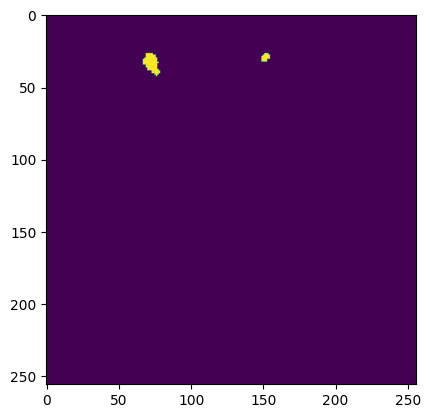

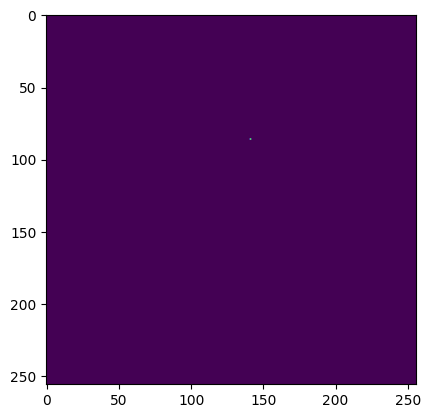

POINT (-85.37836926017185 43.89616653288462)
tensor(0.0794)


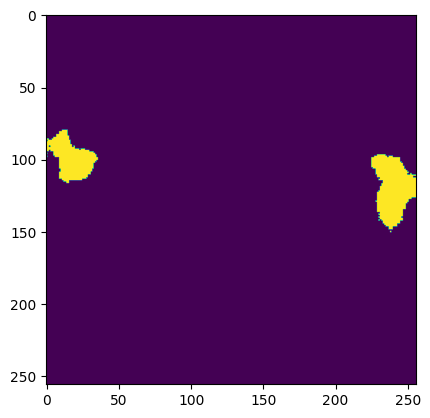

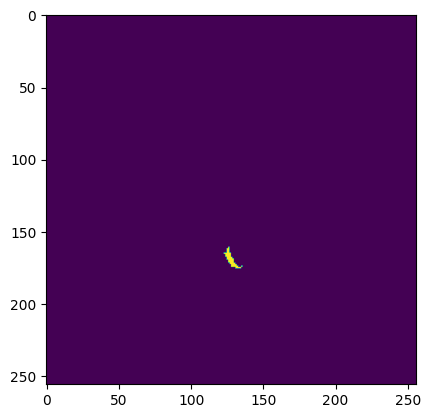

POINT (-87.90441314068855 46.466320259017685)
tensor(0.0336)


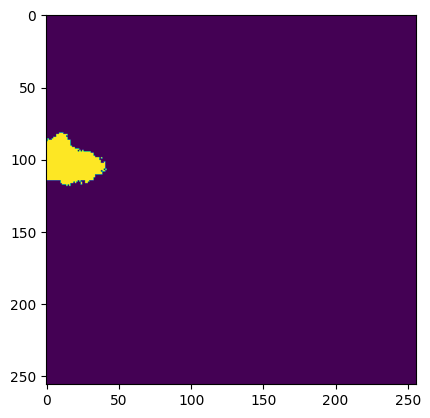

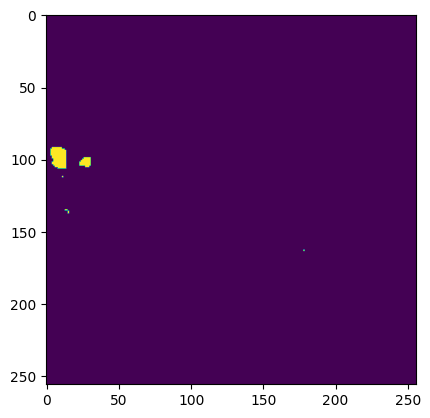

POINT (-87.50432614083815 46.4687842688047)
tensor(0.0139)


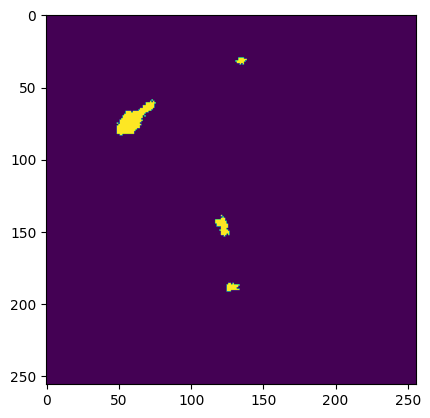

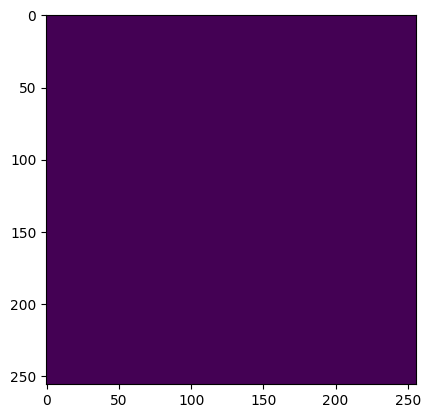

POINT (-81.99107611505788 39.643166328626435)
tensor(0.0073)


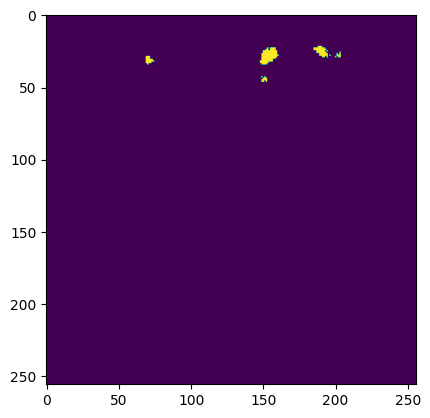

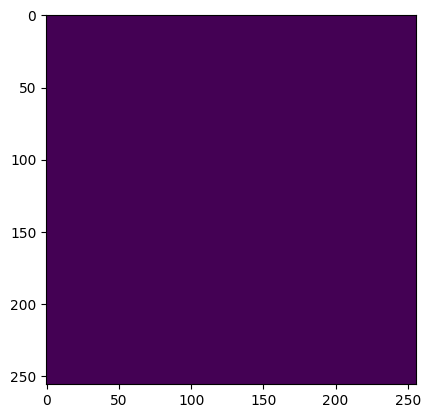

POINT (-81.3714162989037 40.65339128717479)
tensor(0.0068)


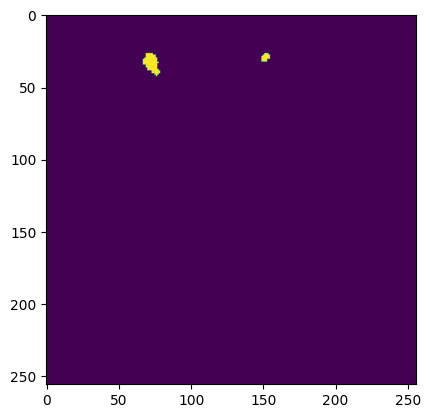

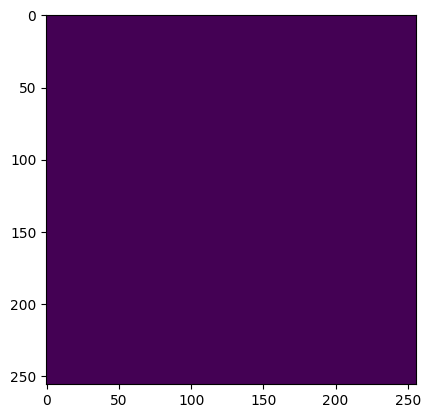

POINT (-85.27875593195381 43.82718246947683)
tensor(0.0075)


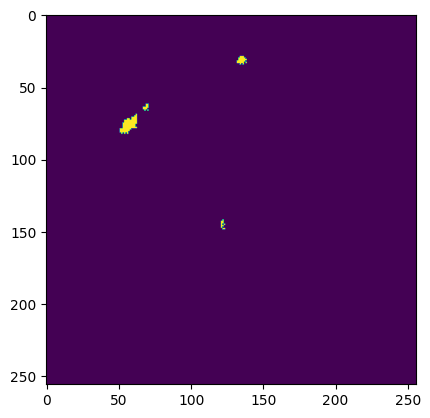

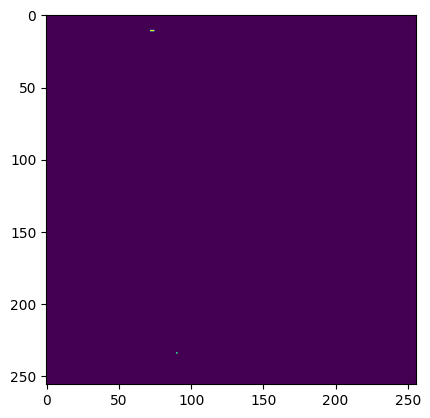

POINT (-82.42583238001833 39.05059705959766)
tensor(0.0271)


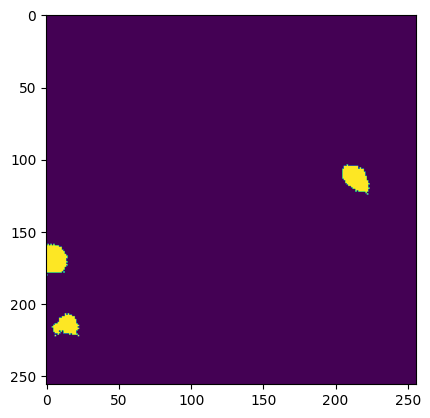

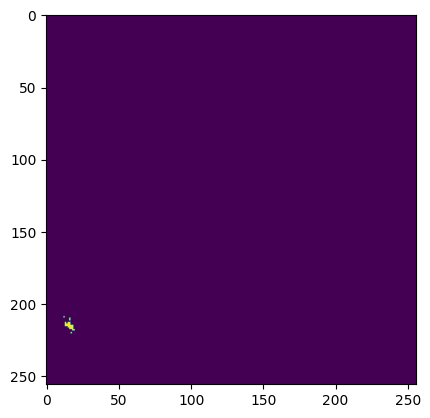

POINT (-81.36739959413713 40.307556542835535)
tensor(0.0224)


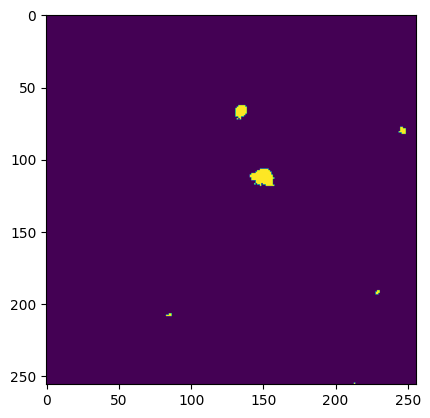

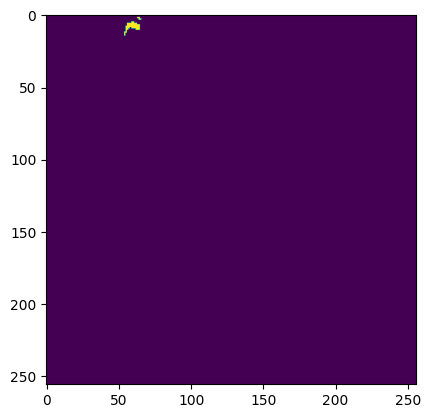

POINT (-80.83735148185136 34.89993938247203)
tensor(0.2503)


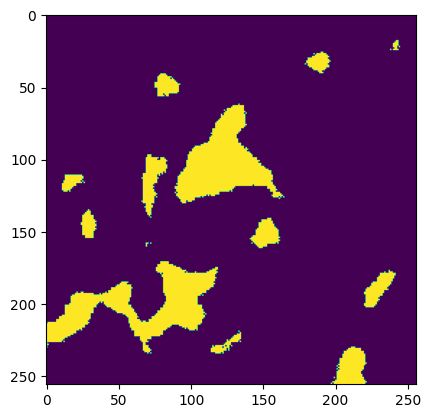

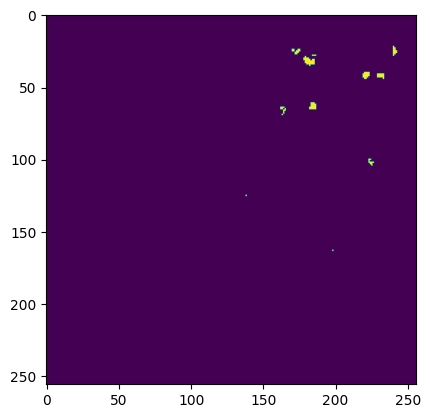

POINT (-82.49132985751058 33.367287897368094)
tensor(0.2128)


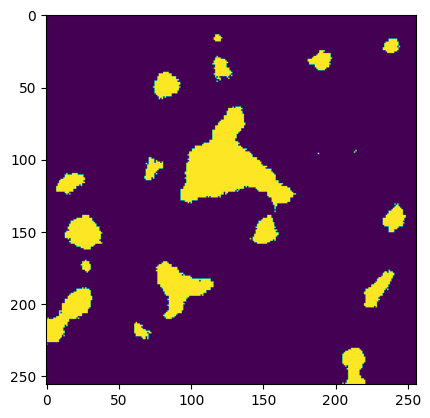

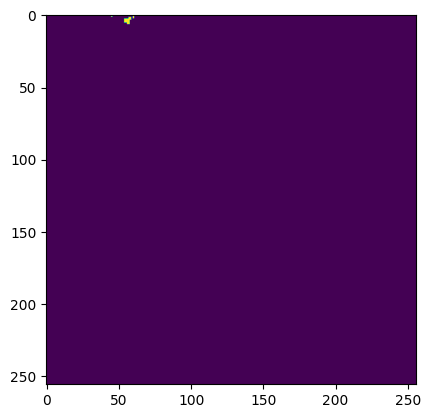

POINT (-82.98017029333492 33.08342222672125)
tensor(0.1200)


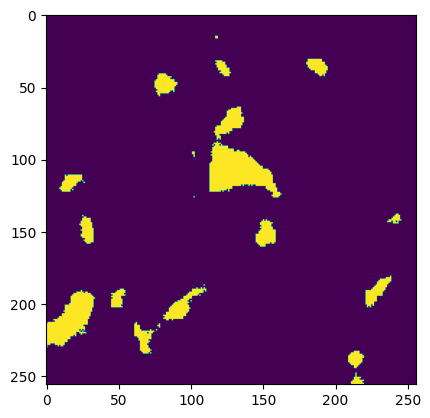

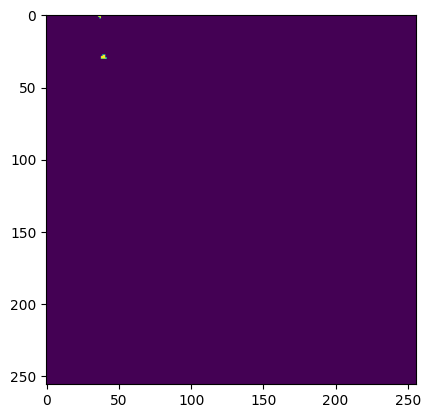

POINT (-82.81567745476238 33.085927084742934)
tensor(0.2983)


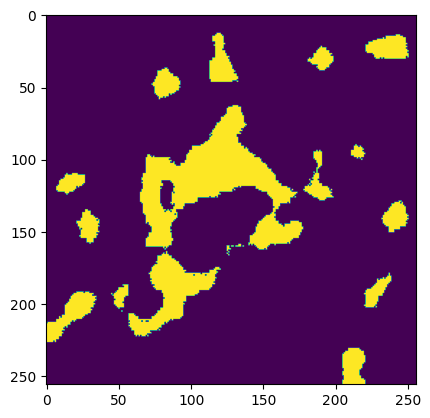

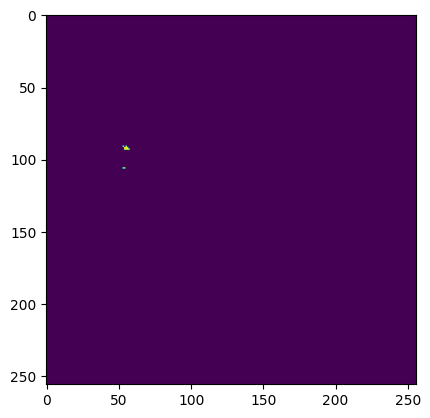

POINT (-83.46965162505444 32.936183714038485)
tensor(0.0571)


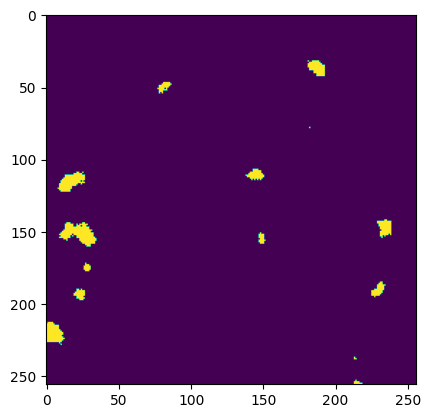

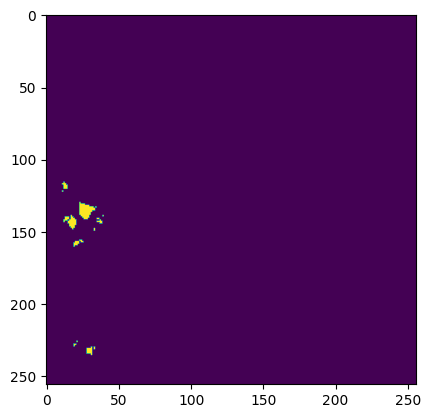

POINT (-82.97707664739222 32.944952463314344)
tensor(0.0832)


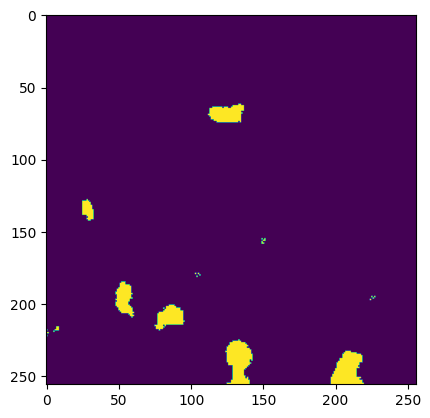

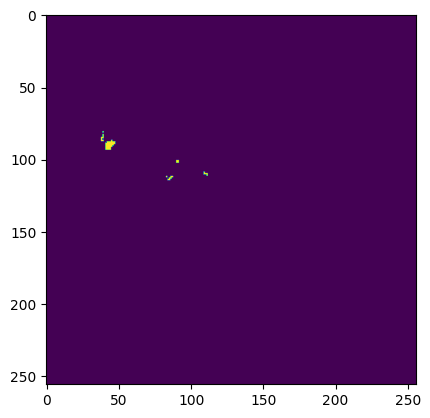

POINT (-83.95282358035662 32.64873180373039)
tensor(0.0146)


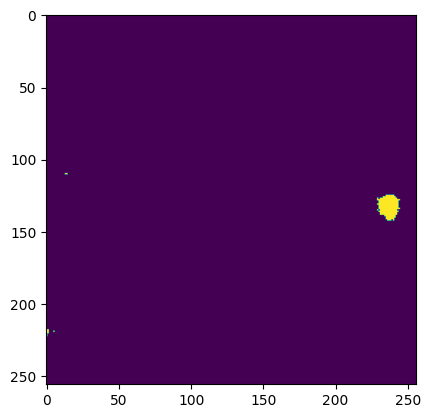

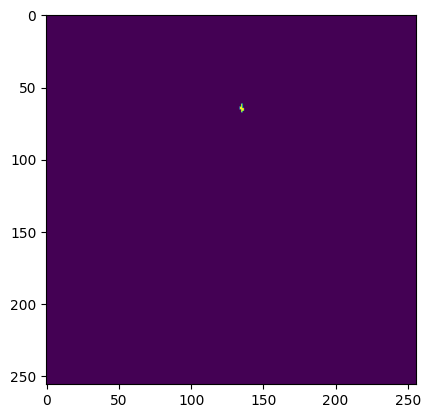

POINT (-83.42297580409793 37.02290807552804)
tensor(0.0630)


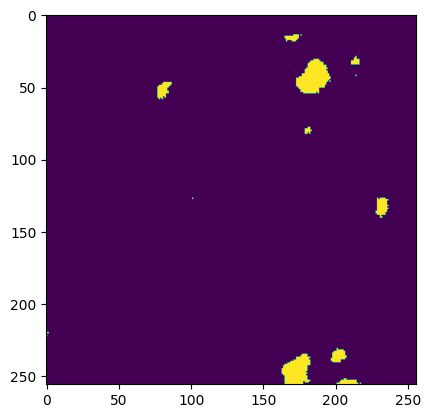

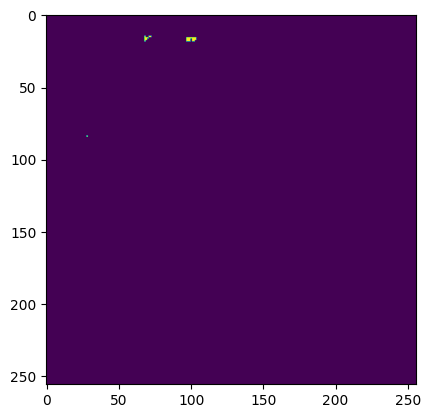

POINT (-83.25043346194799 37.02630745814617)
tensor(0.0174)


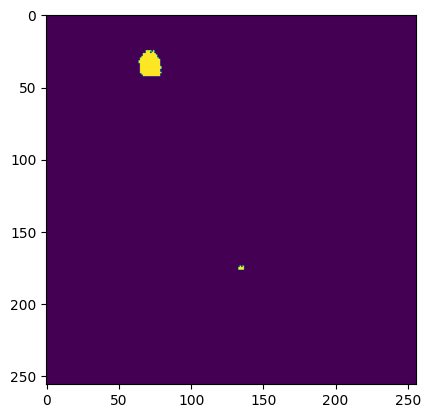

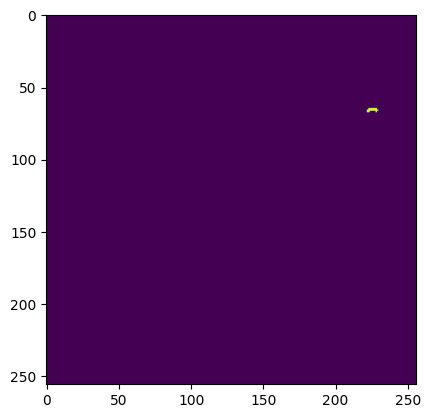

POINT (-81.70497781087437 37.9470886322927)
tensor(0.0126)


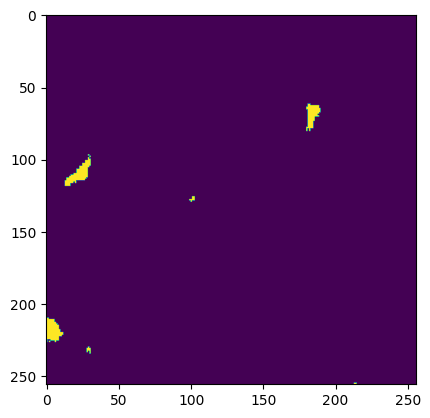

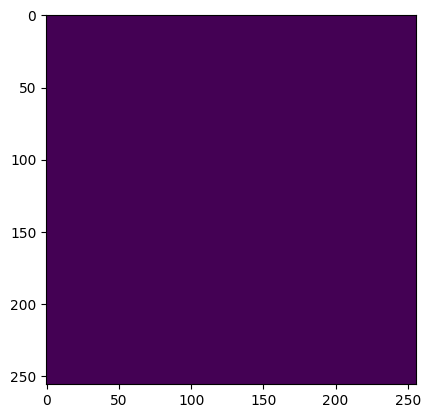

POINT (-82.22705739408966 37.804368734774016)
tensor(0.0270)


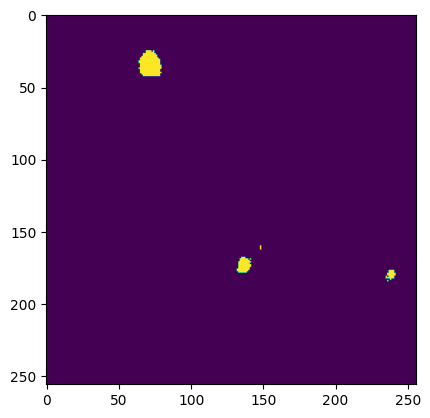

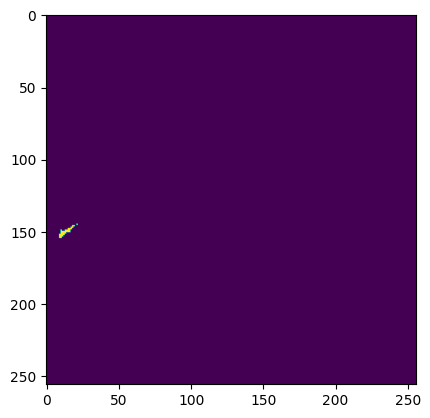

POINT (-81.52917271461072 37.80957120157417)
tensor(0.0087)


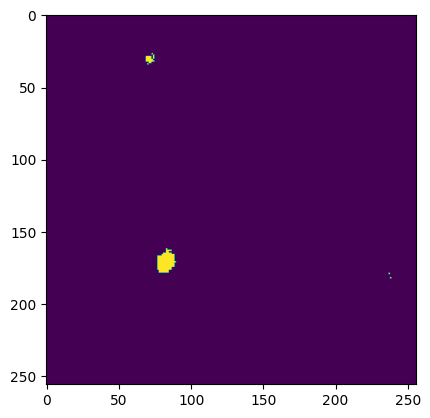

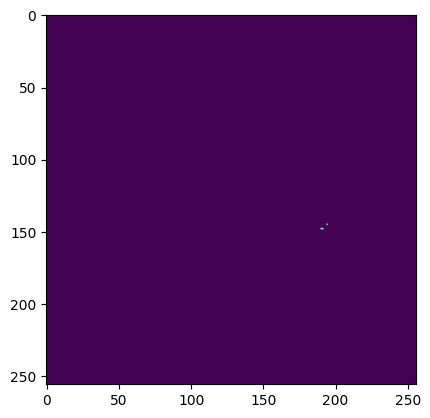

POINT (-82.90358151441637 36.96478332109083)
tensor(0.0257)


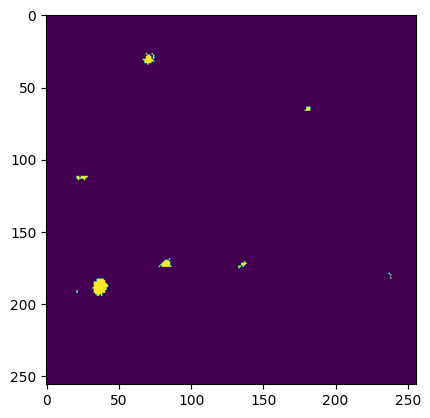

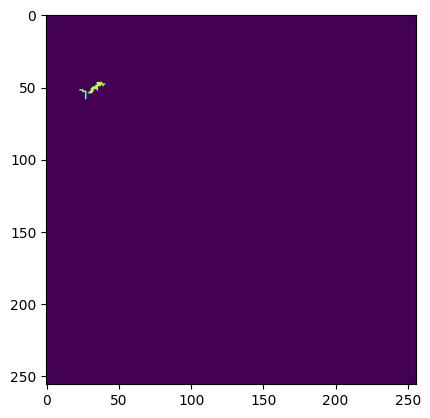

POINT (-83.07979625426154 37.10026202613087)
tensor(0.0072)


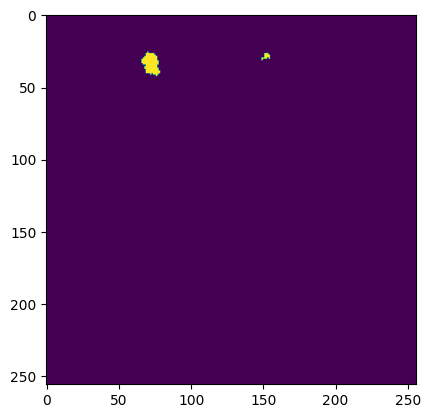

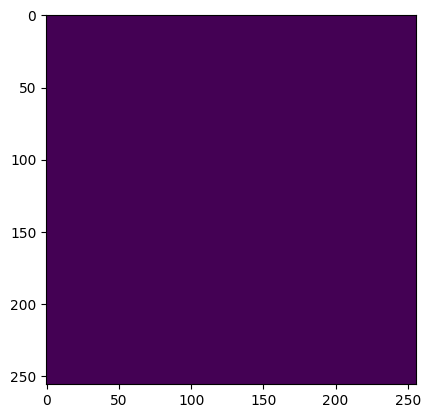

POINT (-82.06982660905828 38.98412077233358)
tensor(0.0138)


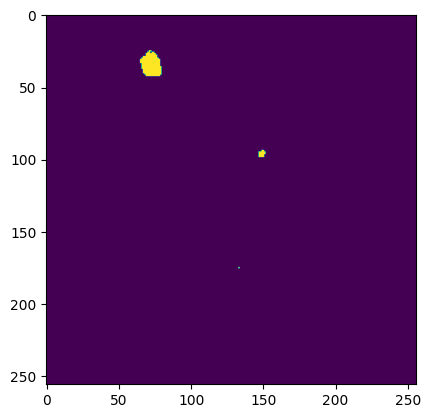

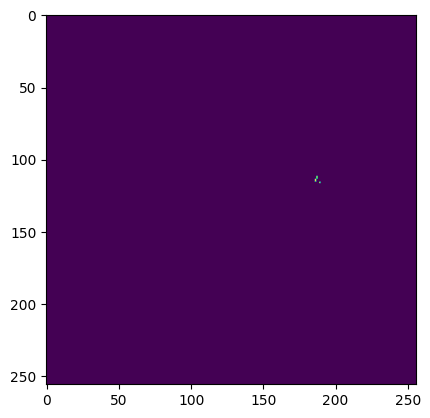

POINT (-82.65956221724252 37.73147666163518)
tensor(0.0416)


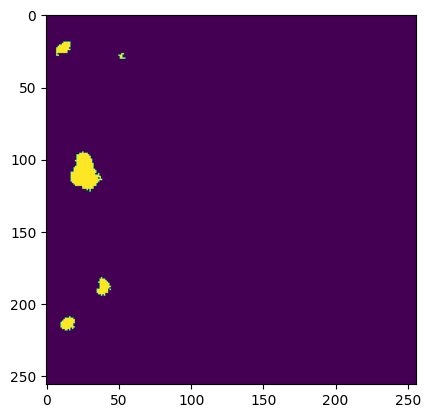

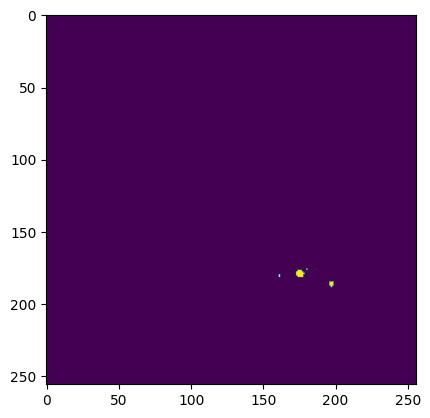

POINT (-80.58494613365919 34.55143428863971)
tensor(0.0366)


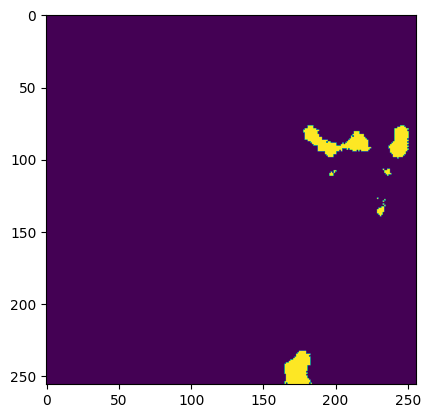

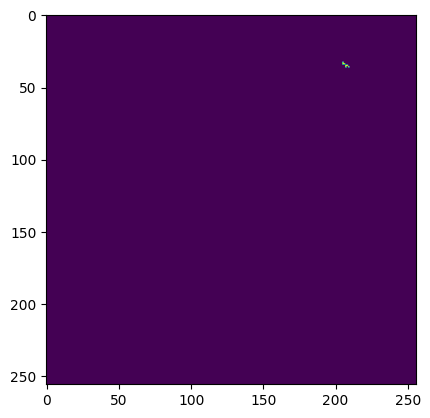

POINT (-80.46581608354464 40.02689226814906)
tensor(0.0214)


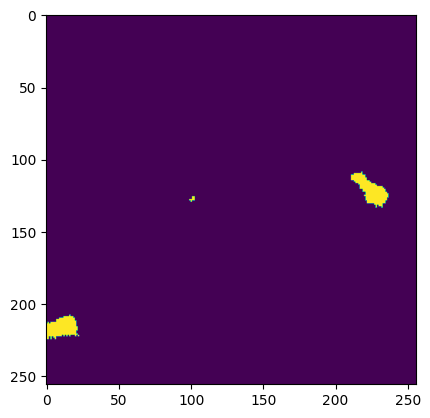

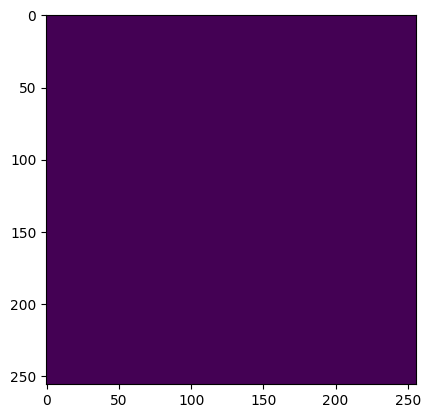

POINT (-81.36815199276342 40.44593516690332)
tensor(0.0776)


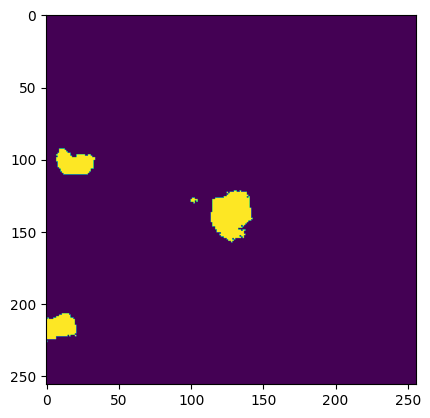

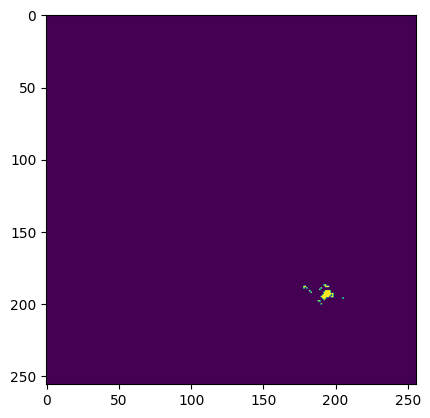

POINT (-81.54815082678314 40.306841328491934)
tensor(0.0144)


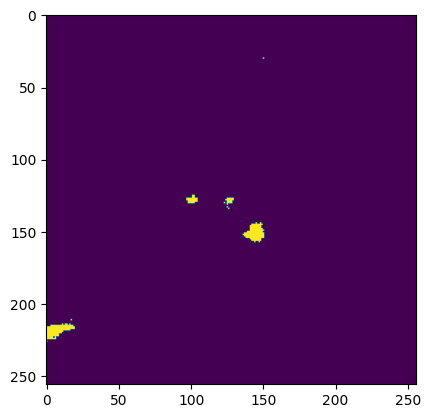

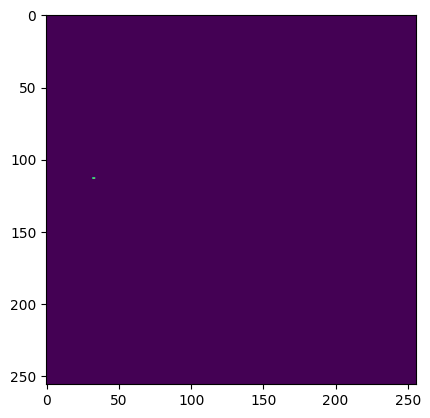

POINT (-80.82512494929257 40.3080077474395)
tensor(0.0148)


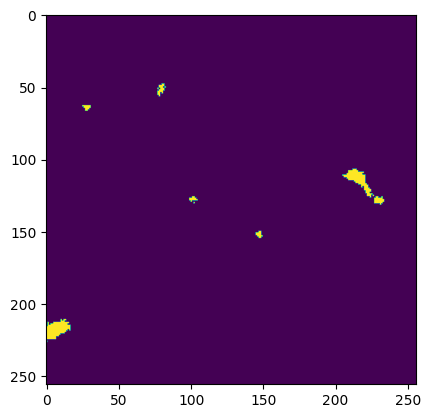

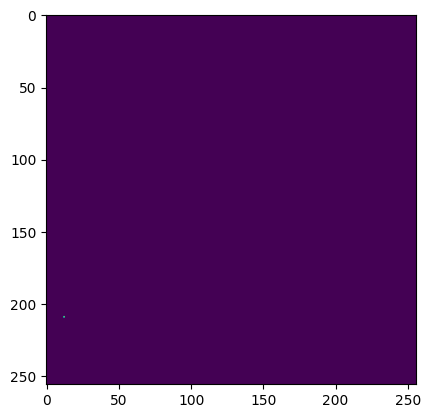

POINT (-80.91356637325873 40.166479431617766)
tensor(0.0169)


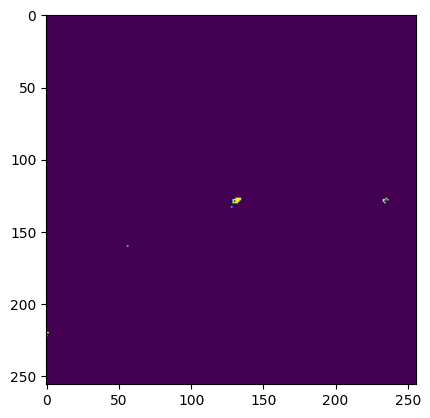

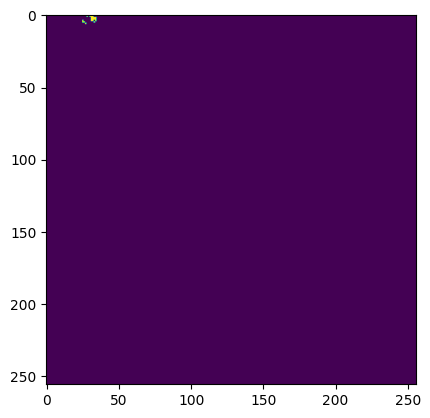

POINT (-81.81795994446139 40.37281669150791)
tensor(0.0164)


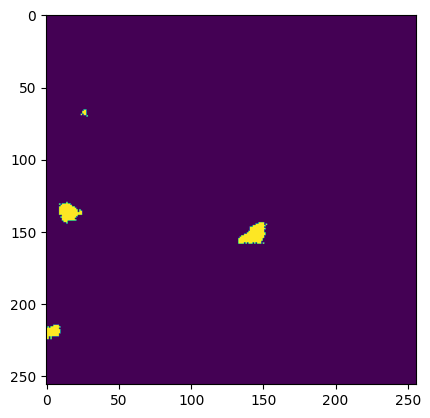

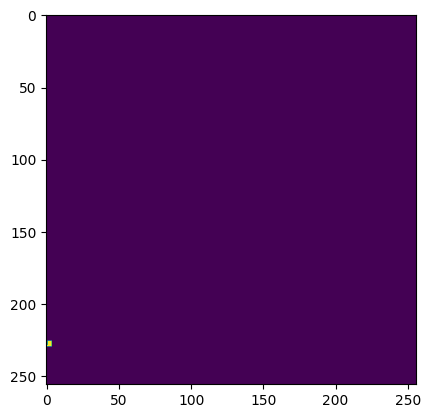

POINT (-81.81629261664898 40.23444756017729)
tensor(0.0187)


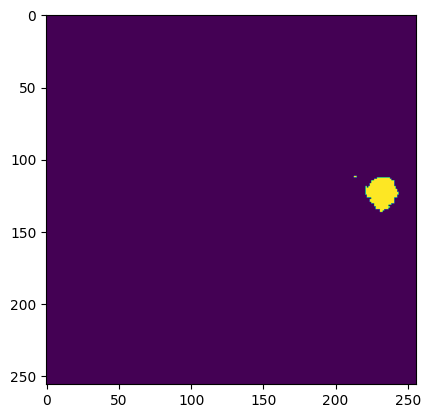

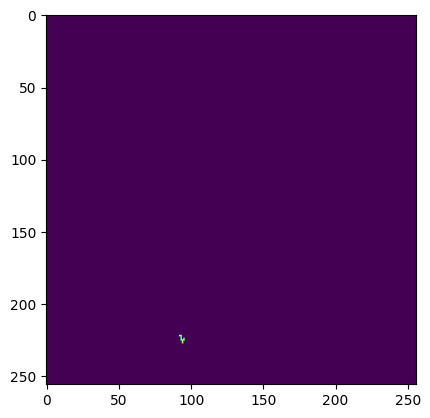

POINT (-75.58432685176872 41.35500683154698)
(3276800,)
(3276800,)


In [859]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
prediction_losses = []
all_ground_truths = []
all_predictions = []

for i in range(0,50):
    sample_embedding = torch.tensor(test_embs_array1617[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(test_raster_array1617[i].reshape(1, 1, 256, 256))
        ground_truth = actuals.squeeze(1).numpy()
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        predictions_np = predictions.squeeze(1).numpy()

    all_predictions.extend(predictions_np)
    all_ground_truths.extend(ground_truth)

    rasterio.plot.show(np.array(predictions))
    rasterio.plot.show(test_raster_array1617[i])

    print(test_embs_with_polys1617.to_crs(epsg=4326)['geometry'].iloc[i].centroid)

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

print(all_ground_truths.flatten().shape)
print(all_predictions.flatten().shape)


In [860]:
from sklearn.metrics import precision_score, recall_score, f1_score
flattened_ground_truths = all_ground_truths.flatten().astype(int)  # Convert to 1D and numpy
flattened_predictions = all_predictions.flatten().astype(int)  # Convert to 1D and numpy

precision = precision_score(flattened_ground_truths, flattened_predictions, average='binary')
recall = recall_score(flattened_ground_truths, flattened_predictions, average='binary')
f1 = f1_score(flattened_ground_truths, flattened_predictions, average='binary')

print(f'precision on test: {precision}')
print(f'recall on test: {recall}')
print(f'f1 on test: {f1}')

precision on test: 0.01748914763912178
recall on test: 0.48458532349109856
f1 on test: 0.033759869316634904


In [ ]:
# Set the model to evaluation mode
model.eval()

for i in range(0,10):
    sample_embedding = torch.tensor(train_embs_with_polys['embeddings'].iloc[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]

    rasterio.plot.show(np.array(predicted_raster))
    rasterio.plot.show(train_raster_array[i])

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

#rasterio.plot.show(np.array(predicted_raster))

NameError: name 'model' is not defined

In [ ]:
stack1 = RetrievePixels(q1stack)
stack2 = RetrievePixels(q2stack)
stack3 = RetrievePixels(q3stack)
stack4 = RetrievePixels(q4stack)

NameError: name 'q1stack' is not defined

In [ ]:
# Get median of values across time for different bands for each season
import xarray as xr

q1_composite = stack1.groupby('band').median(dim = 'time')
q2_composite = stack2.groupby('band').median(dim = 'time')
q3_composite = stack3.groupby('band').median(dim = 'time')
q4_composite = stack4.groupby('band').median(dim = 'time')

# Calculate NDWI and create water mask 
def CalculateNDWI(image):
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

ndwi_q1 = CalculateNDWI(q1_composite)
ndwi_q2 = CalculateNDWI(q2_composite)
ndwi_q3 = CalculateNDWI(q3_composite)
ndwi_q4 = CalculateNDWI(q4_composite)

ndwi_ds = [ndwi_q1, ndwi_q2, ndwi_q3, ndwi_q4]

for i in range(len(ndwi_ds)):
    if 's2:processing_baseline' in ndwi_ds[i].coords:
        ndwi_ds[i] = ndwi_ds[i].reset_coords('s2:processing_baseline', drop=True)
        
annual_median = xr.concat(ndwi_ds, dim="time").median(dim='time')


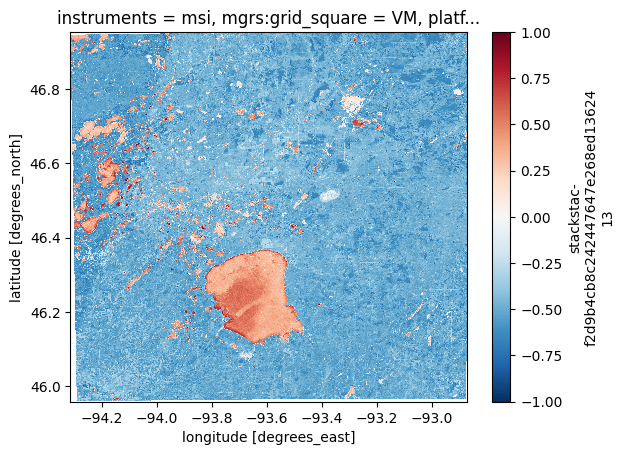

In [1176]:
import rioxarray as rxr

# Get water mask, get intersection with pit lakes as positive
# Reproject  
water_mask = annual_median.rio.write_crs('epsg:32615', inplace=True)
water_mask = water_mask.rio.reproject('epsg:4326')
water_mask = xr.where(water_mask > 0.1, 1, 0)

Label water

In [760]:
# Re-label bounding boxes with water mask
# If bbox indicates pit lake & NDWI indicates water, label as positive. Else, negative

# If pixel is labeled 1, check whether raster is 1 or 0
# Resample water mask to match polygons
water_mask_resampled = resample_raster(
        src2, 
        target_transform=transform1,
        target_shape=raster1.shape,
        resampling=Resampling.nearest
    )

# Get the corresponding pixel values from the second raster
mask = bboxs_raster == 1
bboxs_raster[mask] = water_mask_resampled[mask]

rasterio.plot.show(bboxs_raster)

#rasters.append(bboxs_raster)
#embs_with_polys()

# Add the statistics to the vector data
#testing = mn_qa_bboxs.join(pd.DataFrame(water_mask_chips))
#testing.columns
#mn_data = mn_data.join(pd.DataFrame(water_mask_chips))



TypeError: invalid path or file: <xarray.DataArray 'stackstac-f2d9b4cb8c242447647e268ed1362413' (y: 2745, x: 2745)> Size: 30MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates: (12/25)
  * x                                        (x) float64 22kB 4e+05 ... 5.097...
  * y                                        (y) float64 22kB 5.2e+06 ... 5.0...
    grid:code                                <U10 40B 'MGRS-15TVM'
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'T'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    proj:transform                           object 8B {0, 10, 5200020, -10, ...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    epsg                                     int32 4B 32615
    s2:snow_ice_percentage                   int32 4B 0
    s2:degraded_msi_data_percentage          int32 4B 0
    spatial_ref                              int32 4B 0

In [25]:
# Get chips with pit lakes and regular bodies of water in MN from QA
mn_data = LabelEmbeddings(mine_embeddings_mn, lake_embeddings_mn, mn_qa_polys, dnr_water_cropped)
print(f"Total samples: {len(mn_data)}") 


# Get chips for features identified as not lakes from QA
mn_nonlakes_chips = LabelEmbeddings(dummy, qa_non_mine_embeddings_mn, gpd.GeoDataFrame(), mn_qa_nonlakes)
print(f"Total samples: {len(mn_nonlakes_chips)}") 

mn_data = pd.concat([mn_data,mn_nonlakes_chips], ignore_index=True) # Add lakes to MN embeddings

Number of positive samples:
4317
Total samples: 28841
Number of positive samples:
0
Total samples: 2592


### PCA and tSNE

In [63]:
# Define function to get principle components and plot with data for each embedding

def EmbeddingsPCA(data, column = 'embeddings'):
    """
    
    Parameters: 
    data (GeoDataFrame):
    column (str): column of data with variable

    """
    # Convert embeddings to array and do PCA
    X =  np.vstack(data[column].values)
    pca = PCA(n_components=1)
    pca.fit(X)

    # Check on variance explained by given # of dimensions of PCA
    print("Relative variance in principal components:", pca.explained_variance_ratio_)

    # Apply PCA to get first two dimensions
    data['pca1'] = pca.transform(X)[:, 0]
    #data['pca2'] = pca.transform(X)[:, 1]

    return data

In [65]:
def PCAVisualization(data, column, label1, label2):
    # Visualize the first two principal components with category color-coding
    fig, ax = plt.subplots()

    # Plot for category 1
    ax.scatter(data[data[column] == True]['pca1'], 
                data[data[column] == True]['pca2'], 
                color='blue', label=label1, alpha=0.5)

    # Plot for category 2
    ax.scatter(data[data[column] == False]['pca1'], 
                data[data[column] == False]['pca2'], 
                color='grey', label=label2, alpha=0.05)
    
    """ EDIT SO CAN SEE WHAT THE LITTLE OVERLAP IS  plt.scatter(data[data['wb_'] == new_condition]['pca1'], 
            data[data[new_class_column] == new_condition]['pca2'], 
            color='red', label=label3, alpha=0.5, marker='^') """

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    ax.legend()
    plt.title('PCA of NAIP Embeddings')

    return ax

Relative variance in principal components: [0.20246004 0.11758959 0.09478324]


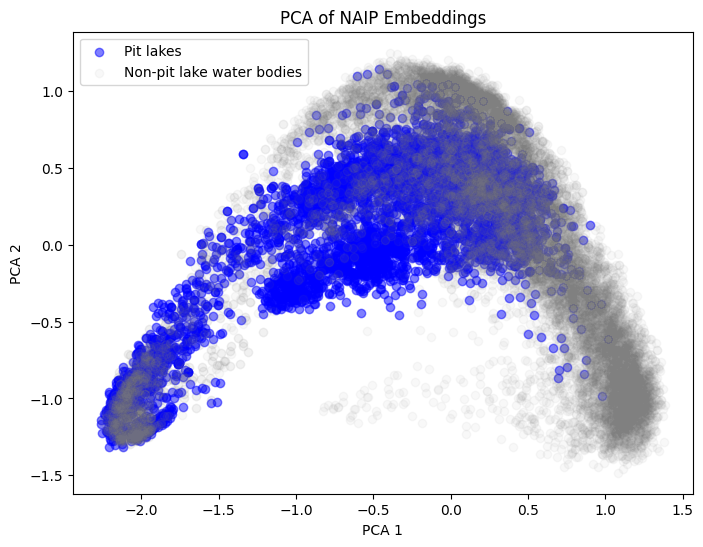

In [128]:
mn_pca = EmbeddingsPCA(mn_data)
PCAVisualization(mn_pca, column = 'mine', label1 = 'Pit lakes', label2 = 'Non-pit lake water bodies')

Relative variance in principal components: [0.19072938 0.11326633 0.09525669]


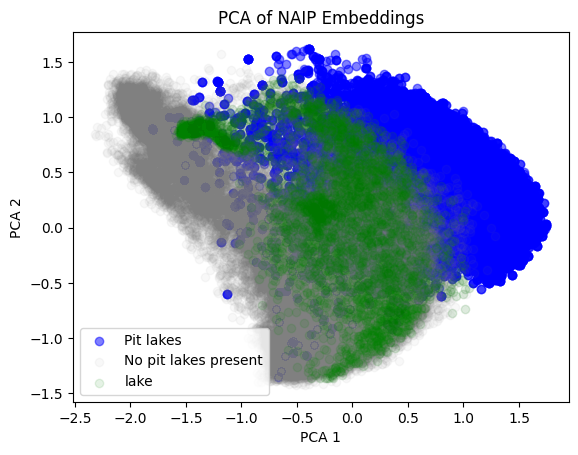

In [203]:
az_pca = EmbeddingsPCA(az_data)
ax = PCAVisualization(az_pca, 'mine','Pit lakes', 'No pit lakes present')

end_idx = len(az_pca)-1
start_idx = end_idx-len(az_lakes_chips)

ax.scatter(az_pca[start_idx:end_idx]['pca1'], 
                az_pca[start_idx:end_idx]['pca2'],
                color='green', label = 'lake', alpha = 0.1)

ax.legend()
plt.show()

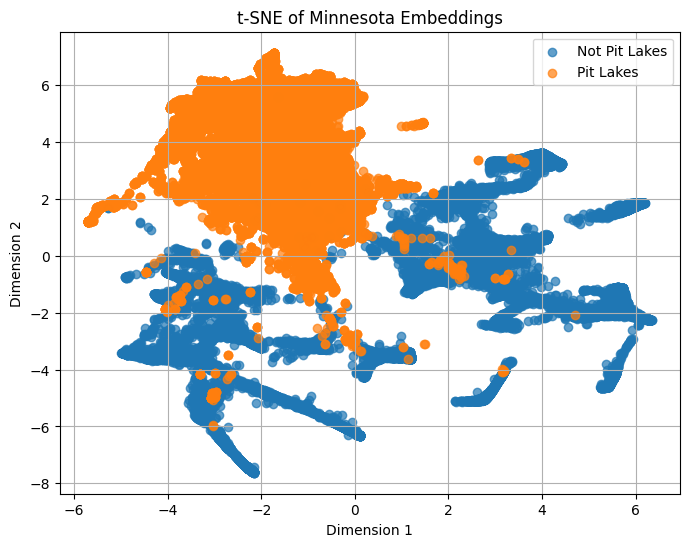

In [ ]:
#t-SNE of positive/negative embeddings

labels = data['mine'].values

tsne_data = np.vstack(data['embeddings'].values)

# Set up t-SNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=250)
reduced_embeddings = tsne.fit_transform(tsne_data)

# Visualize the results
plt.figure(figsize=(8, 6))

custom_labels = {0: "Not Pit Lakes", 1: "Pit Lakes"}

for label in np.unique(labels):
    mask = labels == label
    plt.scatter(reduced_embeddings[mask, 1],
                reduced_embeddings[mask, 0],
                label=custom_labels.get(label, f"Label {label}"),
                alpha=0.7)

plt.title("t-SNE of Minnesota Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

### Build classification model to predict presence of pit lakes

In [133]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection')
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data
    intersecting['area_overlap'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['area_overlap'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['area_overlap'] / row.geometry.area
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['area_overlap']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

#### Minnesota & Indiana

In [1159]:
# Get MN, IN, KY data
in_mn_data = pd.concat([in_data, mn_data])
north_data = pd.concat([in_mn_data, ky_data])
in_mn_pits = pd.concat([mn_aggregated_pits, in_qa_pits])
north_pits = pd.concat([in_mn_pits, ky_qa_pits])

# Check if intersection of each chip with a pit lake polygon is > 0.5%
in_mn_data_marked = MarkSamples(north_data, north_pits, 0.006)
print((in_mn_data_marked['mine']==1).sum())
print(len(in_mn_data_marked))

# Split into train and test
in_mn_data_marked_reset = in_mn_data_marked.reset_index(drop=True)
in_mn_train_embeddings = np.vstack(in_mn_data_marked_reset['embeddings'].values)
in_mn_labels = np.array(in_mn_data_marked_reset['mine'])
in_mn_indices = in_mn_data_marked_reset.index

in_mn_X_train, in_mn_X_test, in_mn_y_train, in_mn_y_test, in_mn_train_idx, in_mn_test_idx = sklearn.model_selection.train_test_split(in_mn_train_embeddings, in_mn_labels, in_mn_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(in_mn_X_train))
print(np.shape(in_mn_X_test))
print(np.shape(in_mn_y_train))
print(np.shape(in_mn_y_test))

73
284
(213, 1024)
(71, 1024)
(213,)
(71,)


In [1157]:
# Train neural network model for IN and MN
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=mn_y_train)

# Convert the class weights to a dictionary
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

in_mn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 1000, 
                    random_state=1)

in_mn_clf.fit(in_mn_X_train, in_mn_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=1000,
              random_state=1, solver='lbfgs')

In [1167]:
# Run predictions on test set and get F1 scores and probabilities

in_mn_predictions = in_mn_clf.predict(in_mn_X_test) 
print(f'Number of positive predictions: {in_mn_predictions.sum()}')
print(f'Number of positive samples: {in_mn_y_test.sum()}')
print(f'Number of test samples: {len(in_mn_X_test)}')

f1 = sklearn.metrics.f1_score(in_mn_y_test, in_mn_predictions)
print(f'F1: {f1}')

in_mn_precision = sklearn.metrics.precision_score(in_mn_y_test, in_mn_predictions)
print(f'precision: {in_mn_precision}')

in_mn_recall = sklearn.metrics.recall_score(in_mn_y_test, in_mn_predictions)
print(f'recall: {in_mn_recall}')

in_mn_probabilities = in_mn_clf.predict_proba(in_mn_X_test)
print(f'Classes for probability: {in_mn_clf.classes_}')

in_mn_probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 17
Number of positive samples: 10
Number of test samples: 71
F1: 0.6666666666666666
precision: 0.5294117647058824
recall: 0.9
Classes for probability: [0 1]


array([8.05888043e-217, 2.94808214e-216, 4.53281603e-072, 7.87145416e-126,
       0.00000000e+000, 1.00000000e+000, 3.19583473e-135, 1.00000000e+000,
       1.38712262e-171, 0.00000000e+000, 0.00000000e+000, 1.50086835e-022,
       0.00000000e+000, 1.00000000e+000, 7.31327158e-029, 0.00000000e+000,
       6.02577278e-130, 1.00000000e+000, 1.29094781e-104, 1.91613475e-197,
       1.91062182e-020, 4.67386347e-087, 0.00000000e+000, 7.63321020e-134,
       6.88392065e-272, 1.44228133e-153, 1.00357201e-149, 0.00000000e+000,
       1.86504036e-188, 9.99942248e-001, 1.10683529e-092, 1.12686605e-024,
       5.00271909e-001, 5.86714004e-008, 1.29087522e-066, 1.51878320e-153,
       5.89104594e-091, 1.00000000e+000, 1.00000000e+000, 7.45965083e-147,
       4.41728759e-025, 4.63402464e-218, 1.17766616e-106, 1.20544534e-166,
       0.00000000e+000, 1.00000000e+000, 3.17997317e-087, 4.98721524e-001,
       1.09788919e-253, 1.40279180e-130, 1.00000000e+000, 9.99998798e-001,
       4.39473694e-234, 2

In [1161]:
# Write predictions and probabilities to shapefiles
in_mn_pits_geom = in_mn_data_marked_reset.loc[in_mn_test_idx].geometry.reset_index(drop = True)

in_mn_pits_pred = gpd.GeoDataFrame(in_mn_predictions, columns = ['mines'], geometry=in_mn_pits_geom, crs = 'EPSG:4326')
in_mn_pits_probs = gpd.GeoDataFrame(in_mn_probabilities[:,1], columns = ['mine_prob'], geometry=in_mn_pits_geom, crs = 'EPSG:4326')

in_mn_pits_probs.to_file('north_pits_probs_0112')

In [1168]:
import joblib
joblib.dump(in_mn_clf, 'data/NorthPitLakeClf0112.pkl')

['data/NorthPitLakeClf0112.pkl']

#### Minnesota

In [979]:
# Check if intersection of each chip with a pit lake polygon is > 0.5%
mn_data_marked = MarkSamples(mn_data, mn_aggregated_pits, 0.005)
print((mn_data_marked['mine']==1).sum())
print(len(mn_data_marked))


17
199


In [975]:
mn_data_marked.to_file('mn_coverage_check_112')

PermissionError: [WinError 5] Access is denied: 'mn_coverage_check_112'

In [980]:
# Split into train and test for MN

mn_data_marked_reset = mn_data_marked.reset_index(drop=True)
mn_train_embeddings = np.vstack(mn_data_marked_reset['embeddings'].values)
mn_labels = np.array(mn_data_marked_reset['mine'])
mn_indices = mn_data_marked_reset.index

mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = sklearn.model_selection.train_test_split(mn_train_embeddings, mn_labels, mn_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(mn_X_train))
print(np.shape(mn_X_test))
print(np.shape(mn_y_train))
print(np.shape(mn_y_test))

(149, 1024)
(50, 1024)
(149,)
(50,)


In [981]:
# Train neural network model
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=mn_y_train)

# Convert the class weights to a dictionary
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

mn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(32, 32, 32), max_iter = 1000, 
                    random_state=1)

mn_clf.fit(mn_X_train, mn_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(32, 32, 32), max_iter=1000,
              random_state=1, solver='lbfgs')

In [982]:
# Run predictions on test set and get F1 scores and probabilities

mn_predictions = mn_clf.predict(mn_X_test) 
print(f'Number of positive predictions: {mn_predictions.sum()}')
print(f'Number of positive samples: {mn_y_test.sum()}')
print(f'Number of test samples: {len(mn_X_test)}')

f1 = sklearn.metrics.f1_score(mn_y_test, mn_predictions)
print(f'F1: {f1}')

mn_precision = sklearn.metrics.precision_score(mn_y_test, mn_predictions)
print(f'precision: {mn_precision}')

mn_probabilities = mn_clf.predict_proba(mn_X_test)
print(f'Classes for probability: {mn_clf.classes_}')

mn_probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 2
Number of positive samples: 4
Number of test samples: 50
F1: 0.3333333333333333
precision: 0.5
Classes for probability: [0 1]


array([1.02009359e-28, 5.03049654e-28, 7.97883660e-20, 3.35324498e-39,
       1.56373802e-31, 6.72526301e-08, 2.18372357e-38, 1.99079583e-31,
       3.15851236e-05, 1.03675848e-21, 1.62368943e-29, 1.76737073e-37,
       3.44555294e-39, 8.71180028e-36, 6.69626196e-37, 7.97883660e-20,
       5.61224957e-31, 5.54907309e-37, 1.44059856e-06, 2.71919827e-30,
       1.67027218e-28, 1.34087444e-42, 1.01239331e-28, 3.89998394e-38,
       6.74411898e-24, 2.32040096e-35, 7.75291951e-36, 2.34880048e-43,
       1.10558750e-29, 1.04282763e-22, 2.50092666e-36, 3.95125575e-38,
       2.69146350e-20, 1.15367044e-36, 9.99953708e-01, 2.00015036e-36,
       4.48396169e-13, 1.04057098e-34, 1.16799767e-36, 3.35894048e-13,
       1.85717507e-31, 2.71919827e-30, 1.00000000e+00, 7.66341445e-41,
       2.81632049e-07, 7.80475687e-37, 3.97393787e-40, 2.41560560e-17,
       1.61266950e-36, 3.73356550e-34])

In [166]:
import joblib
joblib.dump(mn_clf, 'data/MNPitLakeClf0109.pkl')

['data/MNPitLakeClf0109.pkl']

In [966]:
# Write predictions and probabilities to shapefiles
mn_pits_geom = mn_data_marked_reset.loc[mn_test_idx].geometry.reset_index(drop = True)

mn_pits_pred = gpd.GeoDataFrame(mn_predictions, columns = ['mines'], geometry=mn_pits_geom, crs = 'EPSG:4326')
mn_pits_probs = gpd.GeoDataFrame(mn_probabilities[:,1], columns = ['mine_prob'], geometry=mn_pits_geom, crs = 'EPSG:4326')

mn_pits_probs.to_file('mn_pits_probs_0112')

F1 on training data: 0.8888888888888888
Accuracy on training data: 0.9731543624161074
Accuracy on test data: 0.9


<Axes: >

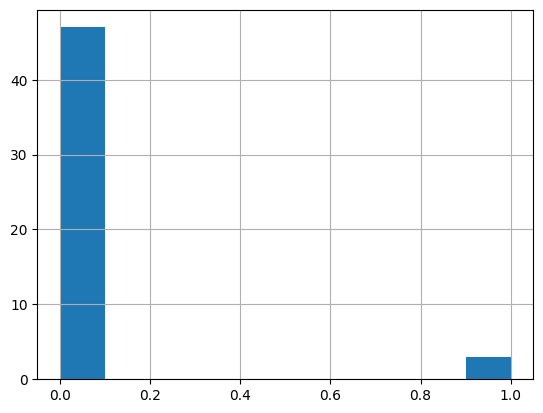

In [967]:
mn_train_predictions = mn_clf.predict(mn_X_train)

mn_f1_train = sklearn.metrics.f1_score(mn_y_train, mn_train_predictions)
print(f'F1 on training data: {mn_f1_train}')

mn_train_accuracy = sklearn.metrics.accuracy_score(mn_y_train, mn_train_predictions)
mn_test_accuracy = sklearn.metrics.accuracy_score(mn_y_test, mn_predictions)
print(f'Accuracy on training data: {mn_train_accuracy}')
print(f'Accuracy on test data: {mn_test_accuracy}')

# Plot histogram of probability predictions on test set
test_probs = pd.DataFrame(mn_probabilities)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
test_probs[1].hist(bins = bins)

Number of images:
38
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
geometries calculated
chips found
next zone
geometries calculated
chips found
2295
Number of positive samples:
15
Total samples:
15


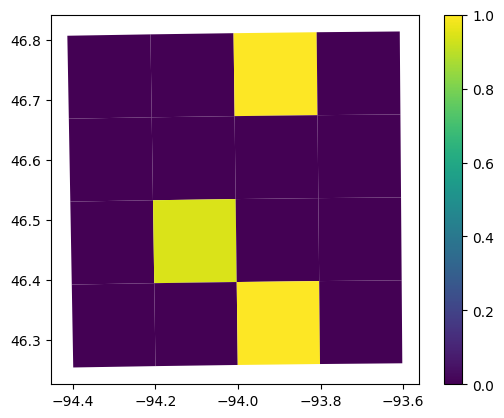

In [968]:
# Get embeddings for Crosby, MN
crosby_pitlakes = gpd.read_file('data/crosby_mn.geojson') # all Crosby

crosby_embeddings, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = crosby_pitlakes, random_images = False)

print("Number of images:")
print(len(crosby_embeddings))

# Get Crosby test chips
crosby_embeddings = pd.DataFrame(crosby_embeddings)
crosby_embs_avg = MonthlyComposite(crosby_embeddings)
print(len(crosby_embs_avg))
crosby_test_chips = LabelEmbeddings1_5(crosby_embs_avg, dummy, crosby_pitlakes) #  getting all Crosby, not just pit lakes

print("Total samples:") 
print(len(crosby_test_chips))

crosby_test = np.vstack(crosby_test_chips['embeddings'].values) 

crosby_test_preds = gpd.GeoDataFrame(mn_clf.predict(crosby_test), columns = ['mine'], geometry = crosby_test_chips['geometry'])
crosby_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(crosby_test)[:,1], columns = ['mine_prob'], geometry=crosby_test_chips['geometry'], crs = 'EPSG:4326')

crosby_test_probs.plot(column = 'mine_prob', legend = True)

# Write Crosby predictions to shapefile
crosby_test_probs.to_file('crosby_testing_0112')

<Axes: >

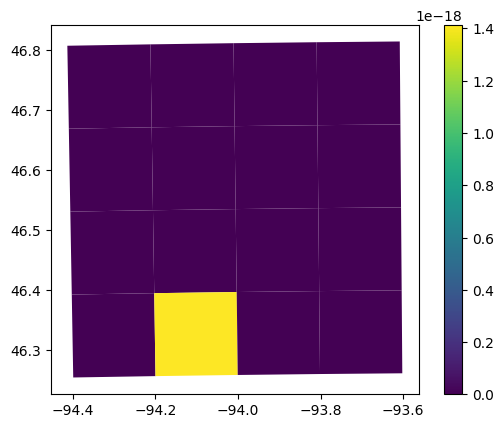

In [1171]:
# Test with IN and MN combined model

crosby_test_preds = gpd.GeoDataFrame(in_mn_clf.predict(crosby_test), columns = ['mine'], geometry = crosby_test_chips['geometry'])
crosby_test_probs = gpd.GeoDataFrame(in_mn_clf.predict_proba(crosby_test)[:,1], columns = ['mine_prob'], geometry=crosby_test_chips['geometry'], crs = 'EPSG:4326')

crosby_test_probs.plot(column = 'mine_prob', legend = True)

# Write Crosby predictions to shapefile
#crosby_test_probs.to_file('crosby_testing_0112_no')

In [1165]:
(crosby_test_preds['mine']==1).sum()

dnr_pit_lakes_crosby = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

crosby_pits = gpd.sjoin(dnr_pit_lakes_crosby, crosby_pitlakes, how='inner', predicate = 'intersects')

crosby_marked = MarkSamples(crosby_test_chips, crosby_pits, 0.002)

print(crosby_marked['mine'].sum())
len(crosby_test_probs)

2


15

In [131]:
# Get embeddings for MI
mi_qa = gpd.read_file('data/mi_testing.geojson')

mi_qa_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_qa, random_images = False)

print("Number of images:")
print(len(mi_qa_embeddings))

# Get MI test chips
mi_test_chips = LabelEmbeddings(mi_qa_embeddings, dummy, mi_qa)

print("Total samples:") 
print(len(mi_test_chips))

mi_test = np.vstack(mi_test_chips['embeddings'].values) 

mi_test_preds = gpd.GeoDataFrame(mn_clf.predict(mi_test), columns = ['mine'], geometry = mi_test_chips['geometry'])
mi_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(mi_test)[:,1], columns = ['mine_prob'], geometry=mi_test_chips['geometry'], crs = 'EPSG:4326')

# Write Crosby predictions to shapefile
mi_test_probs.to_file('mi_testing_1218')

NameError: name 'GetEmbeddingsFromIntersection' is not defined

#### Test on MI lakes vs. pit lakes

29
14


<Axes: >

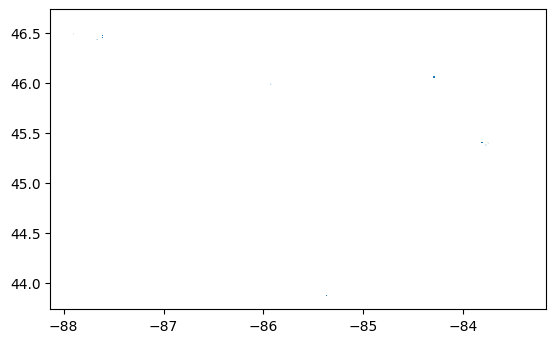

In [ ]:
# Get lake data - filter out pit lakes

mi_lakes = gpd.read_file('data/mi_Lake_Polygons.geojson').to_crs(epsg = 4326)
states = gpd.read_file('data/state_boundaries')
mi = states[states['STUSPS']=='MI']
mi = mi.to_crs(epsg = 4326).geometry.unary_union 
mi_qa = US_QA[US_QA.geometry.intersects(mi)]

mi_qa_pits = mi_qa[mi_qa['category'].isin(['a','q'])] # QAed pit lakes and questionable
mi_lakes_polys = gpd.overlay(mi_lakes, mi_qa_pits, how = 'difference')
print(len(mi_lakes_polys))

# Get pit lake polygon intersections - keep polygons within pit lakes; otherwise keep bbox
mi_qa_polys = gpd.overlay(mi_qa_pits, mi_lakes, how = 'intersection')

bboxs_with_polygon = gpd.sjoin(mi_qa_pits, mi_lakes, how="left", predicate="intersects")
print(len(bboxs_with_polygon))

bboxs_without_polygon = bboxs_with_polygon[bboxs_with_polygon.index_right.isna()]
print(len(bboxs_without_polygon))

mi_qa_polys = pd.concat([mi_qa_polys, bboxs_without_polygon])
mi_qa_polys.plot()

In [ ]:
# Get intersecting embeddings, label these
mi_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_qa_polys, random_images = False)

print("Number of mine images:")
print(len(mi_embeddings))

# Crop
random_idx = random.sample(range(1, len(mi_lakes_polys)), 500)
mi_lakes_cropped = mi_lakes_polys.iloc[random_idx]

Number of mine images:
19
Number of water images: 19
Number of positive samples:
872
Total samples:
872


TypeError: '<' not supported between instances of 'Polygon' and 'int'

In [52]:
# Get lake intersecting embeddings
mi_water_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mi/rgbir_cog/', polygons = mi_lakes_cropped, random_images = False)
print(f"Number of water images: {len(mi_embeddings)}")

# Get MI test chips
mi_test_chips = LabelEmbeddings(mi_embeddings, mi_water_embeddings, mi_qa_polys, mi_lakes_cropped)

print("Total samples:") 
print(len(mi_test_chips))


# Predict on these
mi_test = np.vstack(mi_test_chips['embeddings'].values) 
mi_test_labels = mi_test_chips['mine']

mi_test_preds = gpd.GeoDataFrame(mn_clf.predict(mi_test), columns = ['mine'], geometry = mi_test_chips['geometry'])
mi_test_probs = gpd.GeoDataFrame(mn_clf.predict_proba(mi_test)[:,1], columns = ['mine_prob'], geometry=mi_test_chips['geometry'], crs = 'EPSG:4326')


Number of water images: 19
Number of positive samples:
872
Total samples:
5098


In [53]:
mi_test_preds_list = mn_clf.predict(mi_test)

mi_precision = sklearn.metrics.precision_score(mi_test_labels, mi_test_preds_list)
print(f'precision: {mi_precision}')

mi_f1 = sklearn.metrics.f1_score(mi_test_labels, mi_test_preds_list)
print(f'F1 on MI: {mi_f1}')

precision: 0.5163551401869159
F1 on MI: 0.34


In [54]:
# Write MI predictions to shapefile
mi_test_probs.to_file('mi_testing_1219_2p')


#### Arizona

In [681]:
# Mark as positive if intersection > 30% 
az_data_marked_reset = az_data.reset_index(drop=True)
az_data_marked = MarkSamples(az_data_marked_reset, az_qa_pits, 0.003)

print((az_data_marked['mine']==1).sum())

9


In [682]:
# Split into train and test for AZ

az_train_embeddings =  np.vstack(az_data_marked['embeddings'].values)
az_labels = np.array(az_data_marked['mine'])
az_indices = az_data_marked.index

az_X_train, az_X_test, az_y_train, az_y_test, az_train_idx, az_test_idx = sklearn.model_selection.train_test_split(az_train_embeddings, az_labels, az_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(az_X_train))
print(np.shape(az_X_test))
print(np.shape(az_y_train))
print(np.shape(az_y_test))

(33, 1024)
(11, 1024)
(33,)
(11,)


In [683]:
# Train neural network model

az_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 1000, random_state=1)

az_clf.fit(az_X_train, az_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=1000,
              random_state=1, solver='lbfgs')

In [684]:
az_predictions = az_clf.predict(az_X_test) 
print(f'Number of positive predictions: {az_predictions.sum()}')
print(f'Number of test samples: {len(az_X_test)}')

az_f1 = sklearn.metrics.f1_score(az_y_test, az_predictions)
print(f'F1: {f1}')

probabilities = az_clf.predict_proba(az_X_test)
print(f'Classes for probability: {az_clf.classes_}')

probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 0
Number of test samples: 11
F1: 0.4
Classes for probability: [0 1]


array([3.19449397e-075, 9.50345921e-021, 4.98229664e-069, 6.92748241e-011,
       8.26009032e-030, 6.35494906e-024, 3.35234941e-080, 7.34486729e-049,
       6.65294129e-016, 4.10331346e-101, 4.72361086e-032])

F1 on training data: 0.36666666666666664
Accuracy on training data: 0.9054726368159204
Accuracy on test data: 0.9029850746268657


<Axes: >

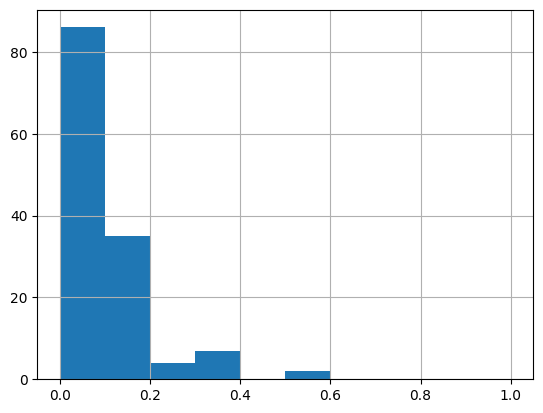

In [125]:
az_train_predictions = az_clf.predict(az_X_train)

az_f1_train = sklearn.metrics.f1_score(az_y_train, az_train_predictions)
print(f'F1 on training data: {az_f1_train}')

train_accuracy = sklearn.metrics.accuracy_score(az_y_train, az_train_predictions)
test_accuracy = sklearn.metrics.accuracy_score(az_y_test, az_predictions)
print(f'Accuracy on training data: {train_accuracy}')
print(f'Accuracy on test data: {test_accuracy}')

# Plot histogram of probability predictions on test set
test_probs = pd.DataFrame(probabilities)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
test_probs[1].hist(bins = bins)

In [126]:
# Write predictions and probabilities to shapefiles
az_pits_geom = az_data.geometry.loc[az_test_idx].reset_index(drop = True)
az_pits_pred = gpd.GeoDataFrame(az_predictions, columns = ['mines'], geometry=az_pits_geom, crs = 'EPSG:4326')
az_pits_probs = gpd.GeoDataFrame(probabilities[:,1], columns = ['mine_prob'], geometry=az_pits_geom, crs = 'EPSG:4326')

#az_pits_pred.to_file('az_pits_pred_1')
az_pits_probs.to_file('az_pits_probs_0108')

KeyError: '[512, 529, 524, 500, 526, 503, 530] not in index'

In [ ]:
# Get embeddings for Miami, AZ pitlakes
miami_pitlakes = gpd.read_file('data/miami_az_pits.geojson')

miami_embeddings, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_az/rgbir_cog/', polygons = miami_pitlakes, random_images = False)

print("Number of images:")
print(len(miami_embeddings))

# Get test chips in AZ
miami_test_chips = LabelEmbeddings(miami_embeddings, dummy, miami_pitlakes)

print("Total samples:") 
print(len(miami_test_chips))

miami_test = np.vstack(miami_test_chips['embeddings'].values) 

miami_test_preds = gpd.GeoDataFrame(az_clf.predict(miami_test), columns = ['mine'], geometry = miami_test_chips['geometry'])
miami_test_probs = gpd.GeoDataFrame(az_clf.predict_proba(miami_test)[:,1], columns = ['mine_prob'], geometry=miami_test_chips['geometry'], crs = 'EPSG:4326')

miami_test_probs.to_file('miami_az_testing_heldout_1216')
miami_test_probs

Random images: 0
Number of images:
12
Number of positive samples:
10836
Total samples:
10836


mine_prob                                           geometry
0      1.000000e+00  POLYGON ((-110.93859 33.46812, -110.9386 33.46...
1      1.000000e+00  POLYGON ((-110.93694 33.46812, -110.93694 33.4...
2      1.000000e+00  POLYGON ((-110.93529 33.46812, -110.93529 33.4...
3      9.999144e-01  POLYGON ((-110.93363 33.46812, -110.93364 33.4...
4      1.000000e+00  POLYGON ((-110.93198 33.46811, -110.93198 33.4...
...             ...                                                ...
10831  8.016509e-13  POLYGON ((-111.00417 33.36248, -111.00417 33.3...
10832  2.837483e-04  POLYGON ((-111.00252 33.36248, -111.00252 33.3...
10833  9.337610e-01  POLYGON ((-111.00087 33.36248, -111.00087 33.3...
10834  9.989062e-01  POLYGON ((-110.99922 33.36248, -110.99922 33.3...
10835  1.000000e+00  POLYGON ((-110.99756 33.36248, -110.99756 33.3...

[10836 rows x 2 columns]

In [118]:
az_mines_intersect.to_file('mines_polys')

### REST OF NOTEBOOK IN DRAFT

#### Visualize a few mines

In [14]:
# Point over mine in Hibbing, Minnesota

lat, lon = 47.362228, -93.046666

# AOI around pt
""" aoi_as_list = [[-87.09601677899997,39.685325944000056],
      [-87.19601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056],
      [-87.09601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056]] """

""" aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
} """

# Date range
start = "2021-01-01"
end = "2021-12-31"

In [16]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-3, lat - 1e-3, lon + 1e-3, lat + 1e-3),
    max_items=1,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


In [ ]:
# Retrieve the items
assets = []
assets_urls = []
item_latlons = []
item_bboxs = []

# Show 'visual' asset for true-color composite and create list of images
for item in items:
    asset = item.assets["visual"]
    assets.append(asset)
    assets_urls.append(asset.href)
    print(item.datetime)
    # Get centroids of images and create buffer polygons
    image_geom = Polygon(item.geometry['coordinates'][0])
    item_latlons.append(gpd.GeoDataFrame(geometry = [image_geom]).centroid)

for item in item_latlons:
    item_bboxs.append(item.buffer(0.2))
    print(item_bboxs)


2021-11-20 17:20:34.917000+00:00
[0    POLYGON ((-93.39776 47.35737, -93.39872 47.337...
dtype: geometry]


In [39]:
help(items[0])

Help on Item in module pystac.item object:

class Item(pystac.stac_object.STACObject, pystac.asset.Assets)
 |  Item(id: 'str', geometry: 'dict[str, Any] | None', bbox: 'list[float] | None', datetime: 'Datetime | None', properties: 'dict[str, Any]', start_datetime: 'Datetime | None' = None, end_datetime: 'Datetime | None' = None, stac_extensions: 'list[str] | None' = None, href: 'str | None' = None, collection: 'str | Collection | None' = None, extra_fields: 'dict[str, Any] | None' = None, assets: 'dict[str, Asset] | None' = None)
 |
 |  An Item is the core granular entity in a STAC, containing the core metadata
 |  that enables any client to search or crawl online catalogs of spatial 'assets' -
 |  satellite imagery, derived data, DEM's, etc.
 |
 |  Args:
 |      id : Provider identifier. Must be unique within the STAC.
 |      geometry : Defines the full footprint of the asset represented by this
 |          item, formatted according to
 |          `RFC 7946, section 3.1 (GeoJSON) <ht

In [35]:
item_bboxs_gpd = gpd.GeoDataFrame(geometry = item_bboxs[0],crs=4326)


In [ ]:
# Crop images - NEED TO FIX
from rasterio.mask import mask

with rasterio.open(assets_urls[0]) as src:
    cropped_image, cropped_transform = mask(src, item_bboxs_gpd[0].geometry, crop=True)

cropped_image_data = cropped_image 
cropped_image_transform = cropped_transform 

""" with rasterio.open("tests/data/RGB.byte.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta """

KeyError: 0

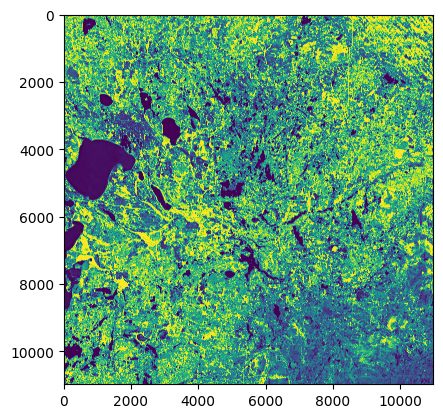

In [33]:
# Load and visualize the asset with rasterio

fig, ax = plt.subplots()

# Create image plotting function

src1 = rasterio.open(assets_urls[0])
#src2 = rasterio.open(assets_urls[1])
    
ax.imshow(src1.read(1))
#ax2.plt.imshow(src2.read(1))
plt.show()


### Find data for AOI
The first step is to find STAC items of imagery that we want to use to create embeddings. In this example we are going to use Earth Genome's composite dataset which comes with a great STAC catalog.

We are also going to create embeddings along time so that we have multiple embeddings for the same location at different moments in time.

In [ ]:
# Point over Nevada
# lat, lon = 39.145068721560506, -119.67465363188465

# AOI around Nevada
aoi_as_list = [[-119.1256714,39.6620962],
      [-119.1302491,39.5669496],
      [-118.959961,39.5500181],
      [-118.9544679,39.638862],
      [-119.1247559,39.6578851],
      [-119.1256714,39.6620962]]

aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
}

# Date range
start = "2018-07-01"
end = "2018-09-01"

In [32]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    intersects=aoi_as_dict, # CHANGED TO GET ONLY IMAGES INTERSECTING WITH AOI
    max_items=2,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


To speed up processing in this example, we limit the number of chips to 3 per Sentinel-2 scene. Remove this limit in a real use case.

In [ ]:
chips = []
datetimes = []
bboxs = []
chip_ids = []
item_ids = []

# Adjust desired chip dimension (pixels) 
# chip_dimension = int(224)
# stacchip.indexer.ChipIndexer.chip_size = chip_dimension # Edit default class chip size attribute
# Sentinel2Indexer.chip_size = chip_dimension

for item in items:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = Sentinel2Indexer(item)

    # Instanciate the chipper
    chipper = Chipper(indexer, assets=["red", "green", "blue", "nir", "scl"])

    # Get first chip for the "image" asset key
    for idx, (x, y, chip) in enumerate(chipper):
        #if idx > 3: # Remove this for full inference
        #    break
        del chip["scl"]
        chips.append(chip)
        datetimes.append(item.datetime)
        bboxs.append(indexer.get_chip_bbox(x, y))
        chip_ids.append((x, y))
        item_ids.append(item.id)

Working on <Item id=S2B_11SLD_20180825_1_L2A>


RasterioIOError: Read or write failed. /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LD/2018/8/S2B_11SLD_20180825_1_L2A/B04.tif, band 1: IReadBlock failed at X offset 2, Y offset 1: TIFFReadEncodedTile() failed.

In [149]:
# Drop chips that don't intersect and corresponding chips, datetimes, chip IDs, and item IDs

bboxs_gdf = gpd.GeoDataFrame(geometry=bboxs)
aoi = Polygon(aoi_as_list)

mask = bboxs_gdf.intersects(aoi) # Create mask of bboxs of chips that intersect the AOI

chips = pd.Series(chips)[mask].tolist()
datetimes = pd.Series(datetimes)[mask].tolist()
bboxs = pd.Series(bboxs)[mask].tolist()
chip_ids = pd.Series(chip_ids)[mask].tolist()
item_ids = pd.Series(item_ids)[mask].tolist()

print("Number of chips that intersect with AOI: ")
print(len(chips))

Number of chips that intersect with AOI: 
4


In [150]:
pixels = np.array([np.array(list(chip.values())).squeeze() for chip in chips])
pixels.shape

(4, 4, 256, 256)

In [1]:
#Visualize chips

gpd.GeoDataFrame(geometry = bboxs).plot()

NameError: name 'gpd' is not defined

Prepare band metadata for passing it to the model

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
# Retrieve the file content from the URL

url = (
    "https://raw.githubusercontent.com/Clay-foundation/model/main/configs/metadata.yaml"
)
response = requests.get(url, allow_redirects=True)

# Convert bytes to string
content = response.content.decode("utf-8")

# Load the yaml
content = yaml.safe_load(content)

metadata = Box(content)
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in chips[0].keys():
    mean.append(metadata[platform].bands.mean[band])
    std.append(metadata[platform].bands.std[band])
    waves.append(metadata[platform].bands.wavelength[band])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

Convert the band pixel data into the format for the model

In [ ]:
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding by normalizing centroids of chip bboxs
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = []

for bbox in bboxs:
    centroid = bbox.centroid
    lat, lon = centroid.y, centroid.x  # Extract lat, lon from centroid
    latlons.append(normalize_latlon(lat, lon))

#latlons = [normalize_latlon(lat, lon)] * len(times) # WHY DO WE WANT THE SAME THING REPEATED?
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Prep gsd
gsd = [10]

# Normalize pixels
pixels = transform(pixels)
pixels = pixels.astype(np.float32) # ADDED THIS BACK IN


In [ ]:
datacube = {
    "pixels": torch.tensor(pixels, dtype=torch.float32),
    "time": torch.tensor(np.hstack((week_norm, hour_norm)), dtype=torch.float32),
    "latlon": torch.tensor(np.hstack((lat_norm, lon_norm)), dtype=torch.float32),
    "waves": torch.tensor(waves, dtype=torch.float32),
    "gsd": torch.tensor(gsd, dtype=torch.float32),
}

In [ ]:
for k, v in datacube.items():
    print(k, v.shape)

pixels torch.Size([2, 4, 256, 256])
time torch.Size([2, 4])
latlon torch.Size([2, 4])
waves torch.Size([4])
gsd torch.Size([1])


### Clay Embedder

#### Load the embedder that is stored in ExportedProgram format using **cpu**.

#### Load and run the checkpoint of the model

In [36]:
import pytorch_lightning as pl
# Add LightningModule class inheritance to access load_from_checkpoint method
#class ClayMAE(pl.LightningModule): 
#    pass

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://huggingface.co/made-with-clay/Clay/resolve/main/clay_v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

RuntimeError: Unknown model (vit_large_patch14_reg4_dinov2)

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [139]:
# Run the clay encoder
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = clay_encoder(*datacube)
# Get class embeddings
cls_embedding = unmsk_patch[:, 0, :]
# Print shape of class embeddings
cls_embedding.shape

NameError: name 'clay_encoder' is not defined

#### Load and run the exported cpu model

In [ ]:
# Get file from local exportedprogram format

! wget -q https://huggingface.co/made-with-clay/Clay/blob/main/v1.5/compiled/clay-v1.5-encoder-cpu.pt2

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
ep_embedder_cpu = torch.export.load("data/clay-v1.5-encoder-cpu.pt2").module()

Run the model with EP

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: total: 11.8 s
Wall time: 9.1 s


(torch.Size([2, 4, 256, 256]), torch.Size([2, 768]))

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ExportedProgram format using **gpu**.

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder.pt2

In [ ]:
datacube = {k: v.to("cuda") for k, v in datacube.items()}
ep_embedder = torch.export.load("clay-v1-encoder.pt2").module()

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder(datacube)
datacube["pixels"].shape, embeddings.shape

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ONNX format using **cpu**.

In [ ]:
import onnxruntime as ort

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder-cpu.onnx

In [ ]:
datacube = {k: v.to("cpu") for k, v in datacube.items()}
onnx_embedder = ort.InferenceSession(
    "clay-v1-encoder-cpu.onnx", providers=["CPUExecutionProvider"]
)

In [ ]:
%%time
embeddings = onnx_embedder.run(
    [],
    {
        "cube": datacube["pixels"].numpy(),
        "time": datacube["time"].numpy(),
        "latlon": datacube["latlon"].numpy(),
        "waves": datacube["waves"].numpy(),
        "gsd": datacube["gsd"].numpy(),
    },
)[0]
embeddings.shape

For each chip, we have an embedding of size `768`

### Store the results

We create a table containing the embeddings, bounding box, the STAC item ID, the datetime of the image capture, and the chip x and y ids. Then we save that data to disk.

In [ ]:
# Write data to pyarrow table
index = {
    "datetimes": datetimes,
    "chip_ids": chip_ids,
    "item_ids": item_ids,
    "embeddings": [np.ascontiguousarray(dat) for dat in embeddings],
    "geometry": ga.as_geoarrow([dat.wkt for dat in bboxs]),
}
table = pa.table(index)
table

pyarrow.Table
datetimes: timestamp[us, tz=UTC]
chip_ids: list<item: int64>
  child 0, item: int64
item_ids: string
embeddings: list<item: float>
  child 0, item: float
geometry: extension<geoarrow.polygon<PolygonType>>
----
datetimes: [[2018-08-25 18:53:24.597000Z,2018-08-25 18:53:24.597000Z]]
chip_ids: [[[1,0],[2,0]]]
item_ids: [["S2B_11SLD_20180825_1_L2A","S2B_11SLD_20180825_1_L2A"]]
embeddings: [[[-0.12739897,0.06501336,-0.0043061064,0.093552634,0.15224756,...,0.048478447,-0.17023225,0.04420602,-0.18251786,-0.04366695],[-0.09462359,0.08339551,-0.030247303,0.114174575,0.17728658,...,0.044083178,-0.14688866,0.057765294,-0.17931639,-0.0330391]]]
geometry: [[[      -- is_valid: all not null
      -- child 0 type: double
[-118.9754053793589,-118.97146936387814,-119.15024167776343,-119.15453396559633,-118.9754053793589]
      -- child 1 type: double
[39.73345718524536,39.59514085820176,39.59196881845574,39.730269624751166,39.73345718524536]],[      -- is_valid: all not null
      -- child

In [ ]:
pq.write_table(table, "embeddings.parquet")

                         datetimes chip_ids                  item_ids  \
0 2018-08-25 18:53:24.597000+00:00   (1, 0)  S2B_11SLD_20180825_1_L2A   
1 2018-08-25 18:53:24.597000+00:00   (2, 0)  S2B_11SLD_20180825_1_L2A   

                                          embeddings  \
0  [-0.12739897, 0.06501336, -0.0043061064, 0.093...   
1  [-0.09462359, 0.08339551, -0.030247303, 0.1141...   

                                            geometry  
0  POLYGON ((-118.97541 39.73346, -118.97147 39.5...  
1  POLYGON ((-118.79625 39.73637, -118.79267 39.5...  


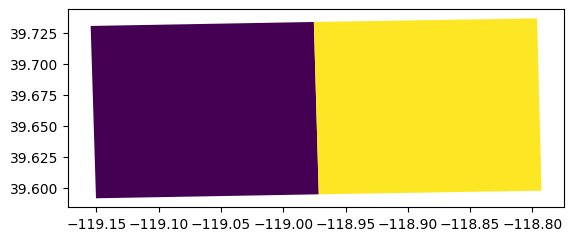

In [ ]:
# Convert into GeoDataFrame and visualize embeddings
index_gdf = gpd.GeoDataFrame(index, geometry = bboxs)
print(index_gdf.head())

# Visualize first dimension of embedding
index_gdf_first = gpd.GeoDataFrame(geometry = index_gdf['geometry'])
index_gdf_first['emb'] = index_gdf['embeddings'].apply(lambda x: x[0]) # Change 0 to visualize other dimensions

# Plot first embedding dimension
index_gdf_first.plot(column = 'emb')
plt.show()

In [ ]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(rgb="band", vmin=0, vmax=2000, col_wrap=6)
    plt.show()